In [1]:
import pysam
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
import matplotlib.transforms as tfrms
import seaborn as sns
import matplotlib
from collections import Counter

In [2]:
import splanl.junction_scorer as jn
import splanl.coords as cds
import splanl.merge_bcs as mbcs
import splanl.plots as sp
import splanl.score_motifs as sm
import splanl.inspect_variants as iv
import splanl.post_processing as pp
import splanl.gnomad as gn
import splanl.phylop as phy
import splanl.spliceai as sa

In [3]:
matplotlib.rc_file_defaults()
plt.rcParams[ 'pdf.fonttype' ] = 42
plt.rcParams[ 'ps.fonttype' ] = 42
plt.rcParams[ 'font.sans-serif' ] = "Arial"
plt.rcParams[ 'font.family' ] = "sans-serif"

In [4]:
github_colors = '3182bd6baed69ecae1c6dbefe6550dfd8d3cfdae6bfdd0a231a35474c476a1d99bc7e9c0756bb19e9ac8bcbddcdadaeb636363969696bdbdbdd9d9d9'

In [5]:
light_colors = [ '#' + github_colors[i:i+6] for i in range( 0, len( github_colors ), 6 ) ]

Create a wide dataset

In [6]:
long = pd.read_table( '/nfs/kitzman2/smithcat/proj/campersplice/pouf1_data/pou1f1_by_var_effects_snvs-20210407.txt' )

In [7]:
long.head()

pos alt            chrom ref                   varlist         sample  \
0  1044   A  pspl3_pou1f1_bc   G  pspl3_pou1f1_bc:1044:G:A   brep1_mm1_A4   
1  1044   T  pspl3_pou1f1_bc   G  pspl3_pou1f1_bc:1044:G:T  brep4_mm2_D10   
2  1044   A  pspl3_pou1f1_bc   G  pspl3_pou1f1_bc:1044:G:A   brep2_mm1_B4   
3  1044   C  pspl3_pou1f1_bc   G  pspl3_pou1f1_bc:1044:G:C   brep2_mm1_B4   
4  1044   T  pspl3_pou1f1_bc   G  pspl3_pou1f1_bc:1044:G:T   brep2_mm1_B4   

    n_bc  n_bc_passfilt  sum_reads  sum_reads_passfilt  ...  \
0  183.0          150.0     1883.0              1828.0  ...   
1  124.0           99.0     1661.0              1609.0  ...   
2  183.0          144.0     1681.0              1611.0  ...   
3  194.0          158.0     1892.0              1833.0  ...   
4  121.0          106.0     1410.0              1379.0  ...   

   wmean_bs_null_OTHER  wstdev_bs_null_OTHER  zwmean_bs_null_ALPHA  \
0             0.027473              0.004965              1.532206   
1             0.036109              0.006173             -0.252127   
2             0.027198              0.004783             -1.285525   
3             0.027141              0.004638             -0.436993   
4             0.027069              0.005693             -0.235424   

   zwmean_bs_null_BETA  zwmean_bs_null_SKIP  zwmean_bs_null_OTHER  fc_ALPHA  \
0             0.026281            -2.106833              0.979541  1.024556   
1            -0.335386             0.793869             -0.819996  0.995352   
2            -0.607803             1.111669              1.034480  0.979637   
3            -0.204769             0.509630              0.035626  0.993249   
4             0.352854             0.344067             -0.456628  0.995552   

    fc_BETA   fc_SKIP  fc_OTHER  
0  1.007685  0.857915  1.177029  
1  0.922285  1.059310  0.859822  
2  0.830984  1.074201  1.181910  
3  0.944957  1.032967  1.006088  
4  1.115069  1.027715  0.903972  

[5 rows x 72 columns]

In [8]:
samples = list( set( long['sample'] ) )

In [9]:
samples

['brep5_mm1_E4',
 'brep2_mm1_B4',
 'brep1_mm1_A4',
 'brep1_mm2_A10',
 'brep2_mm2_B10',
 'brep5_mm2_E10',
 'brep4_mm2_D10',
 'brep4_mm1_D4',
 'pool_rep1_alt_fixed',
 'pool_rep1_fixed',
 'pool_rep2_fixed',
 'pool_rep3_fixed',
 'brep3_mm1_C4',
 'brep3_mm2_C10']

In [10]:
wide = mbcs.combine_rep_pervartbls_wide( [ long.query( 'sample == "%s"' % samp ) for samp in samples ],
                                           samples,
                                           indexcols=['chrom','pos','ref','alt','varlist', 'var_type',
                                                      'hgvs_pos', 'ref_aa', 'alt_aa' ] 
                                       )

In [11]:
wide

chrom   pos ref alt                   varlist  var_type  \
0     pspl3_pou1f1_bc  1044   G   A  pspl3_pou1f1_bc:1044:G:A  Intronic   
1     pspl3_pou1f1_bc  1044   G   C  pspl3_pou1f1_bc:1044:G:C  Intronic   
2     pspl3_pou1f1_bc  1044   G   T  pspl3_pou1f1_bc:1044:G:T  Intronic   
3     pspl3_pou1f1_bc  1045   T   A  pspl3_pou1f1_bc:1045:T:A  Intronic   
4     pspl3_pou1f1_bc  1045   T   C  pspl3_pou1f1_bc:1045:T:C  Intronic   
...               ...   ...  ..  ..                       ...       ...   
1065  pspl3_pou1f1_bc  1402   A   G  pspl3_pou1f1_bc:1402:A:G  Intronic   
1066  pspl3_pou1f1_bc  1402   A   T  pspl3_pou1f1_bc:1402:A:T  Intronic   
1067  pspl3_pou1f1_bc  1403   T   A  pspl3_pou1f1_bc:1403:T:A  Intronic   
1068  pspl3_pou1f1_bc  1403   T   C  pspl3_pou1f1_bc:1403:T:C  Intronic   
1069  pspl3_pou1f1_bc  1403   T   G  pspl3_pou1f1_bc:1403:T:G  Intronic   

       hgvs_pos ref_aa alt_aa brep5_mm1_E4_sample  ...  \
0      c.143-79    NaN    NaN        brep5_mm1_E4  ...   
1      c.143-79    NaN    NaN        brep5_mm1_E4  ...   
2      c.143-79    NaN    NaN        brep5_mm1_E4  ...   
3      c.143-78    NaN    NaN        brep5_mm1_E4  ...   
4      c.143-78    NaN    NaN        brep5_mm1_E4  ...   
...         ...    ...    ...                 ...  ...   
1065  c.292+130    NaN    NaN        brep5_mm1_E4  ...   
1066  c.292+130    NaN    NaN        brep5_mm1_E4  ...   
1067  c.292+131    NaN    NaN        brep5_mm1_E4  ...   
1068  c.292+131    NaN    NaN        brep5_mm1_E4  ...   
1069  c.292+131    NaN    NaN        brep5_mm1_E4  ...   

      brep3_mm2_C10_wmean_bs_null_OTHER  brep3_mm2_C10_wstdev_bs_null_OTHER  \
0                              0.037997                            0.006108   
1                              0.037914                            0.005762   
2                              0.037930                            0.007037   
3                              0.037909                            0.007982   
4                              0.037981                            0.006577   
...                                 ...                                 ...   
1065                           0.038154                            0.010001   
1066                           0.037396                            0.017855   
1067                           0.037891                            0.008416   
1068                           0.038069                            0.010723   
1069                           0.037914                            0.007289   

      brep3_mm2_C10_zwmean_bs_null_ALPHA  brep3_mm2_C10_zwmean_bs_null_BETA  \
0                               0.549097                          -0.249799   
1                               1.942915                          -1.655444   
2                              -0.397416                           0.122844   
3                               0.266084                          -0.584291   
4                              -0.252099                          -0.615165   
...                                  ...                                ...   
1065                           -1.037557                          -0.448751   
1066                           -0.825055                           0.733046   
1067                           -0.538102                          -1.230126   
1068                            0.752197                           0.241307   
1069                           -0.033747                           1.167807   

      brep3_mm2_C10_zwmean_bs_null_SKIP  brep3_mm2_C10_zwmean_bs_null_OTHER  \
0                             -0.897813                            0.664605   
1                             -1.636221                            0.195234   
2                              0.616117                           -0.385578   
3                             -0.423074                            0.649662   
4                              0.261938                            0.527570   
...                                 ...       

In [12]:
wide[ 'chrom' ] = 3

In [13]:
wide[ 'gdna_pos_hg19' ] = cds.vpos_to_gpos( wide.pos,
                                            ( 1038, 1450 ),
                                            [ 87322319, 87322731 ],
                                            rev_strand = True ) 

In [14]:
wide[ 'gdna_pos_hg38' ] = cds.vpos_to_gpos( wide.pos,
                                            ( 1038, 1450 ),
                                            [ 87273169, 87273581 ],
                                            rev_strand = True ) 

In [15]:
wide[ 'n_bc' ] = wide[ [ col for col in wide.columns if col.endswith( 'bc' ) and not col.startswith( 'n' ) ] ].median( axis = 1 )

In [16]:
wide[ 'n_bc_passfilt' ] = wide[ [ col for col in wide.columns if col.endswith( 'bc_passfilt' ) and not col.startswith( 'n' ) and '_per_' not in col ] ].median( axis = 1 )

In [17]:
wide[ 'n_bc_max' ] = wide[ [ col for col in wide.columns if col.endswith( '_n_bc' ) ] ].max( axis = 1 )

In [18]:
wide[ 'sum_reads_passfilt' ]  = wide[ [ col for col in wide if '_sum_reads_passfilt' in col ] ].sum( axis = 1 )

In [19]:
iso_names = [ 'ALPHA', 'BETA', 'SKIP', 'OTHER' ]

In [20]:
wide = wide.drop( columns = [ col for col in wide.columns if 'zwmean' in col and '_bs_null_' not in col ] )

In [21]:
wide = wide.rename( columns = { col: col.replace( 'bs_null_', '' ) 
                                for col in [ col for col in wide if 'zwmean_bs_null_' in col ] } )

In [22]:
wide = pp.stouffers_z( wide,
                       iso_names,
                       zcol = 'zwmean_')

In [23]:
wide[ 'zwmean_NONALPHA_max' ] = wide[ [ 'zwmean_BETA', 'zwmean_SKIP', 'zwmean_OTHER' ] ].max( axis = 1 )

In [24]:
wide[ 'wmean_BETA' ] = 100*( wide[ [ col for col in wide.columns if '_wmean_BETA' in col ] ].median( axis = 1 ) )

In [25]:
wide[ 'wmean_SKIP' ] = 100*( wide[ [ col for col in wide.columns if '_wmean_SKIP' in col ] ].median( axis = 1 ) )

In [26]:
wide[ 'wmean_OTHER' ] = 100*( wide[ [ col for col in wide.columns if '_wmean_OTHER' in col ] ].median( axis = 1 ) )

In [27]:
wide[ 'wmean_ALPHA' ] = 100*( wide[ [ col for col in wide.columns if col.endswith( '_wmean_ALPHA' ) ] ].median( axis = 1 ) )

In [28]:
wide[ 'wmean_bs_null_BETA' ] = 100*( wide[ [ col for col in wide.columns if '_wmean_bs_null_BETA' in col ] ].median( axis = 1 ) )

In [29]:
wide[ 'wmean_bs_null_SKIP' ] = 100*( wide[ [ col for col in wide.columns if '_wmean_bs_null_SKIP' in col ] ].median( axis = 1 ) )

In [30]:
wide[ 'wmean_bs_null_OTHER' ] = 100*( wide[ [ col for col in wide.columns if '_wmean_bs_null_OTHER' in col ] ].median( axis = 1 ) )

In [31]:
wide[ 'wmean_bs_null_ALPHA' ] = 100*( wide[ [ col for col in wide.columns if col.endswith( '_wmean_bs_null_ALPHA' ) ] ].median( axis = 1 ) )

In [32]:
wide[ 'fc_BETA' ] = wide[ [ col for col in wide.columns if '_fc_BETA' in col ] ].median( axis = 1 )

In [33]:
wide[ 'fc_SKIP' ] = wide[ [ col for col in wide.columns if '_fc_SKIP' in col ] ].median( axis = 1 )

In [34]:
wide[ 'fc_ALPHA' ] = wide[ [ col for col in wide.columns if col.endswith( '_fc_ALPHA' ) ] ].median( axis = 1 )

In [35]:
wide[ 'fc_OTHER' ] = wide[ [ col for col in wide.columns if '_fc_OTHER' in col ] ].median( axis = 1 )

In [36]:
wide[ 'fc_NONALPHA_max' ] = wide[ [ 'fc_BETA', 'fc_SKIP', 'fc_OTHER' ] ].max( axis = 1 )

In [37]:
bonferoni = ss.norm.ppf( 1 - ( .05 / ( 3*len( wide ) ) ) )

In [38]:
wide = pp.sdv_by_iso( wide,
                      iso_names,
                     'zwmean_',
                     bonferoni,
                     'fc_',
                     3,
                     abs_val = False )

In [39]:
wide[ 'sdv' ] = wide[ [ 'sdv_BETA', 'sdv_SKIP', 'sdv_OTHER' ] ].any( axis = 'columns' )

In [40]:
for samp in samples:
    
    for iso in iso_names:
        
        wide[ samp + '_sdv_' + iso ] = ( wide[ samp + '_zwmean_' + iso ] > bonferoni ) \
                                       & ( wide[ samp + '_fc_' + iso ] > 3 )

In [41]:
for samp in samples:
    
    wide[ samp + '_sdv' ] = wide[ [ samp + '_sdv_' + iso for iso in [ 'BETA', 'SKIP', 'OTHER' ] ] ].any( axis = 'columns' )

In [42]:
wide[ 'sdv_count' ] = wide[ [ col for col in wide if col.endswith( '_sdv' ) ] ].sum( axis = 1 )

In [43]:
wide.loc[ wide.sdv_count < 7, 'sdv' ] = False
wide.loc[ wide.sdv_count < 7, 'sdv_BETA' ] = False
wide.loc[ wide.sdv_count < 7, 'sdv_SKIP' ] = False
wide.loc[ wide.sdv_count < 7, 'sdv_OTHER' ] = False

In [44]:
wide = pp.sdv_by_iso( wide,
                      iso_names,
                     'zwmean_',
                     bonferoni,
                     'fc_',
                     2,
                     abs_val = False,
                     out_col_stem = 'intmed_' )

In [45]:
for iso in iso_names:
    
    wide[ 'intmed_' + iso ] = [ False if sdv else intmed for sdv, intmed in zip( wide[ 'sdv_' + iso ], wide[ 'intmed_' + iso ] ) ]  

In [46]:
#done this way to ensure variants are coded by worst consequence (ie no sdv are intermediate)
wide[ 'intmed' ] = False
wide.loc[ ~wide.sdv, 'intmed' ] = wide.loc[ ~wide.sdv ][ [ 'intmed_BETA', 'intmed_SKIP', 'intmed_OTHER' ] ].any( axis = 'columns' )

In [47]:
for samp in samples:
    
    for iso in iso_names:
        
        wide[ samp + '_intmed_' + iso ] = ( wide[ samp + '_zwmean_' + iso ] > bonferoni ) \
                                           & ( wide[ samp + '_fc_' + iso ] > 2 ) \
                                           & ( wide[ samp + '_sdv_' + iso ] == False )

In [48]:
for samp in samples:
    
    wide[ samp + '_intmed' ] = False
    wide.loc[ ~wide[ samp + '_sdv_' + iso ], samp + '_intmed' ] = wide.loc[ ~wide[ samp + '_sdv_' + iso ] ][ [ samp + '_intmed_' + iso for iso in [ 'BETA', 'SKIP', 'OTHER' ] ] ].any( axis = 'columns' )

In [49]:
wide[ 'intmed_count' ] = wide[ [ col for col in wide if col.endswith( '_intmed' ) ] ].sum( axis = 1 )

In [50]:
wide[ 'intmed_sdv' ] = ( wide.sdv ) | ( wide.intmed )

In [51]:
#note 'patient variants' include our two from the literature
wide = pp.identify_var( wide,
                       [ (1118, 'G' ),
                         ( 1128, 'G' ),
                         ( 1130, 'G' ),
                         ( 1132, 'G' ),
                         ( 1133, 'A' ),
                         ( 1135, 'G' ),
                         ( 1137, 'G' ),
                         ( 1199, 'G' ),
                         ( 1273, 'T' ) 
                       ],
                      'patient_var', )
###  Original patient mutations
#  S50A = c.148 T>G = 1128
#  S50S = c.150 T>G = 1130
#  I51S = c.152 T>G = 1132
#  I51I = c.153 T>A = 1133
#  L52W = c.155 T>G = 1135
#  S53A = c.157 T>G = 1137
#  T73T = c.219 A>G = 1199

In [52]:
#these are the list of validation variants in the next dataset
wide = pp.identify_var( wide,
                       [ (1118, 'G' ),
                         (1123, 'G' ),
                         ( 1128, 'G' ),
                         ( 1130, 'G' ),
                         ( 1132, 'G' ),
                         ( 1135, 'G' ),
                         ( 1137, 'G' ),
                         ( 1140, 'G' ),
                         ( 1141, 'G' ),
                         ( 1149, 'G' ),
                         ( 1158, 'C' ),
                         ( 1168, 'G' ),
                         ( 1177, 'A' ),
                         ( 1189, 'A' ),
                         ( 1195, 'G' ),
                         ( 1238, 'A' ),
                         ( 1272, 'A' ) 
                       ],
                       'val_var', )

In [53]:
valvars_df = pd.read_table( '/nfs/kitzman2/smithcat/proj/campersplice/pouf1_data/valvar_jnuse.2021-0414.txt' )

In [54]:
valvars_df

sample  OtherJn_Prop  Unmapped     AlphaDon2      AltAcc3   Crypt  \
0   SJ_JKP522      2.381746     33254      0.000000     0.000000     0.0   
1   SJ_JKP548      1.383038     37733  10775.333333     0.000000  5150.0   
2   SJ_JKP549      1.562854     51359   1479.500000     0.000000  1232.5   
3   SJ_JKP550      1.301514     42912   5732.833333     0.000000  2917.5   
4   SJ_JKP551      1.472158     47742   3946.000000     0.000000  2205.0   
5   SJ_JKP552      2.218547     47674   3574.666667     0.000000  1917.5   
6   SJ_JKP862      1.036891     50388   5996.000000     1.000000  3716.5   
7   SJ_JKP863      1.369488     29590   3241.000000     0.000000  2175.5   
8   SJ_JKP864      1.381392     43113  17230.500000     0.000000  8201.5   
9   SJ_JKP865      0.993734     35953    217.500000     0.000000    78.0   
10  SJ_JKP866      2.037760     30938   2766.000000     0.000000  1186.0   
11  SJ_JKP867      0.880322     45880   9580.500000     0.000000  4025.0   
12  SJ_JKP869      1.036096     23991   1800.500000     0.000000   702.5   
13  SJ_JKP870      1.661125     35310    279.000000     0.000000   213.5   
14  SJ_JKP871      1.293909     22729   5191.166667  8379.333333  2177.5   
15  SJ_JKP872      1.127988     19339   4298.000000     0.000000   306.0   
16  SJ_JKP873      1.017701     62209   5768.500000    33.000000  2900.0   
17  SJ_JKP897      1.132536     34262  11053.500000     0.000000  3437.0   
18  SJ_JKP900      0.886041     33000   4530.000000     0.000000  1941.0   

    Unspliced_Prop  Skip1  Mapped  AltAcc3_Prop  ...  AltAcc4_Prop  Spliced  \
0        86.620493    0.0  119982      0.000000  ...      0.000000    16053   
1        70.821217    0.0  144091      0.000000  ...      0.000000    42044   
2        79.497471   15.0  148489      0.000000  ...      0.000000    30444   
3        75.052947    2.0  118042      0.000000  ...      0.000000    29448   
4        77.469694    3.0  103363      0.000000  ...      0.000000    23288   
5        75.432784    3.5   84511      0.000000  ...      0.000000    20762   
6        74.561618    1.0  118447      0.000844  ...      0.000000    30131   
7        72.282817    1.0   62712      0.000000  ...      0.000000    17382   
8        72.592608    0.0  242690      0.000000  ...      0.000000    66515   
9        75.629011   18.0   88035      0.000000  ...      0.000000    21455   
10       83.471147    7.0  103038      0.000000  ...      0.000000    17031   
11       74.401372    1.0  152766      0.000000  ...      0.000000    39106   
12       89.012034    3.0  154651      0.000000  ...      0.000000    16993   
13       81.316180    0.0   89623      0.000000  ...      0.000000    16745   
14       78.576435    0.0   94172      8.897903  ...      0.000000    20175   
15       83.985371    0.0   71366      0.000000  ...      7.774711    11429   
16       82.745473    0.0  137958      0.023920  ...      0.028994    23804   
17       71.021716    0.0  137641      0.000000  ...      0.000000    39886   
18       74.412834    0.0   68507      0.000000  ...      0.000000    17529   

    Unmapped_Prop  Other_Prop  Skip_Prop  Tot_Named_Prop  Beta_Prop_Norm  \
0       21.701167    0.000000  10.997761       10.997761        0.000000   
1       20.752486    0.007634   0.589558       11.796943        1.247181   
2       25.699031    0.000673  13.096817       15.580166       15.314569   
3       26.661034    0.000000   3.684988       12.411119       69.599099   
4       31.595248    0.000000   4.488550       11.725666       56.051980   
5       36.066119    0.000000   4.493991       12.564538       59.382676   
6       29.844523    0.006332   2.672503       11.435916       39.987450   
7       32.057810    0.009568   2.983480       12.562986        1.992765   
8       15.084866    1.892332   0.401541       10.401129        4.074478   
9       28.997161    0.000000  22.520778       22.910395        0.024790   
10      23.092196    0.002912   4.594583        8.910628       37.000

In [55]:
#0 is empty, 1 is WT and the rest correspond to the plasmid name
#this is just used to sort the variants for the plot
valvars_df[ 'pos' ] = [ 0, 1, 1128, 1132, 1135, 1137, 1140, 1158, 1195, 1272, 1123, 1141, 1189, 
                        1118, 1149, 1168, 1238, 1177, 1130 ]

In [56]:
#this ensures variants at the alpha acceptor are not counted as synonymous
wide.loc[ ( wide.pos == 1199 ) | ( wide.pos == 1200 ) | ( wide.pos == 1121 ) | ( wide.pos == 1122 ) \
          | (wide.pos == 1273 ) | ( wide.pos == 1274 ), 'var_type' ] = 'Essential Splice'

In [57]:
#these were computed by hand because they're out of frame
wide.loc[ wide.pos == 1123, 'ref_aa' ] = 'V'
wide.loc[ wide.pos == 1124, 'ref_aa' ] = 'V'
wide.loc[ wide.pos == 1272, 'ref_aa' ] = 'G'

wide.loc[ ( wide.pos == 1123 ) & ( wide.alt == 'A' ), 'alt_aa' ] = 'D'
wide.loc[ ( wide.pos == 1123 ) & ( wide.alt == 'C' ), 'alt_aa' ] = 'A'
wide.loc[ ( wide.pos == 1123 ) & ( wide.alt == 'G' ), 'alt_aa' ] = 'G'
wide.loc[ wide.pos == 1124, 'alt_aa' ] = 'V'
wide.loc[ ( wide.pos == 1272 ) & ( wide.alt == 'A' ), 'alt_aa' ] = 'S'
wide.loc[ ( wide.pos == 1272 ) & ( wide.alt == 'C' ), 'alt_aa' ] = 'R'
wide.loc[ ( wide.pos == 1272 ) & ( wide.alt == 'T' ), 'alt_aa' ] = 'C'

wide.loc[ wide.pos == 1123, 'var_type' ] = 'Missense'
wide.loc[ wide.pos == 1124, 'var_type' ] = 'Synonymous'
wide.loc[ wide.pos == 1272, 'var_type' ] = 'Missense'

In [58]:
wide[ 'aa_pos' ] = np.nan
aa_n = 48
last_aa = 'V'
bp_count = 1

for row in wide.loc[ wide.ref_aa.notnull() ][ [ 'pos', 'ref_aa' ] ].groupby( 'pos' ).__iter__():
    
    pos = row[ 1 ].pos.unique()[ 0 ]
    aa = row[ 1 ].ref_aa.unique()[ 0 ]
    
    if aa == last_aa and bp_count < 3:
        
        wide.loc[ wide.pos == pos, 'aa_pos' ] = aa_n
        bp_count += 1
    
    else:
        
        aa_n += 1
        wide.loc[ wide.pos == pos, 'aa_pos' ] = aa_n
        last_aa = aa
        bp_count = 1

In [59]:
wide[ 'prot_con' ] = [ 'p.' + str( int( pos ) ) + ':' + refalt[ 0 ] + '>' + refalt[ 1 ] 
                       if not np.isnan( pos ) else np.nan
                       for pos, refalt in zip( wide.aa_pos, zip( wide.ref_aa, wide.alt_aa ) ) ]

In [60]:
#these variables are mainly for the UpSet plot
wide[ 'exon_sdv' ] = False
wide[ 'exona_sdv' ] = False
wide[ 'exonb_sdv' ] = False
wide[ 'intron_sdv' ] = False
wide[ 'ss_sdv' ] = False
wide[ 'synonymous_sdv' ] = False
wide.loc[ ( wide.pos >= 1123 ) & ( wide.pos <= 1272 ) & ( wide.sdv ), 'exon_sdv' ] = True
wide.loc[ ( wide.pos >= 1201 ) & ( wide.pos <= 1272 ) & ( wide.sdv ), 'exona_sdv' ] = True
wide.loc[ ( wide.pos >= 1123 ) & ( wide.pos < 1201 ) & ( wide.sdv ), 'exonb_sdv' ] = True
wide.loc[ ( wide.var_type == 'Intronic' ) & ( wide.sdv ), 'intron_sdv' ] = True
wide.loc[ ( wide.var_type == 'Essential Splice' ) & ( wide.sdv ), 'ss_sdv' ] = True
wide.loc[ ( wide.var_type == 'Synonymous' ) & ( wide.sdv ), 'synonymous_sdv' ] = True

In [61]:
#create boolean sdv cols for each .1 change in fc thresh
for i in np.arange( 1, 5.1, .1 ):
    wide[ 'fc_%.1f' % ( i ) ] = ( wide.zwmean_NONALPHA_max >= bonferoni ) & ( wide.fc_NONALPHA_max >= i )

In [62]:
wide[ 'ESS_region' ] = ( wide.pos >= 1122 ) & ( wide.pos <= 1147 )

In [63]:
gnomad2 = pd.read_table( '/nfs/kitzman2/smithcat/proj/campersplice/pouf1_data/gnomad_v2_pou1f1.txt' )

In [64]:
gnomad3 = pd.read_table( '/nfs/kitzman2/smithcat/proj/campersplice/pouf1_data/gnomad_v3_pou1f1.txt' )

In [65]:
wide = gn.merge_data_gnomad( wide,
                             gnomad2.drop( columns = 'index' ),
                             suffix = 'v2')

In [66]:
wide = gn.merge_data_gnomad( wide,
                             gnomad3.drop( columns = 'index' ),
                             suffix = 'v3')

In [67]:
wide[ 'afl_v2' ] = np.log10( wide.af_v2 + .00000001 )

In [68]:
wide[ 'afl_v3' ] = np.log10( wide.af_v3 + .00000001 )

In [69]:
wide[ 'gnomad_var' ] = ( wide.af_v3.notnull() | wide.af_v2.notnull() )

In [70]:
#switches two variants filtered out of gnomad to missing
wide.loc[ ( wide.afl_v2.isnull() == False ) & ( wide.afl_v2 == -8 ), 'gnomad_var' ] = False
wide.loc[ ( wide.afl_v2.isnull() == False ) & ( wide.afl_v2 == -8 ), 'afl_v2' ] = np.nan
wide.loc[ ( wide.af_v2 == 0 ), 'af_v2' ] = np.nan
wide.loc[ ( wide.afl_v3.isnull() == False ), 'gnomad_var' ] = True

In [71]:
fasta = '/nfs/kitzman2/jacob/proj/campersplice/refs/pspl3_pou1f1_bc.fa'
refseq = pp.get_refseq( fasta )[ 0 ]

In [72]:
wide = pp.acceptors_donors(refseq,
                            wide,
                            'sdv_OTHER'
                             )

In [73]:
wide = pp.acceptors_donors(refseq,
                            wide,
                            'intmed_OTHER',
                           out_col_suffix = '_intmed'
                             )

In [74]:
#some are creating a GT but only being used as an acceptor
wide[ 'snv_don' ] = False
wide.loc[ ( wide.pos == 1270 ) & ( wide.alt == "T" ), 'snv_don' ] = True

In [75]:
wide = pp.frameshift( wide,
                  'snv_acc', 
                   1201 )

In [76]:
#turned off bc I think this is a special case where its not using the expected isoform
wide.loc[ ( wide.pos == 1180 ) & ( wide.alt == 'A' ), 'frameshift_acc' ] = False

In [77]:
wide = pp.frameshift( wide,
                  'snv_don', 
                  1272,
                  acc = False )

In [78]:
for iso in iso_names:
    wide[ 'sdv_pos_' + iso ] = wide[ [ 'pos', 'sdv_' + iso ] ].groupby( [ 'pos' ] ).transform( any )

In [79]:
wide[ 'sdv_pos' ] = wide[ [ 'pos', 'sdv' ] ].groupby( [ 'pos' ] ).transform( any )

In [80]:
spliceai = pd.read_table( '/nfs/kitzman2/smithcat/proj/spliceAI/spliceai_tbls/pou1f1_exons_1_to_3_spliceai.txt' )

In [81]:
spliceai[ 'gdna_pos_hg19' ] = spliceai.pos

In [82]:
spliceai = spliceai.rename( columns = { 'ref': 'ref_comp', 'alt': 'alt_comp' } )

In [83]:
spliceai[ 'alt' ] = [ sa.rev_comp_seq( base ) for base in spliceai.alt_comp.tolist() ]

In [84]:
spliceai[ 'ref' ] = [ sa.rev_comp_seq( base ) for base in spliceai.ref_comp.tolist() ]

In [85]:
spliceai = spliceai.drop( columns = [ 'pos', 'chrom', 'alt_comp', 'ref_comp' ] ) 

In [86]:
wide = sa.merge_exper_spliceai(  wide,
                                 spliceai,
                                 exper_idx_col = [ 'gdna_pos_hg19', 'ref', 'alt' ],
                                 spliceai_idx_col = [ 'gdna_pos_hg19', 'ref', 'alt' ] )

In [87]:
wide[ 'DS_max100' ] = 100*wide.DS_max

In [88]:
wide[ ( wide.sdv ) & ( wide.patient_var ) ][ 'DS_max' ]

215    0.21
244    0.31
252    0.33
258    0.36
260    0.18
265    0.31
273    0.28
458    0.41
680    0.98
Name: DS_max, dtype: float64

In [89]:
wide[ 'sa_sdv' ] = ( wide.DS_max >= .18 )

In [90]:
hal_df = pd.read_table( '/nfs/kitzman2/smithcat/proj/campersplice/motifs/hal_pou1f1_ex2_Predictions.tsv' )

In [91]:
hal_df.head()

VARIANT_NAME  \
0  pspl3_pou1f1_bc:1157:A:C   
1  pspl3_pou1f1_bc:1189:T:G   
2  pspl3_pou1f1_bc:1128:T:G   
3  pspl3_pou1f1_bc:1136:G:T   
4  pspl3_pou1f1_bc:1150:C:A   

                                              WT_SEQ  \
0  TCCCATCTATTTTGTCTTTGATCCAAACTCCTAAATGTTTGTGCAC...   
1  TCCCATCTATTTTGTCTTTGATCCAAACTCCTAAATGTTTGTGCAC...   
2  TCCCATCTATTTTGTCTTTGATCCAAACTCCTAAATGTTTGTGCAC...   
3  TCCCATCTATTTTGTCTTTGATCCAAACTCCTAAATGTTTGTGCAC...   
4  TCCCATCTATTTTGTCTTTGATCCAAACTCCTAAATGTTTGTGCAC...   

                                             MUT_SEQ  WT_PSI  MUT_PSI  \
0  TCCCATCTATTTTGTCTTTGATCCAAACTCCTAACTGTTTGTGCAC...      90     93.7   
1  TCCCATCTATTTTGTCTTTGATCCAAACTCCTAAATGTTTGTGCAC...      90     69.7   
2  TCCCAGCTATTTTGTCTTTGATCCAAACTCCTAAATGTTTGTGCAC...      90     87.9   
3  TCCCATCTATTTTTTCTTTGATCCAAACTCCTAAATGTTTGTGCAC...      90     47.1   
4  TCCCATCTATTTTGTCTTTGATCCAAAATCCTAAATGTTTGTGCAC...      90     85.3   

   DELTA_PSI  
0        3.7  
1      -20.3  
2       -2.1  
3      -42.9  
4       -4.7

In [92]:
wide = sm.merge_hal( wide,
                     hal_df, 
                   )

In [93]:
spidex_df = pd.read_table( '/nfs/kitzman2/smithcat/proj/campersplice/motifs/spidex_pou1f1_ex2.txt' )

In [94]:
spidex_df.head()

chrom  gdna_pos_hg19 ref alt  spanr_chgPER_tissue  spanr_chgZPER
0      3       87313237   A   T              -1.0508         -1.499
1      3       87313237   A   G              -0.9068         -1.415
2      3       87313237   A   C              -0.2206         -0.726
3      3       87313238   A   T              -0.2137         -0.713
4      3       87313238   A   G              -1.1203         -1.540

In [95]:
wide = sm.merge_spidex( wide,
                        spidex_df )

In [96]:
mmsplice_df = pd.read_table( '/nfs/kitzman2/smithcat/proj/campersplice/motifs/mmsplice_pou1f1.tsv' )

In [97]:
mmsplice_df.head()

ID                  exons              exon_id  \
0  3:87322397:T>A  3:87322496-87322568:-  ENSE00000995625.1_1   
1  3:87322397:T>C  3:87322496-87322568:-  ENSE00000995625.1_1   
2  3:87322397:T>G  3:87322496-87322568:-  ENSE00000995625.1_1   
3  3:87322398:C>A  3:87322496-87322568:-  ENSE00000995625.1_1   
4  3:87322398:C>G  3:87322496-87322568:-  ENSE00000995625.1_1   

                gene_id gene_name        transcript_id  delta_logit_psi  \
0  ENSG00000064835.10_4    POU1F1  ENST00000350375.6_1         0.015259   
1  ENSG00000064835.10_4    POU1F1  ENST00000350375.6_1         0.107339   
2  ENSG00000064835.10_4    POU1F1  ENST00000350375.6_1        -0.068862   
3  ENSG00000064835.10_4    POU1F1  ENST00000350375.6_1         0.079929   
4  ENSG00000064835.10_4    POU1F1  ENST00000350375.6_1        -0.033492   

   ref_acceptorIntron  ref_acceptor  ref_exon  ...  alt_acceptor  alt_exon  \
0           -3.273354     -2.119842 -2.792019  ...     -2.119842 -2.792019   
1           -3.273354     -2.119842 -2.792019  ...     -2.119842 -2.792019   
2           -3.273354     -2.119842 -2.792019  ...     -2.119842 -2.792019   
3           -3.273354     -2.119842 -2.792019  ...     -2.119842 -2.792019   
4           -3.273354     -2.119842 -2.792019  ...     -2.119842 -2.792019   

   alt_donor  alt_donorIntron  pathogenicity  efficiency  chrom  \
0   4.619498         0.573435       0.346761   -0.122488      3   
1   4.619498         0.614145       0.345892   -0.122488      3   
2   4.619498         0.536245       0.347555   -0.122488      3   
3   4.619498         0.602027       0.346151   -0.122488      3   
4   4.619498         0.551882       0.347221   -0.122488      3   

   gdna_pos_hg19  ref  alt  
0       87322397    A    T  
1       87322397    A    G  
2       87322397    A    C  
3       87322398    G    T  
4       87322398    G    C  

[5 rows x 23 columns]

In [98]:
wide = sm.merge_mmsplice( wide, mmsplice_df )

In [99]:
ke_df = pd.read_csv( '/nfs/kitzman2/smithcat/proj/campersplice/motifs/KeMotifs.csv',
                      header = None,
                      names = [ 'motif', 'score' ] )

ke_df = ke_df.set_index( 'motif' )

In [100]:
wide = sm.score_motifs_mean( refseq,
                             ke_df,
                            'score',
                             wide,
                             6,
                             'ke' )

In [101]:
#ke scores don't make sense for intronic variants
wide.loc[ wide.var_type == 'Intronic', 'ke_chgMEAN' ] = np.nan
wide.loc[ wide.var_type == 'Intronic', 'ke_wtMEAN' ] = np.nan
wide.loc[ wide.var_type == 'Intronic', 'ke_snvMEAN' ] = np.nan

In [102]:
wide[ 'hal_chgPER_abs' ] = np.abs( wide.hal_chgPER )
wide[ 'spanr_chgZPER_abs' ] = np.abs( wide.spanr_chgZPER )
wide[ 'mmsplice_chgPERlogit_abs' ] = np.abs( wide.mmsplice_chgPERlogit )
wide[ 'ke_chgMEAN_abs' ] = np.abs( wide.ke_chgMEAN )

In [103]:
rbp_df = pd.read_csv( '/nfs/kitzman2/smithcat/proj/campersplice/motifs/Zscores.txt',
                  sep = '\t' )
rbp_df = rbp_df.set_index( '7mer' )

In [104]:
rbp_df = sm.RNA_to_DNA( rbp_df )

In [105]:
rbp_info = pd.read_csv( '/nfs/kitzman2/smithcat/proj/campersplice/motifs/RBP_Information.txt',
                  sep = '\t' )

In [106]:
for m in rbp_df:
    wide = sm.score_motifs_max( refseq,
                                 rbp_df,
                                 m,
                                 wide,
                                 7,
                                 m )

In [107]:
%%time
rbp_dict = sm.nom_RBPs( wide,
                        rbp_info,
                        'sdv_BETA',
                        ( 1123, 1147 ),
                        3,
                        -2,
                        .05, )

CPU times: user 1.83 s, sys: 3.86 ms, total: 1.83 s
Wall time: 1.83 s


In [108]:
rbp_dict

{'CPEB2_M012_0.6': (8.94178514956488,
  (6.533333333333333, 0.0009105569485795544)),
 'ELAVL1_M031_0.6': (10.725740700184302,
  (4.230769230769231, 0.016942833644140332)),
 'U2AF2_M077_0.6': (5.642083174430269, (6.0, 0.001636672533176218)),
 'ELAVL1_M108_0.6': (5.762375141252281,
  (5.013333333333334, 0.01704340729497598)),
 'CPEB3_CPEB4_M149_0.6': (9.70904675566111,
  (7.230769230769231, 0.0014784409082719135)),
 'RALY_M150_0.6': (6.757769127351849,
  (5.013333333333334, 0.01704340729497598)),
 'TIA1_M156_0.6': (8.252679631385679, (3.85, 0.02365269445527386)),
 'ELAVL1_M232_0.6': (7.558815703483471,
  (4.230769230769231, 0.016942833644140332))}

In [109]:
rbp_ids = [ r[ -8: ] for r in rbp_dict ]

In [110]:
drop_cols = [ col for col in wide if col.startswith( 'M') and col[ :8 ] not in rbp_ids ]
wide = wide.drop( columns = drop_cols )

In [111]:
maxent = pd.read_csv( '/nfs/kitzman2/smithcat/proj/campersplice/pouf1_data/pou1f1_maxentscan.txt',
                      sep = '\t' )

In [112]:
maxent.head()

pos ref alt  crypt_acc_pos  crypt_wt_3ss_maxent  crypt_snv_3ss_maxent  \
0  1035   C   A         1055.0             0.537634              0.037071   
1  1035   C   G         1055.0             0.537634              0.380222   
2  1035   C   T         1055.0             0.537634             -0.164330   
3  1036   A   C         1055.0             0.537634              2.327258   
4  1036   A   G         1055.0             0.537634              2.005807   

   crypt_3ss_maxent_chg  crypt_don_pos  crypt_wt_5ss_maxent  \
0             -0.500563            NaN                  NaN   
1             -0.157412            NaN                  NaN   
2             -0.701964            NaN                  NaN   
3              1.789624            NaN                  NaN   
4              1.468173            NaN                  NaN   

   crypt_snv_5ss_maxent  crypt_5ss_maxent_chg  alt_don_pos  alt_wt_5ss_maxent  \
0                   NaN                   NaN          NaN                NaN   
1                   NaN                   NaN          NaN                NaN   
2                   NaN                   NaN          NaN                NaN   
3                   NaN                   NaN          NaN                NaN   
4                   NaN                   NaN          NaN                NaN   

   alt_snv_5ss_maxent  alt_5ss_maxent_chg  alt_acc_pos  alt_wt_3ss_maxent  \
0                 NaN                 NaN          NaN                NaN   
1                 NaN                 NaN          NaN                NaN   
2                 NaN                 NaN          NaN                NaN   
3                 NaN                 NaN          NaN                NaN   
4                 NaN                 NaN          NaN                NaN   

   alt_snv_3ss_maxent  alt_3ss_maxent_chg  
0                 NaN                 NaN  
1                 NaN                 NaN  
2                 NaN                 NaN  
3                 NaN                 NaN  
4                 NaN                 NaN

In [113]:
idx_cols = [ 'pos', 'ref', 'alt' ]

In [114]:
#this creates some duplicate rows in the dataframe which is annoying but manageable
wide = pd.merge( wide.set_index( idx_cols ),
                 maxent.set_index( idx_cols ),
                 left_index = True,
                 right_index = True,
                 how = 'left'
                 ).reset_index()

In [115]:
satbl = pd.read_csv( '/nfs/kitzman2/jacob/proj/campersplice/pou1f1_subassembly_deep_20190917/pou1f1_subasm_joined_191011.tsv' ,
                    sep='\t' )

In [116]:
isos_df = pd.read_csv( '/nfs/kitzman2/smithcat/proj/campersplice/pouf1_data/pou1f1_isoforms_2020-0827.txt',
                      sep = '\t'
                    )

In [117]:
isos_df.head()

isonum                                     isoform  \
0  iso0000                ((1201, 1258), (1505, 1543))   
1  iso0001  ((1201, 1250), (1258, 1272), (1440, 1477))   
2  iso0002                             ((1242, 1272),)   
3  iso0003                ((1201, 1272), (1730, 1755))   
4  iso0004                ((1123, 1131), (1134, 1213))   

   hb_brep1_mm1_A4_read_count  hb_brep1_mm2_A10_read_count  \
0                           0                            0   
1                           0                            0   
2                           0                            0   
3                           0                            1   
4                           0                            0   

   hb_brep2_mm1_B4_read_count  hb_brep2_mm2_B10_read_count  \
0                           0                            0   
1                           0                            0   
2                           0                            0   
3                           4                            4   
4                           0                            0   

   hb_brep3_mm1_C4_read_count  hb_brep3_mm2_C10_read_count  \
0                           0                            0   
1                           0                            0   
2                           0                            0   
3                           0                            0   
4                           0                            0   

   hb_brep4_mm1_D4_read_count  hb_brep4_mm2_D10_read_count  ...  \
0                           0                            1  ...   
1                           0                            0  ...   
2                           0                            0  ...   
3                           0                            1  ...   
4                           0                            0  ...   

   og_pool_rep2_fixed_filter  og_pool_rep3_fixed_num_bcs  \
0                        0.0                         0.0   
1                        0.0                         0.0   
2                        0.0                         2.0   
3                        0.0                         0.0   
4                        0.0                         0.0   

   og_pool_rep3_fixed_num_vars  og_pool_rep3_fixed_max_reads_per_bc  \
0                          0.0                                  0.0   
1                          0.0                                  0.0   
2                          2.0                                  1.0   
3                          0.0                                  0.0   
4                          0.0                                  0.0   

   og_pool_rep3_fixed_max_bc_per_var  og_pool_rep3_fixed_filter  \
0                                0.0                        0.0   
1                                0.0                        0.0   
2                                1.0                        0.0   
3                                0.0                        0.0   
4                                0.0                        0.0   

   total_read_count  total_num_bcs  total_num_vars  total_passfilt  
0                 1            1.0             1.0               0  
1                 5            5.0             5.0               0  
2                 9            9.0             9.0               0  
3                10            6.0             6.0               0  
4                 2            2.0             2.0               0  

[5 rows x 90 columns]

In [118]:
isos_df[ 'filter_sum' ] = isos_df[ [ col for col in isos_df.columns if '_filter' in col ] ].sum( axis = 1 )

Output directories

In [119]:
plot_out = '/nfs/kitzman2/smithcat/proj/campersplice/plot_pdfs/'

In [120]:
bdout = '/nfs/kitzman2/smithcat/proj/campersplice/pouf1_data/'

Abstract

In [121]:
#1070 variants tested
( wide
  [ [ 'pos', 'alt', 'ref', 'zwmean_BETA', 'zwmean_SKIP', 'zwmean_OTHER' ] ]
  .groupby( [ 'pos', 'alt', 'ref', ] )
  .agg( np.nanmean )
  .reset_index() ).shape

(1070, 6)

In [122]:
#96 sdvs
( wide.loc[ ( wide.sdv ) ]
  [ [ 'pos', 'alt', 'ref', 'zwmean_BETA', 'zwmean_SKIP', 'zwmean_OTHER' ] ]
  .groupby( [ 'pos', 'alt', 'ref', ] )
  .agg( np.nanmean )
  .reset_index() ).shape

(96, 6)

In [123]:
#14 synonymous sdvs
( wide.loc[ ( wide.sdv ) & ( wide.var_type == "Synonymous" ) ]
  [ [ 'pos', 'alt', 'ref', 'zwmean_BETA', 'zwmean_SKIP', 'zwmean_OTHER' ] ]
  .groupby( [ 'pos', 'alt', 'ref', ] )
  .agg( np.nanmean )
  .reset_index() ).shape

(14, 6)

Introduction

In [124]:
#132 total (sdv + intmed)
( wide.loc[ ( wide.intmed_sdv ) ]
  [ [ 'pos', 'alt', 'ref', 'zwmean_BETA', 'zwmean_SKIP', 'zwmean_OTHER' ] ]
  .groupby( [ 'pos', 'alt', 'ref', ] )
  .agg( np.nanmean )
  .reset_index() ).shape

(132, 6)

Methods

In [125]:
#79 upstream flanking intronic bps 
( wide.loc[ ( ( wide.var_type == "Intronic" ) | ( wide.var_type == "Essential Splice" ) ) & ( wide.pos < 1123 ) ]
  [ [ 'pos', 'alt', 'ref', 'zwmean_BETA', 'zwmean_SKIP', 'zwmean_OTHER' ] ]
  .groupby( [ 'pos', 'alt', 'ref', ] )
  .agg( np.nanmean )
  .reset_index()
  .pos
  .unique() ).shape

(79,)

In [126]:
#131 upstream flanking intronic bps 
( wide.loc[ ( ( wide.var_type == "Intronic" ) | ( wide.var_type == "Essential Splice" ) ) & ( wide.pos > 1272 ) ]
  [ [ 'pos', 'alt', 'ref', 'zwmean_BETA', 'zwmean_SKIP', 'zwmean_OTHER' ] ]
  .groupby( [ 'pos', 'alt', 'ref', ] )
  .agg( np.nanmean )
  .reset_index()
  .pos
  .unique() ).shape

(131,)

Results

In [127]:
#none of the original missense patient variants are in gnomad
wide.loc[ wide.patient_var ][ [ 'pos', 'ref', 'alt', 'gnomad_var', 'af_v2', 'af_v3' ] ]

pos ref alt  gnomad_var     af_v2     af_v3
254  1118   A   G       False       NaN       NaN
285  1128   T   G       False       NaN       NaN
291  1130   T   G       False       NaN       NaN
297  1132   T   G       False       NaN       NaN
298  1133   T   A       False       NaN       NaN
306  1135   T   G       False       NaN       NaN
312  1137   T   G       False       NaN       NaN
552  1199   A   G        True  0.000004  0.000007
553  1199   A   G        True  0.000004  0.000007
930  1273   G   T       False       NaN       NaN
931  1273   G   T       False       NaN       NaN
932  1273   G   T       False       NaN       NaN

In [128]:
#beta acceptor maxent score is 6.96
( wide.loc[ ( wide.pos == 1123 ) ]
  [ [ 'pos', 'alt', 'ref', 'crypt_wt_3ss_maxent' ] ]
  .groupby( [ 'pos', 'alt', 'ref', ] )
  .agg( np.nanmean )
  .reset_index() )

pos alt ref  crypt_wt_3ss_maxent
0  1123   A   T             6.959332
1  1123   C   T             6.959332
2  1123   G   T             6.959332

In [129]:
#alpha acceptor maxent score is -3.63
( wide.loc[ ( wide.pos == 1201 ) & ( wide.crypt_acc_pos == 1201 ) ]
  [ [ 'pos', 'alt', 'ref', 'crypt_acc_pos', 'crypt_wt_3ss_maxent' ] ]
 )

pos alt ref  crypt_acc_pos  crypt_wt_3ss_maxent
562  1201   A   C         1201.0            -3.634894
564  1201   G   C         1201.0            -3.634894
566  1201   T   C         1201.0            -3.634894

In [130]:
#150 exonic bps
( wide.loc[ ( wide.pos >= 1123 ) & ( wide.pos <= 1272 ) ]
  [ [ 'pos', 'alt', 'ref', 'zwmean_BETA', 'zwmean_SKIP', 'zwmean_OTHER' ] ]
  .groupby( [ 'pos', 'alt', 'ref', ] )
  .agg( np.nanmean )
  .reset_index()
  .pos
  .unique() ).shape

(150,)

In [131]:
#210 intronic bps
( wide.loc[ ( wide.pos < 1123 ) | ( wide.pos > 1272 ) ]
  [ [ 'pos', 'alt', 'ref', 'zwmean_BETA', 'zwmean_SKIP', 'zwmean_OTHER' ] ]
  .groupby( [ 'pos', 'alt', 'ref', ] )
  .agg( np.nanmean )
  .reset_index()
  .pos
  .unique() ).shape

(210,)

In [132]:
#1080 variants total
3*( wide.pos.max() - wide.pos.min() + 1 )

1080

In [133]:
#255023 total barcodes
satbl.shape

(255023, 35)

In [134]:
#188772 SNV barcodes
satbl.loc[ satbl.n_variants_passing == 1 ].shape

(188772, 35)

In [135]:
#74.0% are SNV barcodes
100*( satbl.loc[ satbl.n_variants_passing == 1 ].shape[ 0 ] / satbl.shape[ 0 ] )

74.02155883979093

In [136]:
#1070 variants tested
( wide
  [ [ 'pos', 'alt', 'ref', 'zwmean_BETA', 'zwmean_SKIP', 'zwmean_OTHER' ] ]
  .groupby( [ 'pos', 'alt', 'ref', ] )
  .agg( np.nanmean )
  .reset_index() ).shape

(1070, 6)

In [137]:
#99.1% of all possible variants represented
100*( ( wide
      [ [ 'pos', 'alt', 'ref', 'zwmean_BETA', 'zwmean_SKIP', 'zwmean_OTHER' ] ]
      .groupby( [ 'pos', 'alt', 'ref', ] )
      .agg( np.nanmean )
      .reset_index() ).shape[ 0 ] / ( 3*( wide.pos.max() - wide.pos.min() + 1 ) ) ) 

99.07407407407408

In [138]:
#median 75 barcodes per variant
( wide[ [ 'pos', 'ref', 'alt', 'n_bc_passfilt' ] ]
 .groupby( [ 'pos', 'ref', 'alt' ] )
 .agg( np.nanmean )
 .median()
)

n_bc_passfilt    75.0
dtype: float64

In [139]:
#94.2% of SNV barcodes detected across samples
#n_bc_max is the max # of barcodes for each variant across all samples
#number could be a slight underestimate 
#(if say another sample had barcodes outside the set from the sample with the max bcs)
100*( ( wide[ [ 'pos', 'ref', 'alt', 'hgvs_pos', 'n_bc_max' ] ]
  .groupby( [ 'pos', 'ref', 'alt','hgvs_pos' ] )
  .agg( np.nanmean )
  .sum() ) / satbl.loc[ satbl.n_variants_passing == 1 ].shape[ 0 ] )

n_bc_max    94.224249
dtype: float64

In [140]:
#minimum is 81.8%
100*( ( wide[ [ 'pos', 'ref', 'alt', 'hgvs_pos' ] + [ col for col in wide.columns if col.endswith( '_n_bc' ) ] ]
  .groupby( [ 'pos', 'ref', 'alt','hgvs_pos' ] )
  .agg( np.nanmean )
  .sum() ) / satbl.loc[ satbl.n_variants_passing == 1 ].shape[ 0 ] ).min()

81.76424469730681

In [141]:
#maximum is 93.4%
100*( ( wide[ [ 'pos', 'ref', 'alt', 'hgvs_pos' ] + [ col for col in wide.columns if col.endswith( '_n_bc' ) ] ]
  .groupby( [ 'pos', 'ref', 'alt','hgvs_pos' ] )
  .agg( np.nanmean )
  .sum() ) / satbl.loc[ satbl.n_variants_passing == 1 ].shape[ 0 ] ).max()

93.41692623906088

In [142]:
#average is 87.4%
100*( ( wide[ [ 'pos', 'ref', 'alt', 'hgvs_pos' ] + [ col for col in wide.columns if col.endswith( '_n_bc' ) ] ]
  .groupby( [ 'pos', 'ref', 'alt','hgvs_pos' ] )
  .agg( np.nanmean )
  .sum() ) / satbl.loc[ satbl.n_variants_passing == 1 ].shape[ 0 ] ).mean()

87.42594997442116

In [143]:
 ( wide[ [ 'pos', 'ref', 'alt', 'sum_reads_passfilt' ] ]
                    .groupby( [ 'pos', 'ref', 'alt' ] )
                    .agg( np.nanmean )
              ).sum()

sum_reads_passfilt    21721855.0
dtype: float64

In [144]:
#69.2% of reads are ALPHA
#done by taking the weighted mean of alpha for each variant and sample
#then multiplying by the number of reads for each variant and sample
#and summing across variants and samples
#and then dividing by the total reads passing filter
100*( ( ( wide[ [ 'pos', 'ref', 'alt' ] + [ samp + '_wmean_ALPHA' for samp in samples ] ]
                    .groupby( [ 'pos', 'ref', 'alt' ] )
                    .agg( np.nanmean )
              ).rename( columns = { samp + '_wmean_ALPHA': samp for samp in samples } ) \
* \
( wide[ [ 'pos', 'ref', 'alt' ] + [ samp + '_sum_reads_passfilt' for samp in samples ] ]
                    .groupby( [ 'pos', 'ref', 'alt' ] )
                    .agg( np.nanmean )
              ).rename( columns = { samp + '_sum_reads_passfilt': samp for samp in samples } ) 
).sum().sum() /  ( wide[ [ 'pos', 'ref', 'alt', 'sum_reads_passfilt' ] ]
                    .groupby( [ 'pos', 'ref', 'alt' ] )
                    .agg( np.nanmean )
              ).sum() )

sum_reads_passfilt    69.207918
dtype: float64

In [145]:
#25.6% of reads are SKIP
#done by taking the weighted mean of alpha for each variant and sample
#then multiplying by the number of reads for each variant and sample
#and summing across variants and samples
#and then dividing by the total reads passing filter
100*( ( ( wide[ [ 'pos', 'ref', 'alt' ] + [ samp + '_wmean_SKIP' for samp in samples ] ]
                    .groupby( [ 'pos', 'ref', 'alt' ] )
                    .agg( np.nanmean )
              ).rename( columns = { samp + '_wmean_SKIP': samp for samp in samples } ) \
* \
( wide[ [ 'pos', 'ref', 'alt' ] + [ samp + '_sum_reads_passfilt' for samp in samples ] ]
                    .groupby( [ 'pos', 'ref', 'alt' ] )
                    .agg( np.nanmean )
              ).rename( columns = { samp + '_sum_reads_passfilt': samp for samp in samples } ) 
).sum().sum() /  ( wide[ [ 'pos', 'ref', 'alt', 'sum_reads_passfilt' ] ]
                    .groupby( [ 'pos', 'ref', 'alt' ] )
                    .agg( np.nanmean )
              ).sum() )

sum_reads_passfilt    25.576326
dtype: float64

In [146]:
#1.6% of reads are BETA
#done by taking the weighted mean of alpha for each variant and sample
#then multiplying by the number of reads for each variant and sample
#and summing across variants and samples
#and then dividing by the total reads passing filter
100*( ( ( wide[ [ 'pos', 'ref', 'alt' ] + [ samp + '_wmean_BETA' for samp in samples ] ]
                    .groupby( [ 'pos', 'ref', 'alt' ] )
                    .agg( np.nanmean )
              ).rename( columns = { samp + '_wmean_BETA': samp for samp in samples } ) \
* \
( wide[ [ 'pos', 'ref', 'alt' ] + [ samp + '_sum_reads_passfilt' for samp in samples ] ]
                    .groupby( [ 'pos', 'ref', 'alt' ] )
                    .agg( np.nanmean )
              ).rename( columns = { samp + '_sum_reads_passfilt': samp for samp in samples } ) 
).sum().sum() /  ( wide[ [ 'pos', 'ref', 'alt', 'sum_reads_passfilt' ] ]
                    .groupby( [ 'pos', 'ref', 'alt' ] )
                    .agg( np.nanmean )
              ).sum() )

sum_reads_passfilt    1.60217
dtype: float64

In [147]:
#3.6% of reads are OTHER
#done by taking the weighted mean of alpha for each variant and sample
#then multiplying by the number of reads for each variant and sample
#and summing across variants and samples
#and then dividing by the total reads passing filter
100*( ( ( wide[ [ 'pos', 'ref', 'alt' ] + [ samp + '_wmean_OTHER' for samp in samples ] ]
                    .groupby( [ 'pos', 'ref', 'alt' ] )
                    .agg( np.nanmean )
              ).rename( columns = { samp + '_wmean_OTHER': samp for samp in samples } ) \
* \
( wide[ [ 'pos', 'ref', 'alt' ] + [ samp + '_sum_reads_passfilt' for samp in samples ] ]
                    .groupby( [ 'pos', 'ref', 'alt' ] )
                    .agg( np.nanmean )
              ).rename( columns = { samp + '_sum_reads_passfilt': samp for samp in samples } ) 
).sum().sum() /  ( wide[ [ 'pos', 'ref', 'alt', 'sum_reads_passfilt' ] ]
                    .groupby( [ 'pos', 'ref', 'alt' ] )
                    .agg( np.nanmean )
              ).sum() )

sum_reads_passfilt    3.613586
dtype: float64

In [148]:
isogrpdict = jn.create_iso_dict_no_cnst( isos_df.loc[ isos_df.filter_sum > 0 ] )

In [149]:
#278 total isoforms detected
len( isogrpdict )

278

In [150]:
isonamedict = { 'ALPHA': [ ( 1201, 1272 ) ],
              'BETA': [ ( 1123, 1225 ) ],
              'SKIP': [] }

In [151]:
namedisogrps = jn.create_named_isogrps(isogrpdict,
                                        isonamedict,
                                        [ ( 1439, 1538 ) ],
                                        47,
                                        150,
                                        3 )

In [152]:
#262 isoforms map to OTHER
len( namedisogrps[ 'OTHER' ] )

262

In [153]:
#top 20 isoforms account for >80% of OTHER reads

#get total reads for all OTHER isoforms
total = ( isos_df
            .loc[ isos_df.filter_sum > 0 ]
            .loc[ namedisogrps['OTHER'] ]
            .total_read_count
        ).sum()

#Count how many isoforms are represented by n reads
#comes out as { # reads: # isoforms }
i = Counter( isos_df
              .loc[ isos_df.filter_sum > 0 ]
              .loc[ namedisogrps['OTHER'] ]
              .total_read_count
            )

#create list of tuples
#( # of isofoms, proportion of read total )
tup_list = [ ( v, 100*( ( k*v ) / total ) ) for k,v in i.items() ]
#sort the list so we can create a cumulative sum
tup_list.sort( key = lambda x: x[1], reverse = True ) 

iso_cnt = 0
total_prop = 0
for i,p in tup_list:
    iso_cnt += i
    total_prop += p
    print( iso_cnt, 'isoforms make up', total_prop, '% of OTHER isoforms' )

1 isoforms make up 23.360749342726344 % of OTHER isoforms
2 isoforms make up 41.86909341914266 % of OTHER isoforms
3 isoforms make up 46.43663780414768 % of OTHER isoforms
4 isoforms make up 50.56515383756459 % of OTHER isoforms
5 isoforms make up 54.223427364916304 % of OTHER isoforms
6 isoforms make up 57.49342726340686 % of OTHER isoforms
7 isoforms make up 60.09549501081075 % of OTHER isoforms
8 isoforms make up 62.51421132236354 % of OTHER isoforms
9 isoforms make up 64.83014932039426 % of OTHER isoforms
10 isoforms make up 66.85335945509729 % of OTHER isoforms
11 isoforms make up 68.61733984347242 % of OTHER isoforms
12 isoforms make up 70.36520560738175 % of OTHER isoforms
13 isoforms make up 72.04886664704149 % of OTHER isoforms
14 isoforms make up 73.64928994142903 % of OTHER isoforms
15 isoforms make up 75.24121181975981 % of OTHER isoforms
16 isoforms make up 76.72109264767084 % of OTHER isoforms
17 isoforms make up 78.13879894024137 % of OTHER isoforms
18 isoforms make up 7

In [154]:
#median pairwise pearsons r is .92
all_corr = list( ( wide[ [ 'pos', 'ref', 'alt' ] + [ col for col in wide.columns if '_wmean_BETA' in col ] ]
  .groupby( [ 'pos', 'ref', 'alt' ] )
  .agg( np.nanmean )
  .reset_index()[ [ col for col in wide.columns if '_wmean_BETA' in col ] ]
  .corr( method = 'pearson' )
  .stack() ) )

all_corr.append( list( ( wide[ [ 'pos', 'ref', 'alt' ] + [ col for col in wide.columns if '_wmean_SKIP' in col ] ]
  .groupby( [ 'pos', 'ref', 'alt' ] )
  .agg( np.nanmean )
  .reset_index()[ [ col for col in wide.columns if '_wmean_SKIP' in col ] ]
  .corr( method = 'pearson' )
  .stack() ) )[ 0 ] ) 

all_corr.append( 
list( ( wide[ [ 'pos', 'ref', 'alt' ] + [ col for col in wide.columns if '_wmean_OTHER' in col ] ]
  .groupby( [ 'pos', 'ref', 'alt' ] )
  .agg( np.nanmean )
  .reset_index()[ [ col for col in wide.columns if '_wmean_OTHER' in col ] ]
  .corr( method = 'pearson' )
  .stack() ) )[ 0 ] )

all_corr.append( list( ( wide[ [ 'pos', 'ref', 'alt' ] + [ col for col in wide.columns if '_wmean_ALPHA' in col ] ]
  .groupby( [ 'pos', 'ref', 'alt' ] )
  .agg( np.nanmean )
  .reset_index()[ [ col for col in wide.columns if '_wmean_ALPHA' in col ] ]
  .corr( method = 'pearson' )
  .stack() ) )[ 0 ] ) 

all_corr = [ val for val in all_corr if val != 1 ]

np.median( all_corr )

0.9171160005638573

In [155]:
#1070 total variants
( wide
  [ [ 'pos', 'alt', 'ref', 'zwmean_BETA', 'zwmean_SKIP', 'zwmean_OTHER' ] ]
  .groupby( [ 'pos', 'alt', 'ref', ] )
  .agg( np.nanmean )
  .reset_index() ).shape

(1070, 6)

In [156]:
#96 sdvs
( wide.loc[ ( wide.sdv ) ]
  [ [ 'pos', 'alt', 'ref', 'zwmean_BETA', 'zwmean_SKIP', 'zwmean_OTHER' ] ]
  .groupby( [ 'pos', 'alt', 'ref', ] )
  .agg( np.nanmean )
  .reset_index() ).shape

(96, 6)

In [157]:
#average fold change amongst sdvs is 8.10
( wide.loc[ ( wide.sdv ) ]
  [ [ 'pos', 'alt', 'ref', 'fc_NONALPHA_max' ] ]
  .groupby( [ 'pos', 'alt', 'ref', ] )
  .agg( np.nanmean )
  .reset_index() ).mean()

pos                1183.583333
fc_NONALPHA_max       8.104789
dtype: float64

In [158]:
#35 other sdvs
( wide.loc[ ( wide.sdv_OTHER ) ]
  [ [ 'pos', 'alt', 'ref', 'zwmean_BETA', 'zwmean_SKIP', 'zwmean_OTHER' ] ]
  .groupby( [ 'pos', 'alt', 'ref', ] )
  .agg( np.nanmean )
  .reset_index() ).shape

(35, 6)

In [159]:
#35 beta sdvs
( wide.loc[ ( wide.sdv_BETA ) ]
  [ [ 'pos', 'alt', 'ref', 'zwmean_BETA', 'zwmean_SKIP', 'zwmean_OTHER' ] ]
  .groupby( [ 'pos', 'alt', 'ref', ] )
  .agg( np.nanmean )
  .reset_index() ).shape

(35, 6)

In [160]:
#30 skip sdvs
( wide.loc[ ( wide.sdv_SKIP ) ]
  [ [ 'pos', 'alt', 'ref', 'zwmean_BETA', 'zwmean_SKIP', 'zwmean_OTHER' ] ]
  .groupby( [ 'pos', 'alt', 'ref', ] )
  .agg( np.nanmean )
  .reset_index() ).shape

(30, 6)

In [161]:
#26 intronic sdvs
( wide.loc[ ( wide.sdv ) & ( ( wide.pos < 1123 ) | ( wide.pos > 1272 ) )  ]
  [ [ 'pos', 'alt', 'ref', 'zwmean_BETA', 'zwmean_SKIP', 'zwmean_OTHER' ] ]
  .groupby( [ 'pos', 'alt', 'ref', ] )
  .agg( np.nanmean )
  .reset_index() ).shape

(26, 6)

In [162]:
#all but first one are within 20 bp of the exon
#exon bds are (1123, 1272)
( wide.loc[ ( wide.sdv ) & ( ( wide.pos < 1123 ) | ( wide.pos > 1272 ) ) ][ [ 'pos', 'ref', 'alt', 'zwmean_NONALPHA_max' ] ]
  .groupby( [ 'pos', 'ref', 'alt' ] )
  .agg( np.nanmean )
  .reset_index()
  .dropna() 
)

pos ref alt  zwmean_NONALPHA_max
0   1098   G   T            69.087075
1   1108   A   T            42.899804
2   1110   A   T            53.345087
3   1115   C   A           144.614309
4   1115   C   G           113.412737
5   1115   C   T           116.097266
6   1116   T   C           168.868276
7   1116   T   G           170.226958
8   1118   A   C           156.685741
9   1118   A   G            92.680474
10  1118   A   T           247.929529
11  1119   C   A            59.468905
12  1273   G   A           140.947281
13  1273   G   C           122.946174
14  1273   G   T           115.145595
15  1274   T   A           181.924362
16  1274   T   C           110.410066
17  1274   T   G           138.441030
18  1275   A   C           140.500165
19  1275   A   G            89.194995
20  1275   A   T           124.522759
21  1276   A   C           113.263583
22  1276   A   T           141.693712
23  1277   G   A           157.494393
24  1277   G   C           125.344907
25  1277   G   T           116.872816

In [163]:
#36 intermediate 
( wide.loc[ ( wide.intmed ) ]
  [ [ 'pos', 'alt', 'ref', 'zwmean_BETA', 'zwmean_SKIP', 'zwmean_OTHER' ] ]
  .groupby( [ 'pos', 'alt', 'ref', ] )
  .agg( np.nanmean )
  .reset_index() ).shape

(36, 6)

In [164]:
#22 mild skip
( wide.loc[ ( wide.intmed ) & ( wide.intmed_SKIP ) ]
  [ [ 'pos', 'alt', 'ref', 'zwmean_BETA', 'zwmean_SKIP', 'zwmean_OTHER' ] ]
  .groupby( [ 'pos', 'alt', 'ref', ] )
  .agg( np.nanmean )
  .reset_index() ).shape

(22, 6)

In [165]:
#35 other sdvs
( wide.loc[ ( wide.sdv_OTHER ) ]
  [ [ 'pos', 'alt', 'ref', 'zwmean_BETA', 'zwmean_SKIP', 'zwmean_OTHER' ] ]
  .groupby( [ 'pos', 'alt', 'ref', ] )
  .agg( np.nanmean )
  .reset_index() ).shape

(35, 6)

In [166]:
#all but last one are within beta region
#beta bounds are (1123, 1201)
( wide[ [ 'pos', 'ref', 'alt', 'zwmean_OTHER', 'wmean_ALPHA', 'sdv_OTHER' ] ]
 .loc[ ( wide.sdv_OTHER ) ]
  .groupby( [ 'pos', 'ref', 'alt', 'sdv_OTHER' ] )
  .agg( np.nanmean )
  .reset_index()
)

pos ref alt  sdv_OTHER  zwmean_OTHER  wmean_ALPHA
0   1141   T   A       True    168.714172    44.111576
1   1144   T   G       True    100.016525    44.690590
2   1148   A   G       True    173.616098    46.585975
3   1149   A   G       True    258.219088    45.499403
4   1150   C   G       True    150.119069    41.155771
5   1156   A   G       True    271.774520    40.670325
6   1157   A   G       True    167.264457    42.717350
7   1158   T   A       True    253.879043    41.570434
8   1158   T   G       True    210.140662    44.772061
9   1162   T   A       True    143.442445    43.585750
10  1164   T   A       True     29.193770    46.250538
11  1168   C   G       True    224.803899    41.257282
12  1170   C   G       True    178.041828    40.532310
13  1172   T   G       True    164.328915    44.165074
14  1177   C   A       True    235.886197    41.862367
15  1178   G   A       True    214.642428    39.989628
16  1180   T   A       True     67.676249    44.371599
17  1183   C   G       True     54.818632    39.803922
18  1185   A   G       True     45.363909    44.827586
19  1186   C   A       True     89.335513    37.252948
20  1186   C   G       True     67.066031    36.376802
21  1189   T   A       True    177.440114    32.973932
22  1190   G   A       True     69.832799    36.716470
23  1191   G   A       True     25.666687    64.918546
24  1194   A   G       True     62.840222    41.710063
25  1195   A   G       True    234.807905    67.405662
26  1196   C   G       True    167.017377    49.751997
27  1198   C   G       True    253.120498    41.020580
28  1199   A   C       True    352.042897    41.098067
29  1199   A   G       True    311.179700    41.547640
30  1199   A   T       True    376.053651    40.167075
31  1200   G   A       True    273.314052    41.875697
32  1200   G   C       True    237.735086    39.748840
33  1200   G   T       True    354.712585    39.431204
34  1270   C   T       True    205.352398    45.950837

In [167]:
#28 are creating an acceptor
( wide.loc[ ( wide.sdv_OTHER ) & ( wide.snv_acc ) ]
  [ [ 'pos', 'alt', 'ref', 'zwmean_BETA', 'zwmean_SKIP', 'zwmean_OTHER' ] ]
  .groupby( [ 'pos', 'alt', 'ref', ] )
  .agg( np.nanmean )
  .reset_index() ).shape

(28, 6)

In [168]:
#20 of these novel acceptors cause a frameshift
( wide
  [ [ 'pos', 'ref', 'alt', 'frameshift_acc' ] ]
  .groupby( [ 'pos', 'ref', 'alt' ] )
  .agg( 'any' )
).sum()

frameshift_acc    20
dtype: int64

In [169]:
#see frameshifts.2021-0410 for info on NMD

In [170]:
#99 possible donors created
( wide
  .loc[ wide.psbl_snv_don ]
  [ [ 'pos', 'ref', 'alt', 'snv_don' ] ]
  .groupby( [ 'pos', 'ref', 'alt', 'snv_don' ] )
  .agg( set ) 
).shape

(99,)

In [171]:
#1 donor is being used
( wide.loc[ ( wide.sdv_OTHER ) & ( wide.snv_don ) ]
  [ [ 'pos', 'alt', 'ref', 'zwmean_BETA', 'zwmean_SKIP', 'zwmean_OTHER' ] ]
  .groupby( [ 'pos', 'alt', 'ref', ] )
  .agg( np.nanmean )
  .reset_index() ).shape

(1, 6)

In [172]:
#patient missense variants ( 1128, 1132, 1135, 1137 ) beta fold-change range from 9.63-11.01
#increased beta usage for 143-5 (1118)
( wide.loc[ ( wide.patient_var ) ][ [ 'pos', 'ref', 'alt', 'sdv_BETA', 'fc_BETA' ] ]
  .groupby( [ 'pos', 'ref', 'alt' ] )
  .agg( np.nanmean )
  .reset_index()
  .dropna() 
)

pos ref alt  sdv_BETA    fc_BETA
0  1118   A   G      True   6.689605
1  1128   T   G      True  10.278485
2  1130   T   G      True  10.701266
3  1132   T   G      True   9.774615
4  1133   T   A      True   4.150927
5  1135   T   G      True   9.627839
6  1137   T   G      True  11.014883
7  1199   A   G     False   0.981792
8  1273   G   T     False   0.272594

In [173]:
#upstream intronic variant (143-5 = 1118) intermediade skip zskip 
#essential splice donor (292+1 = 1273) near complete skipping
( wide.loc[ ( wide.patient_var ) ][ [ 'pos', 'ref', 'alt', 'sdv_SKIP', 'intmed_SKIP', 'fc_SKIP', 'wmean_SKIP' ] ]
  .groupby( [ 'pos', 'ref', 'alt' ] )
  .agg( np.nanmean )
  .reset_index()
  .dropna() 
)

pos ref alt  sdv_SKIP  intmed_SKIP   fc_SKIP  wmean_SKIP
0  1118   A   G     False         True  2.881164   49.195588
1  1128   T   G     False         True  2.340647   39.066239
2  1130   T   G     False        False  1.284492   20.806442
3  1132   T   G     False         True  2.300386   38.288585
4  1133   T   A     False        False  1.925888   31.570920
5  1135   T   G     False         True  2.372730   38.861383
6  1137   T   G     False         True  2.254571   38.806967
7  1199   A   G     False        False  0.877699   15.371604
8  1273   G   T      True        False  3.966142   71.261987

In [174]:
#93 variants are in gnomad
( wide.loc[ wide.gnomad_var  ]
  [ [ 'pos', 'ref', 'alt', 'gnomad_var', 'zwmean_NONALPHA_max' ] ]
              .groupby( [ 'pos', 'ref', 'alt', 'gnomad_var' ] )
              .agg( np.nanmean )
              .reset_index() ).shape

(93, 5)

In [175]:
#6 gnomad variants are sdvs
( wide.loc[ ( wide.gnomad_var ) & ( wide.sdv )  ]
  [ [ 'pos', 'ref', 'alt', 'gnomad_var', 'zwmean_NONALPHA_max' ] ]
              .groupby( [ 'pos', 'ref', 'alt', 'gnomad_var' ] )
              .agg( np.nanmean )
              .reset_index() ).shape

(6, 5)

In [176]:
#4 gnomad variants are intmed
( wide.loc[ ( wide.gnomad_var ) & ( wide.intmed )  ]
  [ [ 'pos', 'ref', 'alt', 'gnomad_var', 'zwmean_NONALPHA_max' ] ]
              .groupby( [ 'pos', 'ref', 'alt', 'gnomad_var' ] )
              .agg( np.nanmean )
              .reset_index() ).shape

(4, 5)

In [177]:
#MAF < 1.6e-5 for mild
( wide.loc[ ( wide.gnomad_var ) & ( wide.intmed_sdv ) ]
  [ [ 'pos', 'ref', 'alt', 'af_v2', 'af_v3',  ] ]
              .groupby( [ 'pos', 'ref', 'alt' ] )
              .agg( np.nanmean )
              .reset_index() ).max()

pos             1275
ref                T
alt                T
af_v2    1.59849e-05
af_v3    1.39823e-05
dtype: object

In [178]:
#mild sdvs and sdvs not depleted in gnomad
ss.fisher_exact( [ [ wide.loc[ ( wide.gnomad_var ) & ( wide.intmed_sdv ) ].groupby( [ 'pos', 'ref', 'alt' ] ).count().shape[ 0 ], 
                    wide.loc[ ( wide.gnomad_var ) & ( wide.intmed_sdv == False ) ].groupby( [ 'pos', 'ref', 'alt' ] ).count().shape[ 0 ] ],
                    [ wide.loc[ ( wide.gnomad_var == False ) & ( wide.intmed_sdv ) ].groupby( [ 'pos', 'ref', 'alt' ] ).count().shape[ 0 ], 
                    wide.loc[ ( wide.gnomad_var == False ) & ( wide.intmed_sdv == False ) ].groupby( [ 'pos', 'ref', 'alt' ] ).count().shape[ 0 ] ] ] )

(0.8443610507604187, 0.7422680183627748)

In [179]:
#108 variants are synonymous
( wide.loc[ ( wide.var_type == 'Synonymous' ) ][ [ 'pos', 'ref', 'alt', 'zwmean_BETA' ] ]
  .groupby( [ 'pos', 'ref', 'alt' ] )
  .agg( np.nanmean )
  .reset_index()
).shape

(108, 4)

In [180]:
#14 synonymous sdvs
( wide.loc[ ( wide.var_type == 'Synonymous' ) & ( wide.sdv ) ][ [ 'pos', 'ref', 'alt', 'zwmean_SKIP' ] ]
  .groupby( [ 'pos', 'ref', 'alt' ] )
  .agg( np.nanmean )
  .reset_index()
).shape

(14, 4)

In [181]:
#12 additional synonymous intmed
( wide.loc[ ( wide.var_type == 'Synonymous' ) & ( wide.intmed ) ][ [ 'pos', 'ref', 'alt', 'zwmean_SKIP' ] ]
  .groupby( [ 'pos', 'ref', 'alt' ] )
  .agg( np.nanmean )
  .reset_index()
).shape

(12, 4)

In [182]:
#Argentinian patient synonymous variant ( 1130 ) beta fold change 10.7
#French patient synonymous variant ( 1133 ) beta fold change 4.15
( wide.loc[ ( wide.patient_var ) ][ [ 'pos', 'ref', 'alt', 'fc_BETA' ] ]
  .groupby( [ 'pos', 'ref', 'alt' ] )
  .agg( np.nanmean )
  .reset_index()
  .dropna() 
)

pos ref alt    fc_BETA
0  1118   A   G   6.689605
1  1128   T   G  10.278485
2  1130   T   G  10.701266
3  1132   T   G   9.774615
4  1133   T   A   4.150927
5  1135   T   G   9.627839
6  1137   T   G  11.014883
7  1199   A   G   0.981792
8  1273   G   T   0.272594

DS_max 0.843376329966547
ke_chgMEAN_abs 0.2508019602893833
hal_chgPER_abs 0.28890351720920404
spanr_chgZPER_abs 0.28361460690529244
mmsplice_chgPERlogit_abs 0.35066726113487146


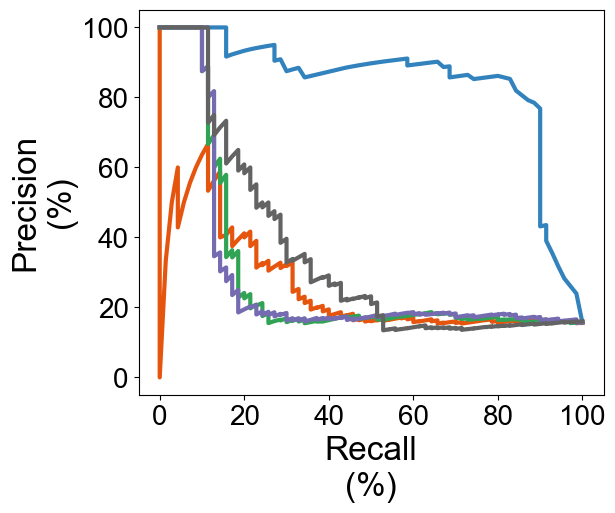

In [183]:
#spliceai concordant for exonic variants prAUC .843
#other tools range .251, .351
sp.pr_curves( ( wide.loc[ ( wide.pos >= 1123 ) & ( wide.pos <= 1272 ) ]
             [ [ 'pos', 'alt', 'ref', 'sdv', 'DS_max', 'ke_chgMEAN_abs', 'hal_chgPER_abs', 'spanr_chgZPER_abs', 'mmsplice_chgPERlogit_abs' ] ]
             .groupby( [ 'pos', 'alt', 'ref', 'sdv' ] )
             .agg( np.nanmean )
             .reset_index()
           ),
           'sdv', 
           [ 'DS_max', 'ke_chgMEAN_abs', 'hal_chgPER_abs', 'spanr_chgZPER_abs', 'mmsplice_chgPERlogit_abs' ], 
           [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ],
           fig_size = ( 6, 5 ),
           linewidth = 3,
         )

DS_max 0.66282784350811
spanr_chgZPER_abs 0.5490051843269261
Missing values in mmsplice_chgPERlogit_abs column. 256 rows removed.
mmsplice_chgPERlogit_abs 0.5847400581433566


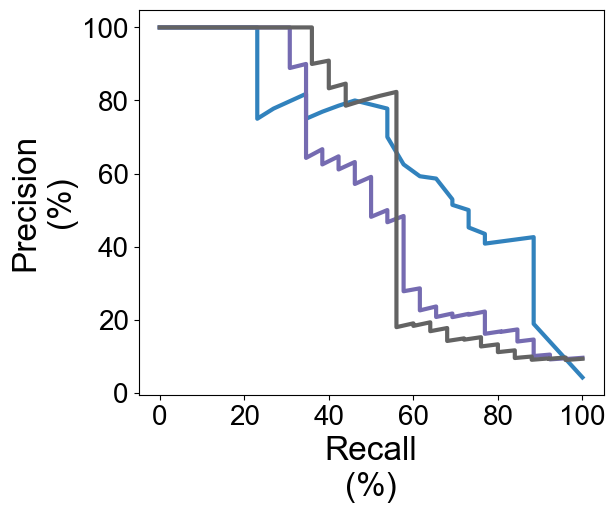

In [184]:
#spliceai concordant for exonic variants prAUC .663
#other tools range .549, .585
sp.pr_curves( ( wide.loc[ ( wide.pos < 1123 ) | ( wide.pos > 1272 ) ]
             [ [ 'pos', 'alt', 'ref', 'sdv', 'DS_max', 'ke_chgMEAN_abs', 'hal_chgPER_abs', 'spanr_chgZPER_abs', 'mmsplice_chgPERlogit_abs' ] ]
             .groupby( [ 'pos', 'alt', 'ref', 'sdv' ] )
             .agg( np.nanmean )
             .reset_index()
           ),
           'sdv', 
           [ 'DS_max', 'spanr_chgZPER_abs', 'mmsplice_chgPERlogit_abs' ], 
           [ light_colors[0], light_colors[12], light_colors[16] ],
           fig_size = ( 6, 5 ),
           linewidth = 3,
         )

In [185]:
#set spliceAI threshold as .18 
wide[ ( wide.patient_var ) ][ 'DS_max' ]

254    0.21
285    0.31
291    0.33
297    0.36
298    0.18
306    0.31
312    0.28
552    0.41
553    0.41
930    0.98
931    0.98
932    0.98
Name: DS_max, dtype: float64

In [186]:
#19 sdvs not predicted by spliceai
( wide.loc[ ( wide.sdv ) & ( wide.DS_max < .18 ) ]
  [ [ 'pos', 'alt', 'ref', 'DS_max'] ]
  .groupby( [ 'pos', 'alt', 'ref', ] )
  .agg( np.nanmean )
  .reset_index() ).shape

(19, 4)

In [187]:
#80.2% sensitivity sdvs not predicted by spliceai
( wide.loc[ ( wide.sdv ) & ( wide.DS_max >= .18 ) ]
  [ [ 'pos', 'alt', 'ref', 'DS_max'] ]
  .groupby( [ 'pos', 'alt', 'ref', ] )
  .agg( np.nanmean )
  .reset_index() ).shape[ 0 ] \
/ ( wide.loc[ ( wide.sdv ) ]
  [ [ 'pos', 'alt', 'ref', 'DS_max'] ]
  .groupby( [ 'pos', 'alt', 'ref', ] )
  .agg( np.nanmean )
  .reset_index() ).shape[ 0 ]

0.8020833333333334

In [188]:
#26 variants predicted by spliceai but neutral in our screen
( wide.loc[ ( wide.sdv == False ) & ( wide.DS_max >= .18 ) ]
  [ [ 'pos', 'alt', 'ref', 'DS_max'] ]
  .groupby( [ 'pos', 'alt', 'ref', ] )
  .agg( np.nanmean )
  .reset_index() ).shape

(26, 4)

In [189]:
#97.3% specificity sdvs not predicted by spliceai
( wide.loc[ ( wide.sdv == False ) & ( wide.DS_max < .18 ) ]
  [ [ 'pos', 'alt', 'ref', 'DS_max'] ]
  .groupby( [ 'pos', 'alt', 'ref', ] )
  .agg( np.nanmean )
  .reset_index() ).shape[ 0 ] \
/ ( wide.loc[ ( wide.sdv == False ) ]
  [ [ 'pos', 'alt', 'ref', 'DS_max'] ]
  .groupby( [ 'pos', 'alt', 'ref', ] )
  .agg( np.nanmean )
  .reset_index() ).shape[ 0 ]

0.973305954825462

Discussion

In [190]:
#96 sdvs
( wide.loc[ ( wide.sdv )  ]
  [ [ 'pos', 'alt', 'ref', 'DS_max'] ]
  .groupby( [ 'pos', 'alt', 'ref', ] )
  .agg( np.nanmean )
  .reset_index() ).shape

(96, 4)

In [191]:
#36 intermediate
( wide.loc[ ( wide.intmed )  ]
  [ [ 'pos', 'alt', 'ref', 'DS_max'] ]
  .groupby( [ 'pos', 'alt', 'ref', ] )
  .agg( np.nanmean )
  .reset_index() ).shape

(36, 4)

In [192]:
#14 synonymous sdvs/intmed
( wide.loc[ ( wide.intmed_sdv ) & ( wide.var_type == 'Synonymous' ) ]
  [ [ 'pos', 'alt', 'ref', 'DS_max'] ]
  .groupby( [ 'pos', 'alt', 'ref', ] )
  .agg( np.nanmean )
  .reset_index() ).shape

(26, 4)

Figure 3A

In [193]:
#96 sdvs
( wide.loc[ ( wide.sdv )  ]
  [ [ 'pos', 'alt', 'ref', 'DS_max'] ]
  .groupby( [ 'pos', 'alt', 'ref', ] )
  .agg( np.nanmean )
  .reset_index() ).shape

(96, 4)

In [194]:
#36 intermediate
( wide.loc[ ( wide.intmed )  ]
  [ [ 'pos', 'alt', 'ref', 'DS_max'] ]
  .groupby( [ 'pos', 'alt', 'ref', ] )
  .agg( np.nanmean )
  .reset_index() ).shape

(36, 4)

In [195]:
#938 neutral
( wide.loc[ ~( wide.intmed_sdv )  ]
  [ [ 'pos', 'alt', 'ref', 'DS_max'] ]
  .groupby( [ 'pos', 'alt', 'ref', ] )
  .agg( np.nanmean )
  .reset_index() ).shape

(938, 4)

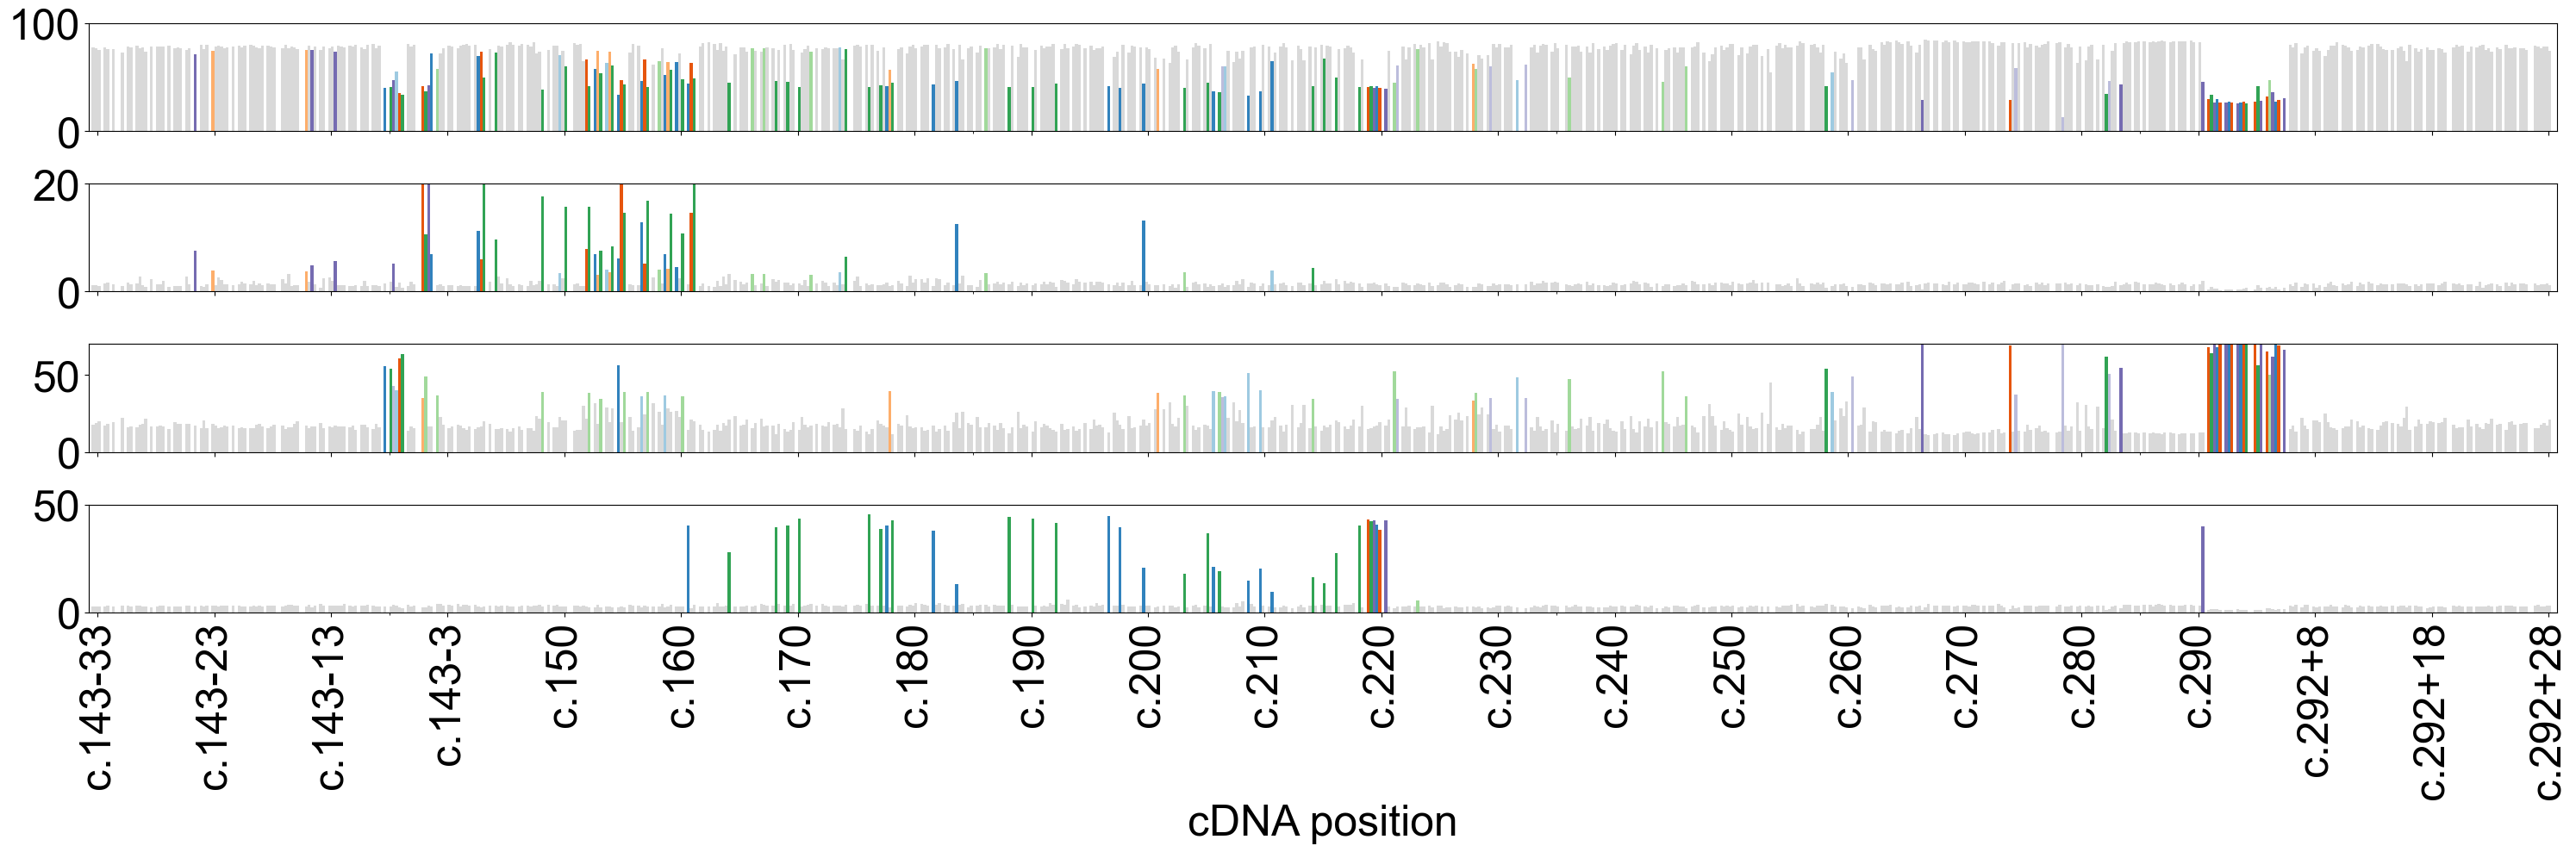

In [196]:
sp.subplots_wrapper( ( wide[ [ 'pos', 'alt', 'ref', 'hgvs_pos', 'sdv', 'sdv_BETA', 'sdv_SKIP', 'sdv_OTHER',
                               'intmed', 'intmed_BETA', 'intmed_SKIP', 'intmed_OTHER',
                               'wmean_ALPHA', 'wmean_BETA', 'wmean_SKIP', 'wmean_OTHER' ] ]
                   .groupby( [ 'pos', 'alt', 'ref', 'hgvs_pos', 'sdv', 'intmed' ] )
                   .agg( np.nanmean )
                   .reset_index() ),
                  [ 'wmean_ALPHA', 'wmean_BETA', 'wmean_SKIP', 'wmean_OTHER' ],
                 'hgvs_pos',
                  [ '.85', '.85', '.85', '.85', '.85' ],
                  zoom = ( 1090, 1300 ),
                  share_y = False,
                  legend = False,
                  y_ax_lim = [ ( 0, 100 ), ( 0, 20 ), ( 0, 70 ), ( 0, 50 ) ],
                  y_ax_title = [ '','', '', '' ],
                  x_ax_title = 'cDNA position',
                  darken_bars = [ ( 'sdv', [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                  ( 'sdv_BETA', [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                  ( 'sdv_SKIP', [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                  ( 'sdv_OTHER', [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                ],
                  darken_bars2 = [ ( 'intmed', [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                   ( 'intmed_BETA', [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                   ( 'intmed_SKIP', [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                   ( 'intmed_OTHER', [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ) ],
                  savefile = plot_out + 'full_shaded2col_per.pdf',
                     )

Figure 3B

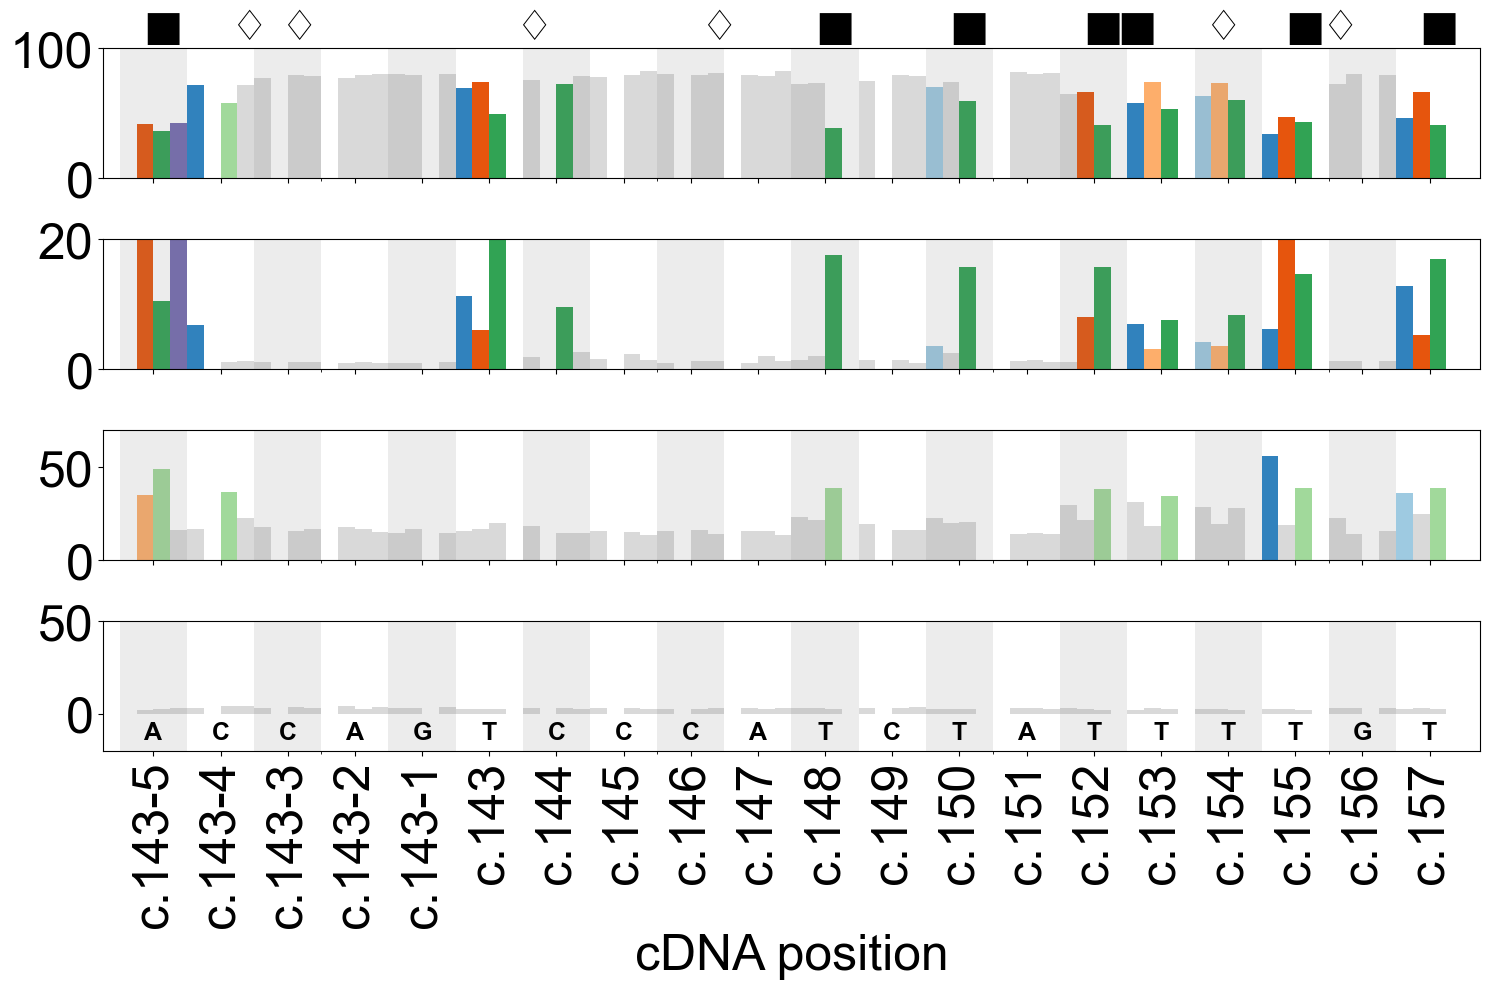

In [197]:
sp.subplots_wrapper( ( wide[ [ 'pos', 'alt', 'ref', 'hgvs_pos', 'sdv', 'sdv_BETA', 'sdv_SKIP', 'sdv_OTHER',
                               'intmed', 'intmed_BETA', 'intmed_SKIP', 'intmed_OTHER', 'patient_var',
                               'wmean_ALPHA', 'wmean_BETA', 'wmean_SKIP', 'wmean_OTHER', 'gnomad_var', ] ]
                   .groupby( [ 'pos', 'alt', 'ref', 'hgvs_pos', 'sdv', 'intmed' ] )
                   .agg( np.nanmean )
                   .reset_index() ),
                  [ 'wmean_ALPHA', 'wmean_BETA', 'wmean_SKIP', 'wmean_OTHER' ],
                 'hgvs_pos',
                  [ '.85', '.85', '.85', '.85', '.85' ],
                  fig_size = ( 15, 10 ),
                  zoom = ( 1118, 1137 ),
                  share_y = False,
                  legend = False,
                  y_ax_lim = [ ( 0, 100 ), ( 0, 20 ), ( 0, 70 ), ( 0, 50 ) ],
                  y_ax_title = [ '','', '', '' ],
                  x_ax_title = 'cDNA position',
                  darken_bars = [ ( 'sdv', [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                  ( 'sdv_BETA', [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                  ( 'sdv_SKIP', [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                  ( 'sdv_OTHER', [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                ],
                  darken_bars2 = [ ( 'intmed', [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                   ( 'intmed_BETA', [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                   ( 'intmed_SKIP', [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                   ( 'intmed_OTHER', [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ) ],
                  tick_spacing = 1,
                  wt_labels = True,
                  bar_labels = [ ( 'gnomad_var', r'$\diamondsuit$', 'gnomAD variant', 30 ) ,
                                 ( 'patient_var', r'$\blacksquare$', 'Patient variant', 30 ),
                                  ],
                  bar_label_loc = 'above',
                  bar_labels_offset = False,
                  shade_by_base = True,
                  savefile = plot_out + 'acceptor_shaded2col_per.pdf',
                     )

Supp Figure 2

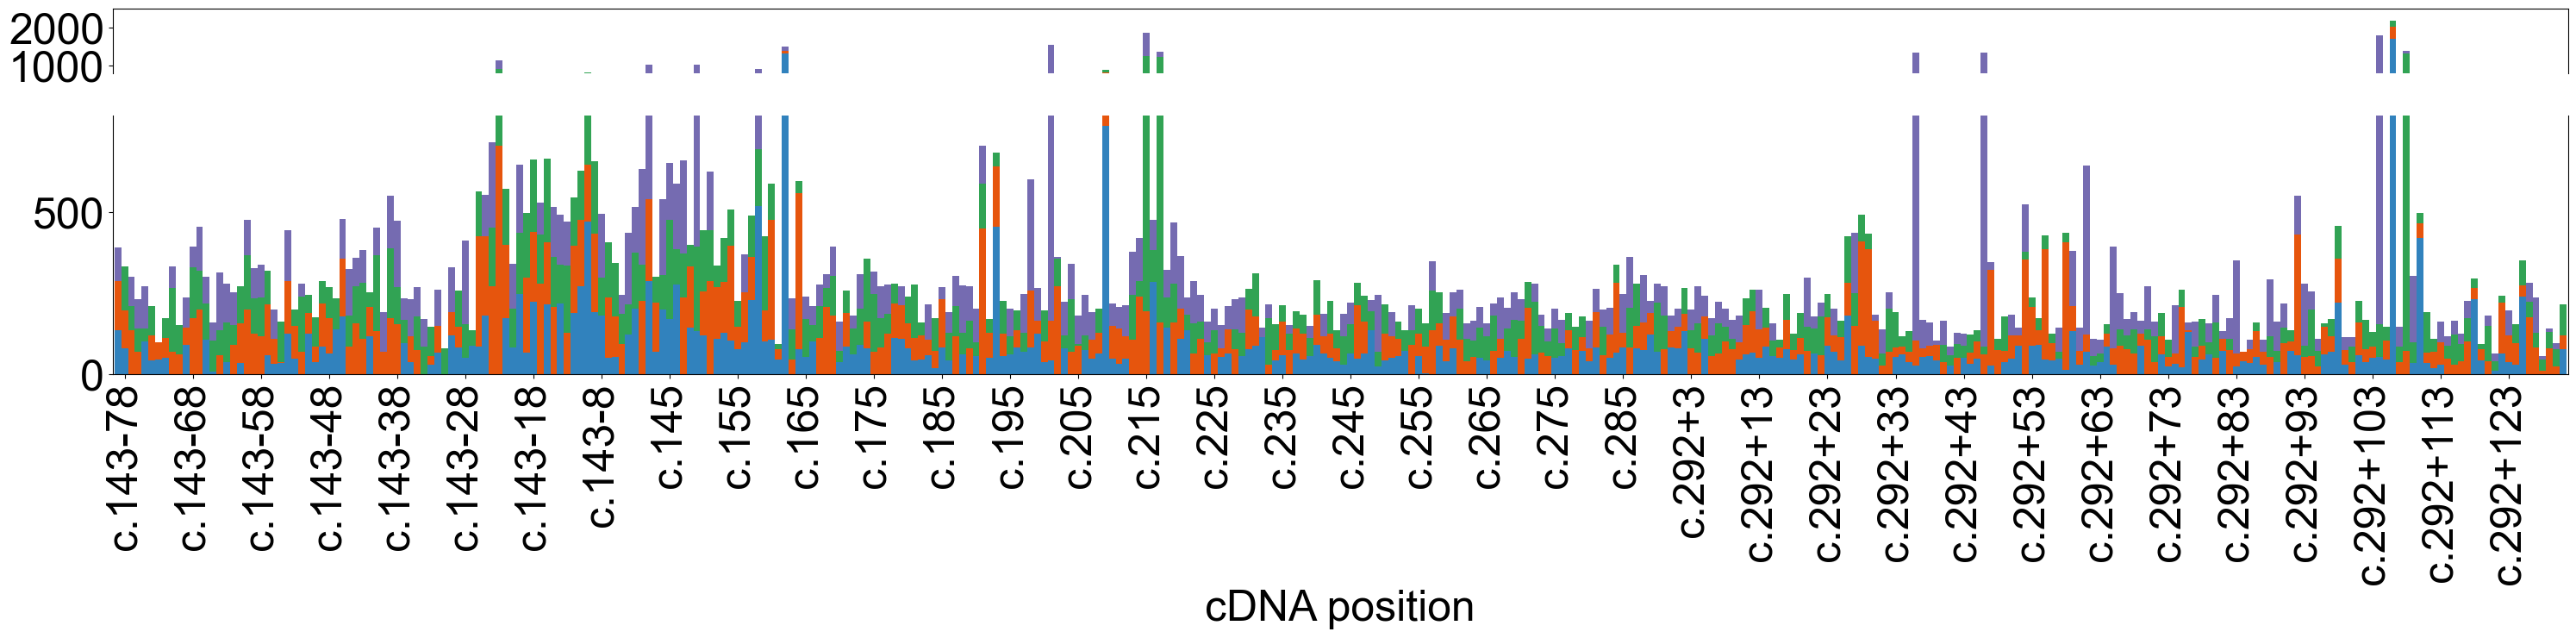

In [198]:
sp.split_ax_bcs(  wide[ [ 'pos', 'ref', 'alt', 'n_bc_passfilt', 'hgvs_pos' ] ].groupby( [ 'pos', 'ref', 'alt','hgvs_pos' ] ).agg( np.nanmean ).fillna(0).reset_index(),
                  [ 'n_bc_passfilt' ],
                  'hgvs_pos',
                    [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ],
                    [ ( 800.5, 2500 ), ( 0, 800 ) ],
                    fig_size = ( 30, 7.5 ),
                    legend = False,
                    hratios = [ 1, 4 ],
                    x_ax_title = 'cDNA position',
                    #tight = False,
                    savefile = plot_out + 'bcs_filt_by_pos_split.pdf'
                           )

Supp Figure 3

In [199]:
#median beta correlation is .92
( wide[ [ 'pos', 'ref', 'alt' ] + [ col for col in wide.columns if '_wmean_BETA' in col ] ]
  .groupby( [ 'pos', 'ref', 'alt' ] )
  .agg( np.nanmean )
  .reset_index()[ [ col for col in wide.columns if '_wmean_BETA' in col ] ]
  .corr( method = 'pearson' )
  .median()
  .median() )

0.9198846757072103

In [200]:
#max beta correlation is .96
( wide[ [ 'pos', 'ref', 'alt' ] + [ col for col in wide.columns if '_wmean_BETA' in col ] ]
  .groupby( [ 'pos', 'ref', 'alt' ] )
  .agg( np.nanmean )
  .reset_index()[ [ col for col in wide.columns if '_wmean_BETA' in col ] ]
  .corr( method = 'pearson' )
  .stack()
  .sort_values()[-15] )

0.9569935439841935

In [201]:
#min beta correlation is .77
( wide[ [ 'pos', 'ref', 'alt' ] + [ col for col in wide.columns if '_wmean_BETA' in col ] ]
  .groupby( [ 'pos', 'ref', 'alt' ] )
  .agg( np.nanmean )
  .reset_index()[ [ col for col in wide.columns if '_wmean_BETA' in col ] ]
  .corr( method = 'pearson' )
  .min()
  .min() )

0.7712245442558694

In [202]:
sns.set_theme( font_scale = 3 )

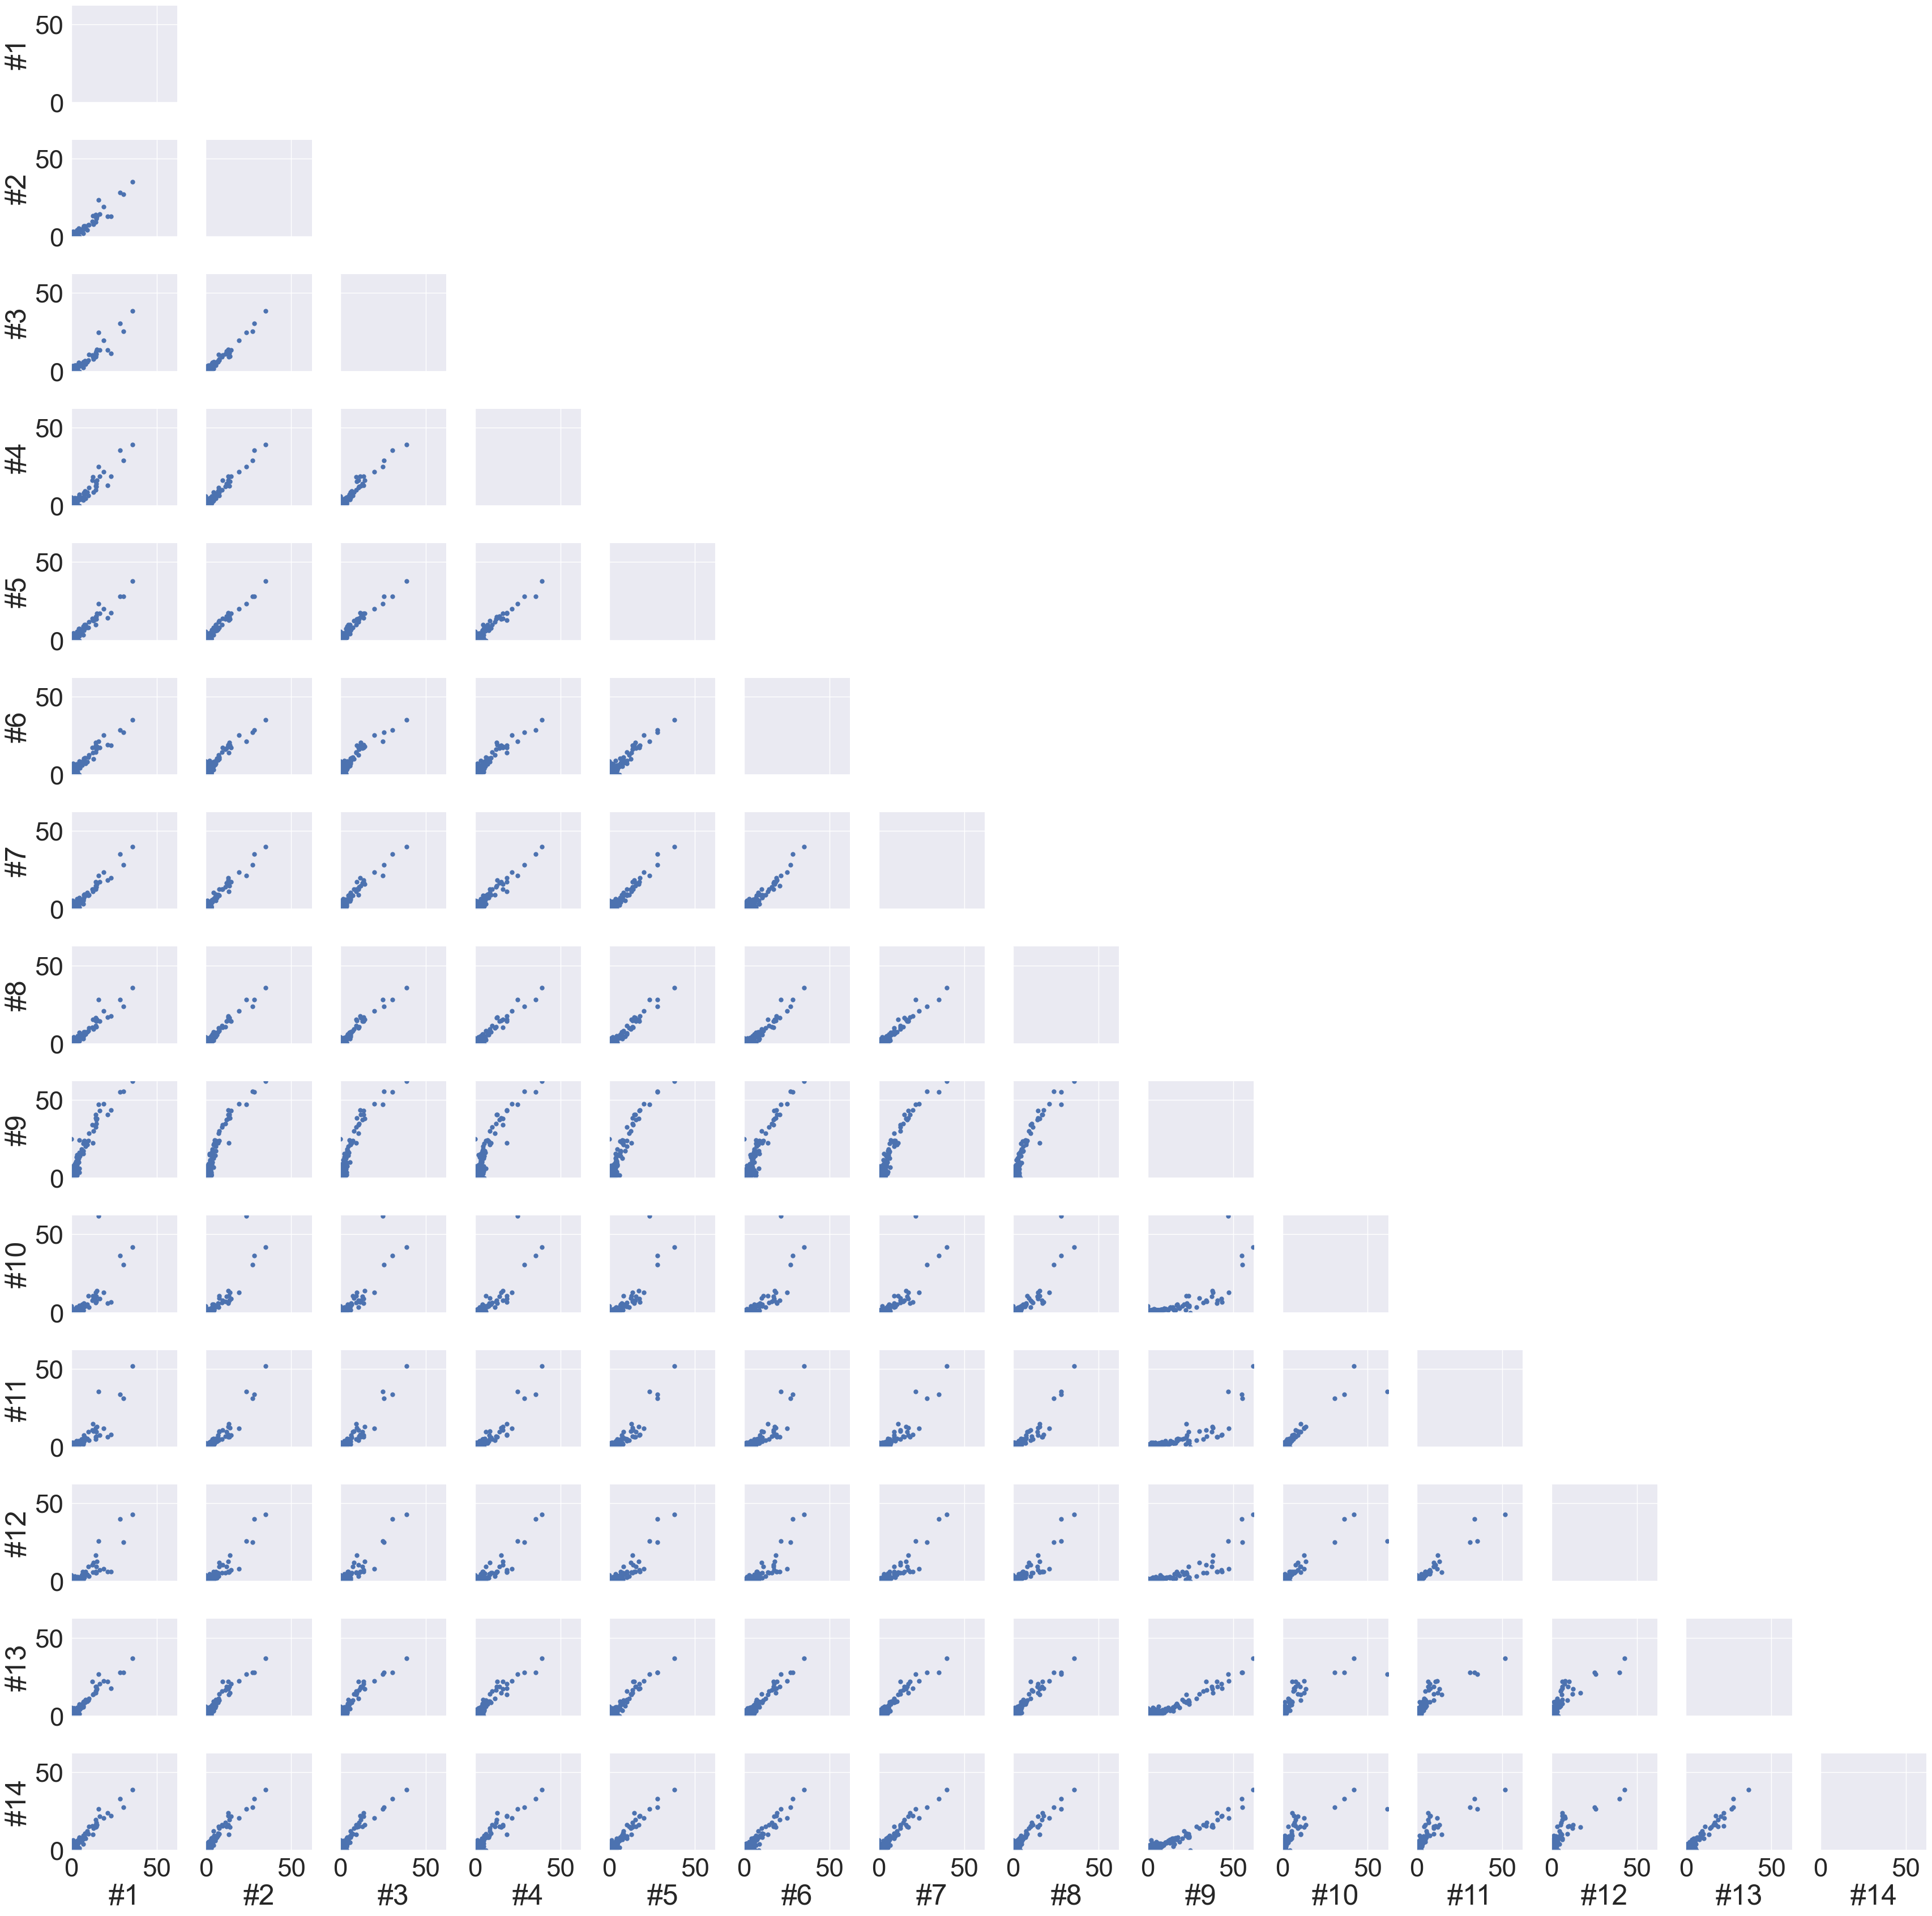

In [203]:
#sns.set_palette( palette = light_colors )
g = sns.PairGrid( wide[ [ 'pos', 'ref', 'alt' ] + [ col for col in wide.columns if '_wmean_BETA' in col ] ].groupby( [ 'pos', 'ref', 'alt' ] ).agg( np.nanmean ).reset_index()[ [ col for col in wide.columns if '_wmean_BETA' in col ] ].apply( lambda x: x*100 ),
                    corner = True,
                  palette = light_colors
                  )
#g.map_diag( sns.histplot, binwidth = 2 )
g.map_offdiag( sns.scatterplot, rasterized = True, linewidth = 0 )
g.set( ylim = ( 0, 62 ), 
         xlim = ( 0, 62 ),
       )
labels = [ '#' + str( i ) for i in range( 1, 15 ) ]

for i, ax in enumerate( g.axes.flat ):
    if i % len( labels ) == 0:
        ax.set_ylabel( labels[ int( i / len( labels ) ) ] )
    if i >= ( len( labels )*( len( labels ) - 1 )  ):
        ax.set_xlabel( labels[ int( i - ( len( labels )*( len( labels ) - 1 )  ) ) ] )
        
g.savefig( plot_out + 'beta_corr.pdf' )
        

In [204]:
#median skip correlation .95
( wide[ [ 'pos', 'ref', 'alt' ] + [ col for col in wide.columns if '_wmean_SKIP' in col ] ]
  .groupby( [ 'pos', 'ref', 'alt' ] )
  .agg( np.nanmean )
  .reset_index()
  [ [ col for col in wide.columns if '_wmean_SKIP' in col ] ]
  .corr( method = 'pearson' )
  .median()
  .median()
)

0.9536371747946637

In [205]:
#min skip correlation .83
( wide[ [ 'pos', 'ref', 'alt' ] + [ col for col in wide.columns if '_wmean_SKIP' in col ] ]
 .groupby( [ 'pos', 'ref', 'alt' ] )
 .agg( np.nanmean ).reset_index()[ [ col for col in wide.columns if '_wmean_SKIP' in col ] ]
 .corr( method = 'pearson' )
 .min()
 .min() )

0.8278799076691707

In [206]:
#max skip correlation .98
( wide[ [ 'pos', 'ref', 'alt' ] + [ col for col in wide.columns if '_wmean_SKIP' in col ] ]
 .groupby( [ 'pos', 'ref', 'alt' ] )
 .agg( np.nanmean ).reset_index()[ [ col for col in wide.columns if '_wmean_SKIP' in col ] ]
 .corr( method = 'pearson' )
 .stack()
 .sort_values()[-15] )

0.9842228571052064

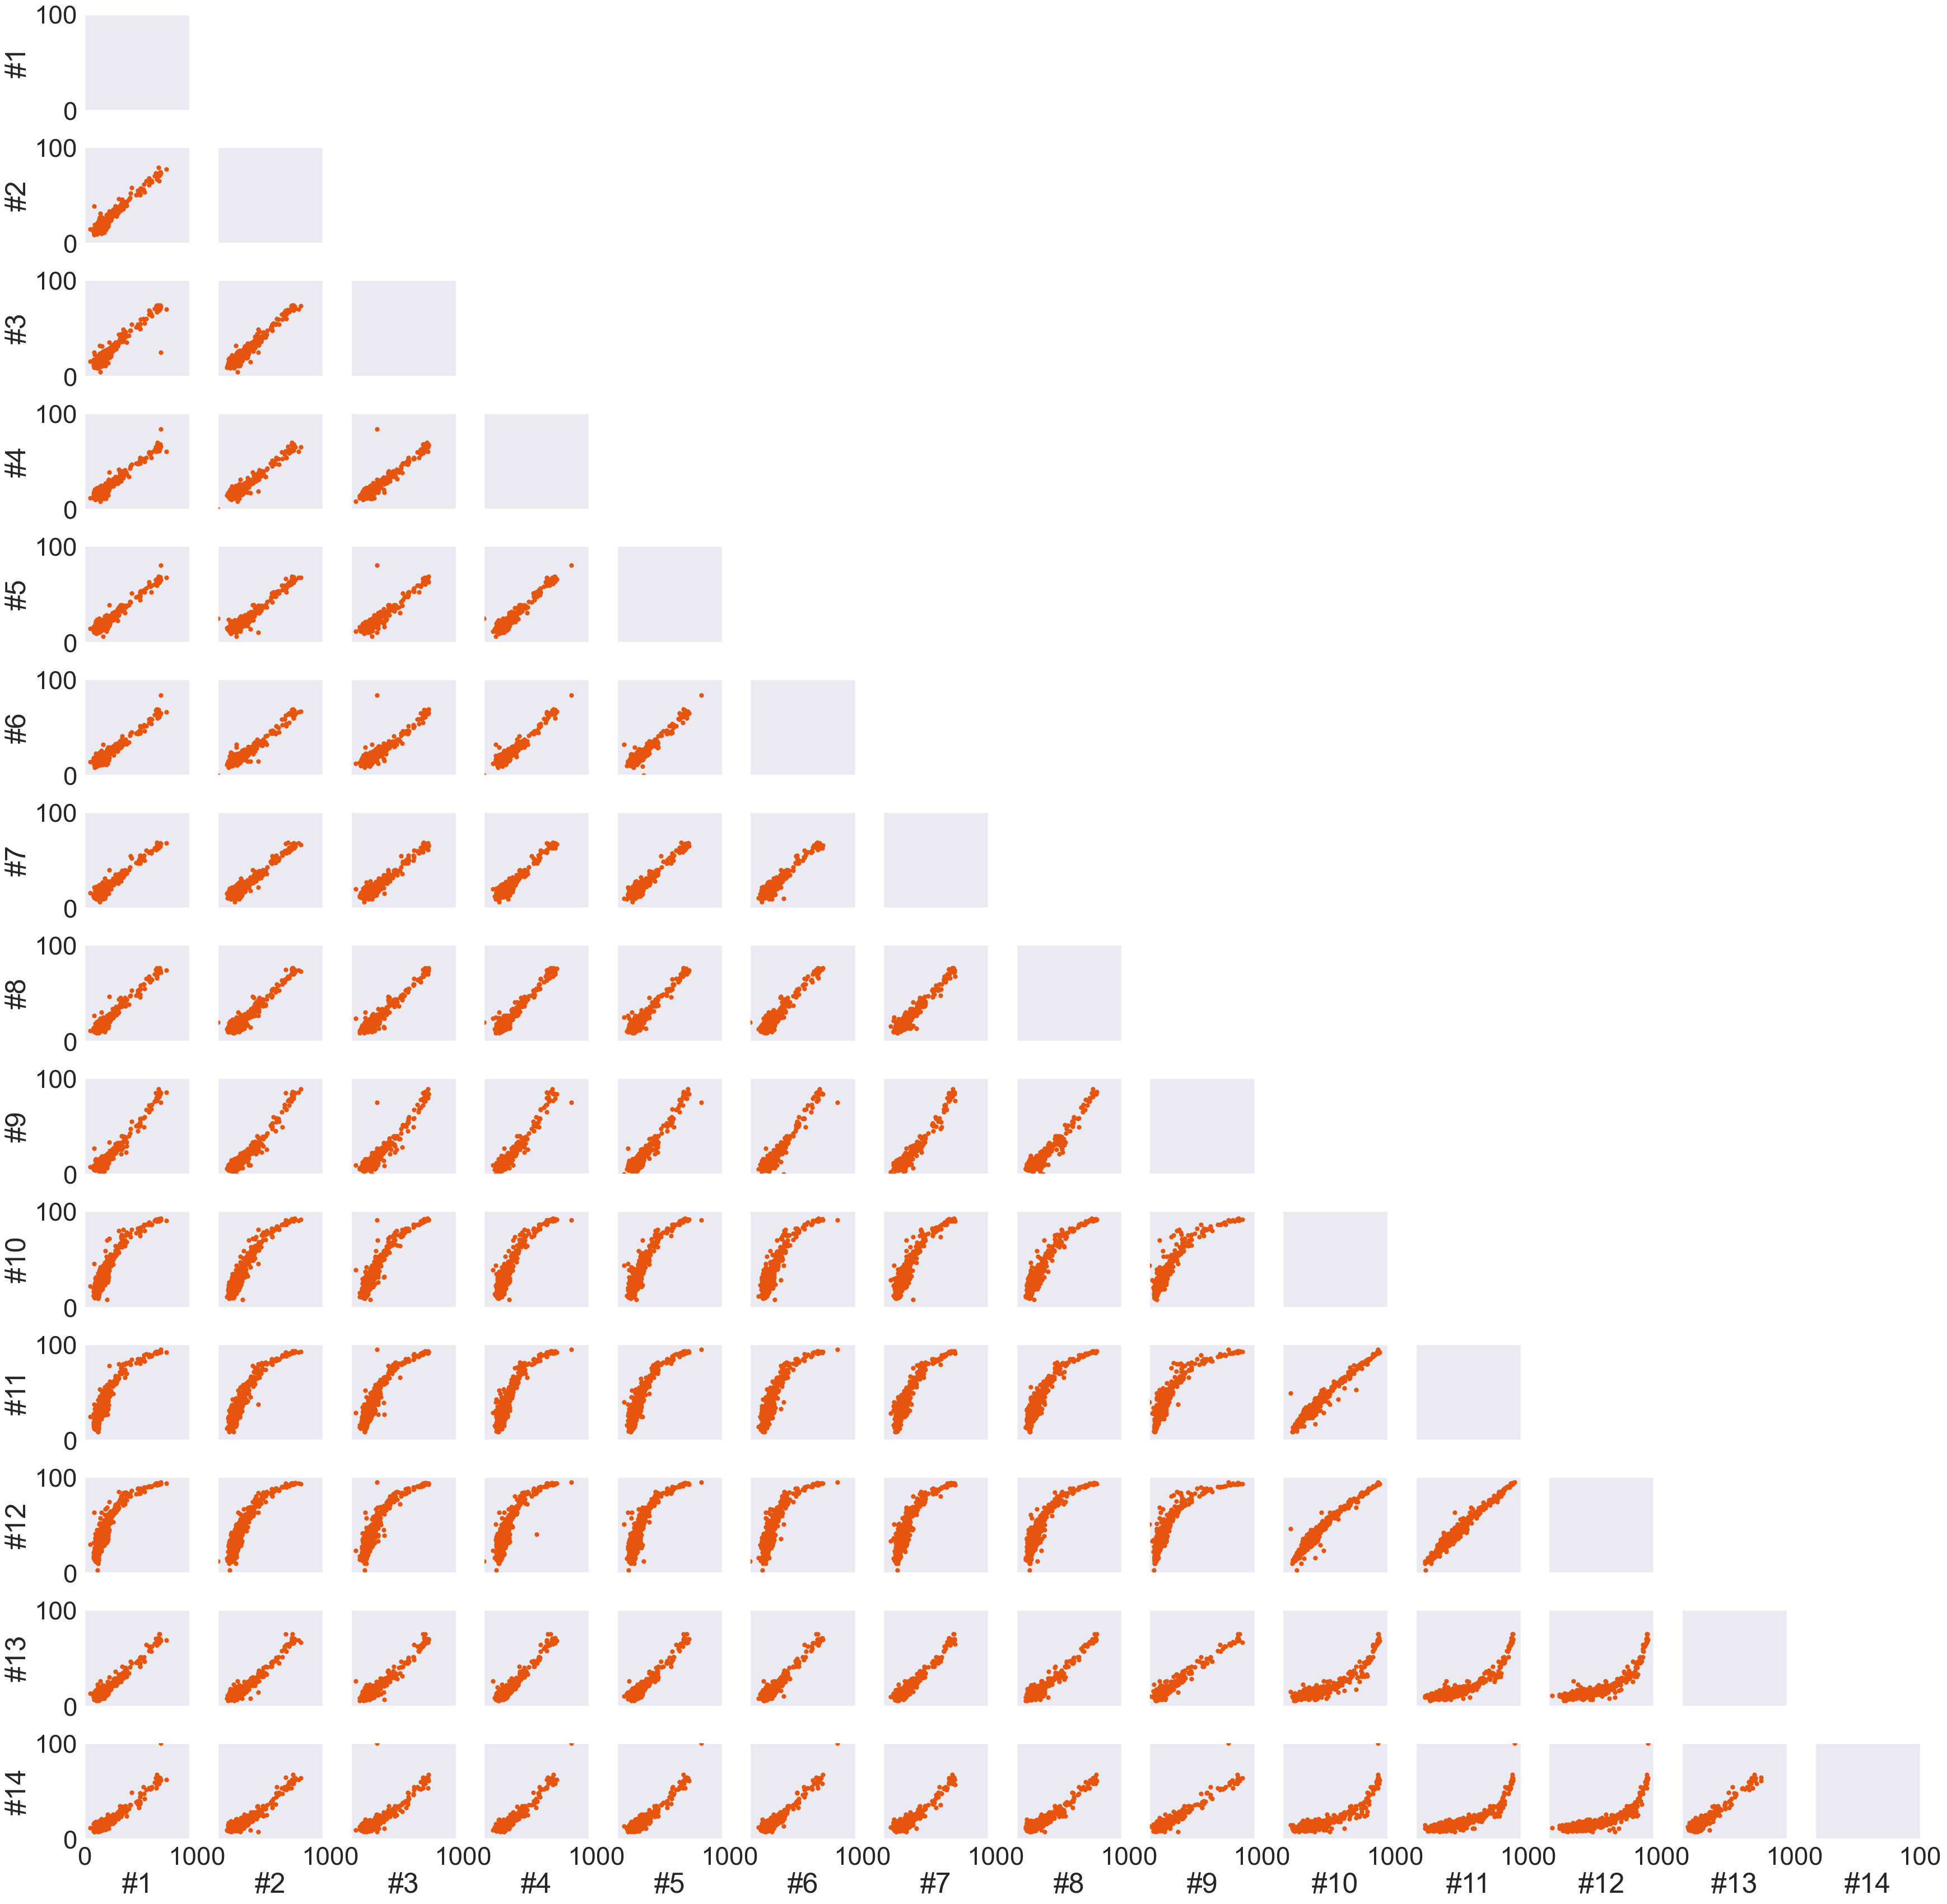

In [207]:
sns.set_palette( palette = light_colors[4:] )
g = sns.PairGrid( wide[ [ 'pos', 'ref', 'alt' ] + [ col for col in wide.columns if '_wmean_SKIP' in col ] ].groupby( [ 'pos', 'ref', 'alt' ] ).agg( np.nanmean ).reset_index()[ [ col for col in wide.columns if '_wmean_SKIP' in col ] ].apply( lambda x: x*100 ),
                    corner = True,
                  )
#g.map_diag( sns.histplot, binwidth = 2 )
g.map_offdiag( sns.scatterplot, rasterized = True, linewidth = 0 )
g.set( ylim = ( 0, 100 ), xlim = ( 0, 100 ) )
labels = [ '#' + str( i ) for i in range( 1, 15 ) ]

for i, ax in enumerate( g.axes.flat ):
    if i % len( labels ) == 0:
        ax.set_ylabel( labels[ int( i / len( labels ) ) ] )
    if i >= ( len( labels )*( len( labels ) - 1 )  ):
        ax.set_xlabel( labels[ int( i - ( len( labels )*( len( labels ) - 1 )  ) ) ] )

g.savefig( plot_out + 'skip_corr.pdf' )        

In [208]:
#median other correlation .96
( wide[ [ 'pos', 'ref', 'alt' ] + [ col for col in wide.columns if '_wmean_OTHER' in col ] ]
  .groupby( [ 'pos', 'ref', 'alt' ] )
  .agg( np.nanmean )
  .reset_index()
  [ [ col for col in wide.columns if '_wmean_OTHER' in col ] ]
  .corr( method = 'pearson' )
  .median()
  .median()
)

0.9633921922107356

In [209]:
#min other correlation .91
( wide[ [ 'pos', 'ref', 'alt' ] + [ col for col in wide.columns if '_wmean_OTHER' in col ] ]
 .groupby( [ 'pos', 'ref', 'alt' ] )
 .agg( np.nanmean ).reset_index()[ [ col for col in wide.columns if '_wmean_OTHER' in col ] ]
 .corr( method = 'pearson' )
 .min()
 .min() )

0.9119674728942986

In [210]:
#max other correlation .99
( wide[ [ 'pos', 'ref', 'alt' ] + [ col for col in wide.columns if '_wmean_OTHER' in col ] ]
 .groupby( [ 'pos', 'ref', 'alt' ] )
 .agg( np.nanmean ).reset_index()[ [ col for col in wide.columns if '_wmean_OTHER' in col ] ]
 .corr( method = 'pearson' )
 .stack()
 .sort_values()[-15] )

0.9854535924908464

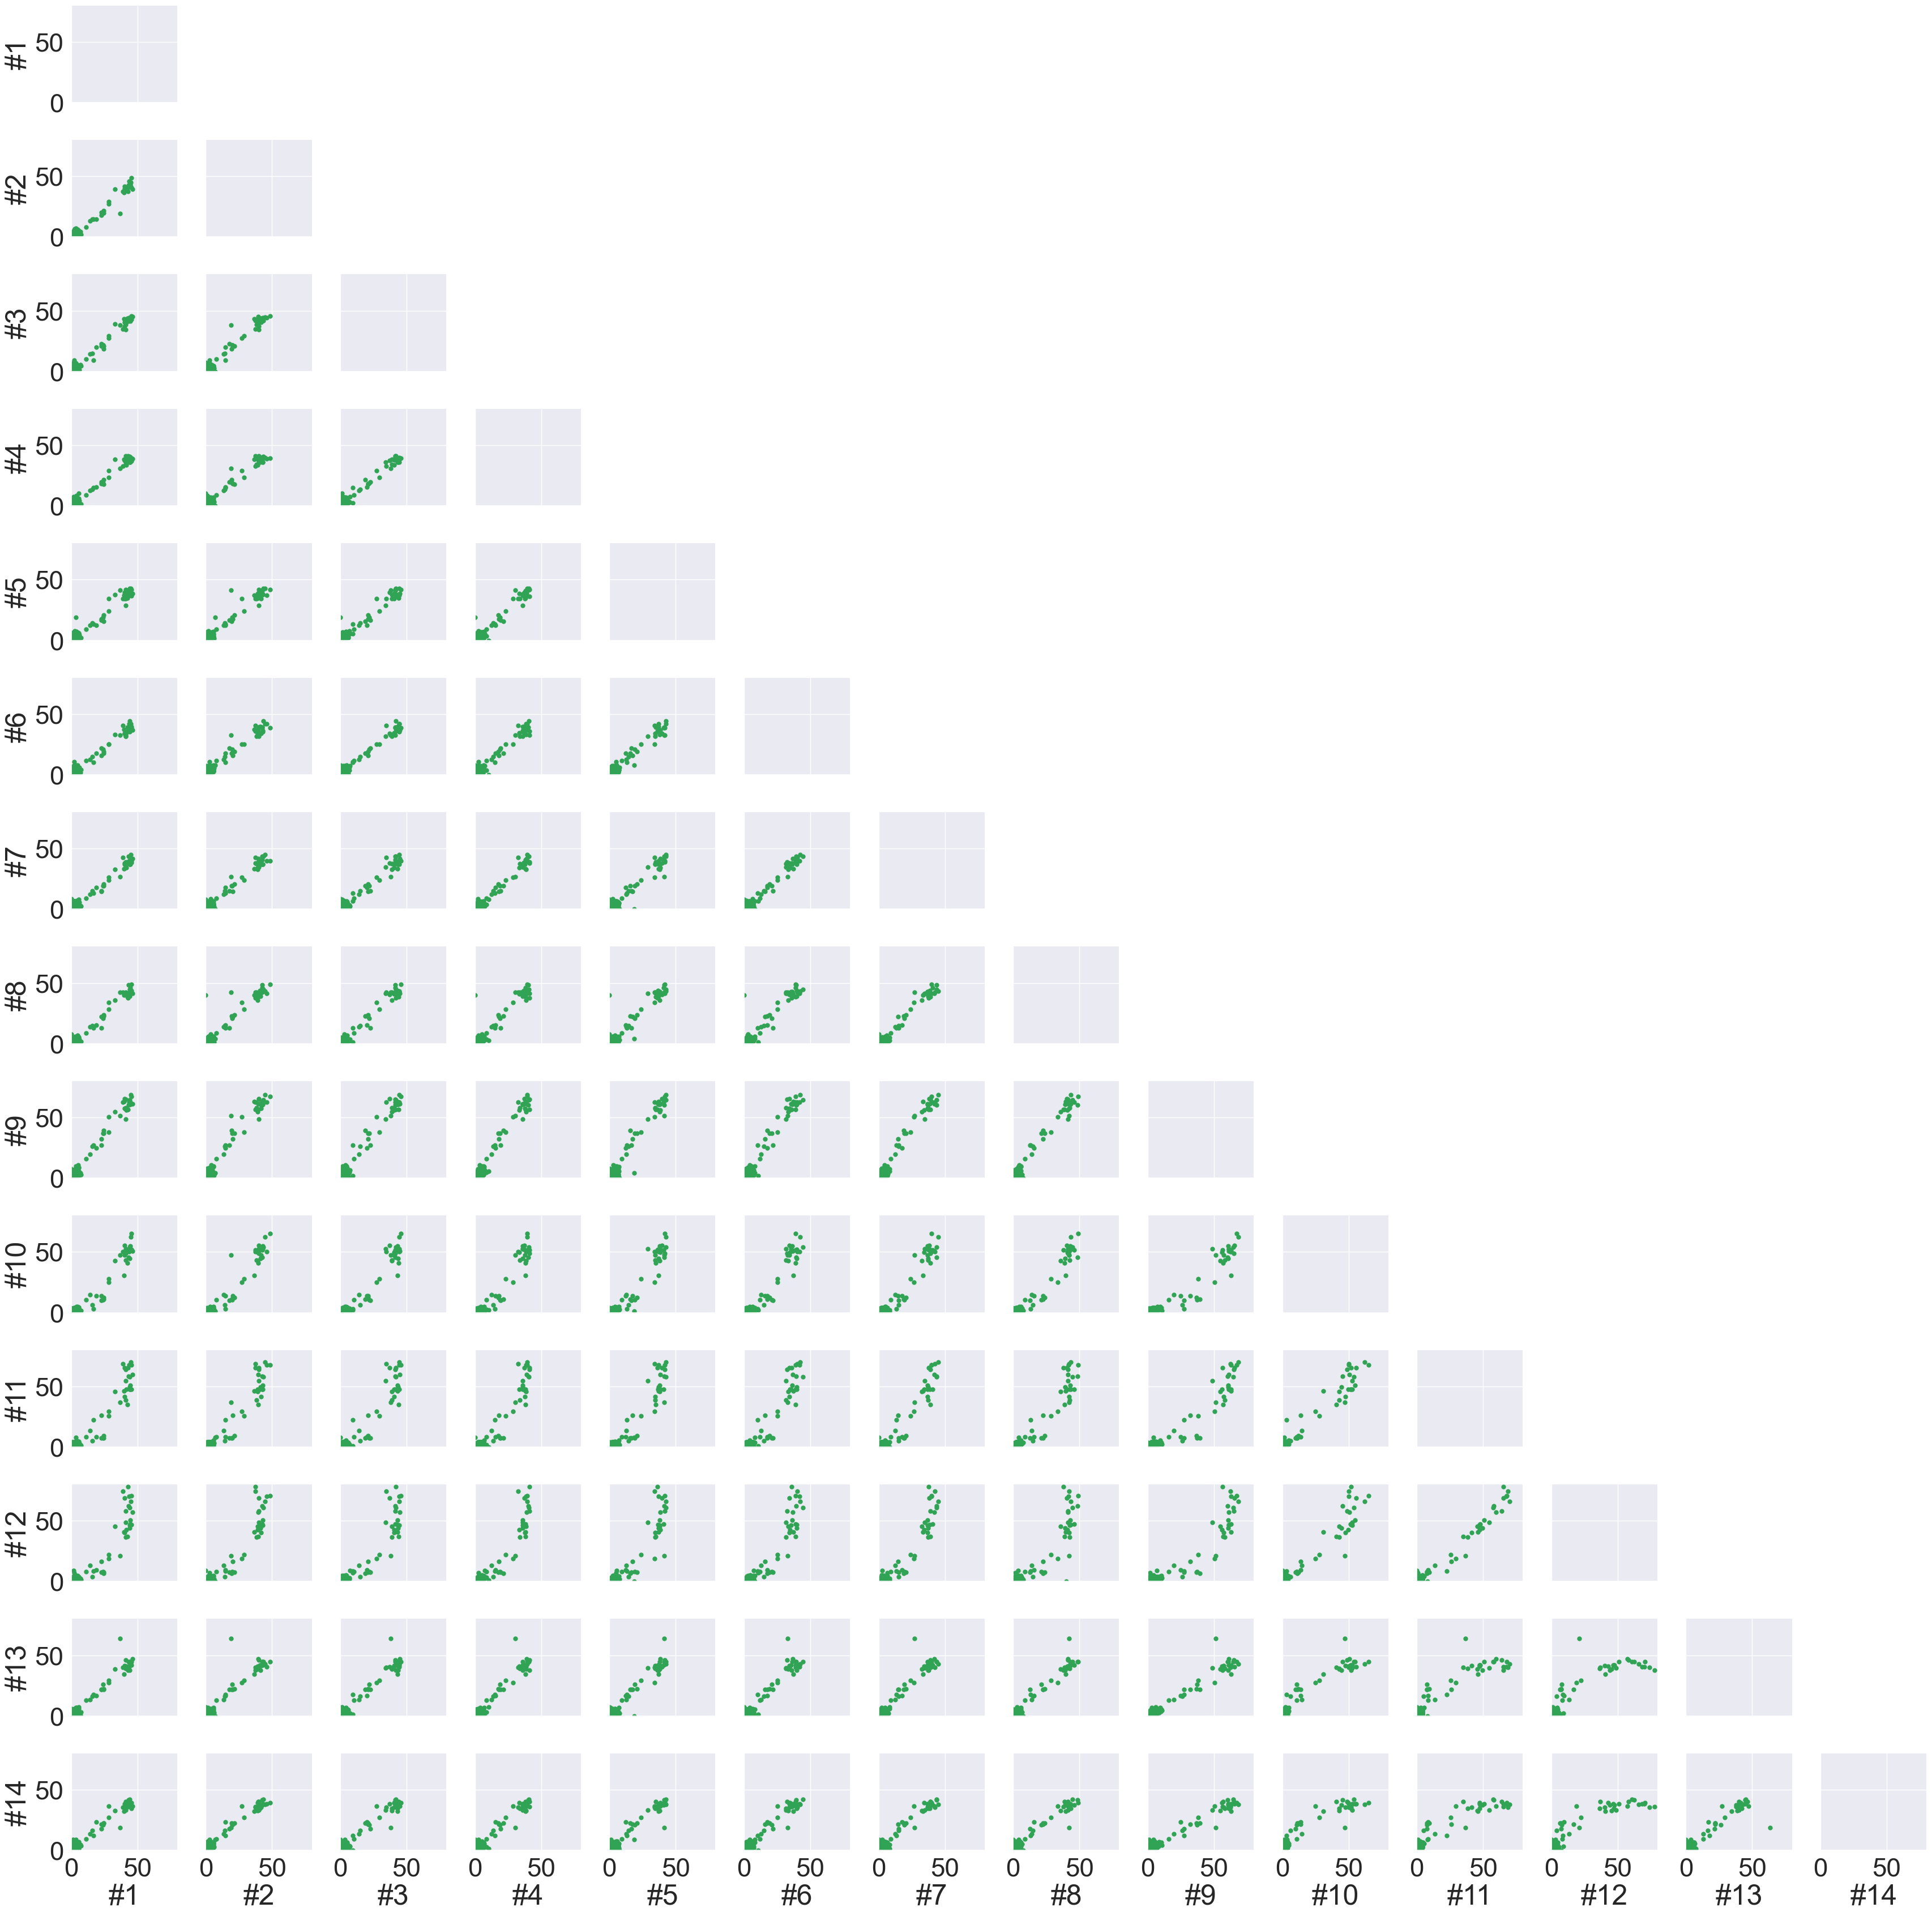

In [211]:
sns.set_palette( palette = light_colors[8:] )
g = sns.PairGrid( wide[ [ 'pos', 'ref', 'alt' ] + [ col for col in wide.columns if '_wmean_OTHER' in col ] ].groupby( [ 'pos', 'ref', 'alt' ] ).agg( np.nanmean ).reset_index()[ [ col for col in wide.columns if '_wmean_OTHER' in col ] ].apply( lambda x: x*100 ),
                    corner = True,
                  )
#g.map_diag( sns.histplot, binwidth = 2 )
g.map_offdiag( sns.scatterplot, rasterized = True, linewidth = 0 )
g.set( ylim = ( 0, 80 ), xlim = ( 0, 80 ) )
labels = [ '#' + str( i ) for i in range( 1, 15 ) ]

for i, ax in enumerate( g.axes.flat ):
    if i % len( labels ) == 0:
        ax.set_ylabel( labels[ int( i / len( labels ) ) ] )
    if i >= ( len( labels )*( len( labels ) - 1 )  ):
        ax.set_xlabel( labels[ int( i - ( len( labels )*( len( labels ) - 1 )  ) ) ] )

g.savefig( plot_out + 'other_corr.pdf' )  

In [212]:
#median alpha correlation .96
( wide[ [ 'pos', 'ref', 'alt' ] + [ col for col in wide.columns if '_wmean_ALPHA' in col and '_inv' not in col ] ]
  .groupby( [ 'pos', 'ref', 'alt' ] )
  .agg( np.nanmean )
  .reset_index()
  [ [ col for col in wide.columns if '_wmean_ALPHA' in col and '_inv' not in col ] ]
  .corr( method = 'pearson' )
  .median()
  .median()
)

0.9557076658316233

In [213]:
#min alpha correlation .88
( wide[ [ 'pos', 'ref', 'alt' ] + [ col for col in wide.columns if '_wmean_ALPHA' in col and '_inv' not in col ] ]
 .groupby( [ 'pos', 'ref', 'alt' ] )
 .agg( np.nanmean )
 .reset_index()[ [ col for col in wide.columns if '_wmean_ALPHA' in col and '_inv' not in col ] ]
 .corr( method = 'pearson' )
 .min()
 .min()
)

0.8799064346225229

In [214]:
#max alpha correlation .99
( wide[ [ 'pos', 'ref', 'alt' ] + [ col for col in wide.columns if '_wmean_ALPHA' in col and '_inv' not in col ] ]
 .groupby( [ 'pos', 'ref', 'alt' ] )
 .agg( np.nanmean )
 .reset_index()[ [ col for col in wide.columns if '_wmean_ALPHA' in col and '_inv' not in col ] ]
 .corr( method = 'pearson' )
 .stack()
 .sort_values()[-15]
)

0.9871458627881314

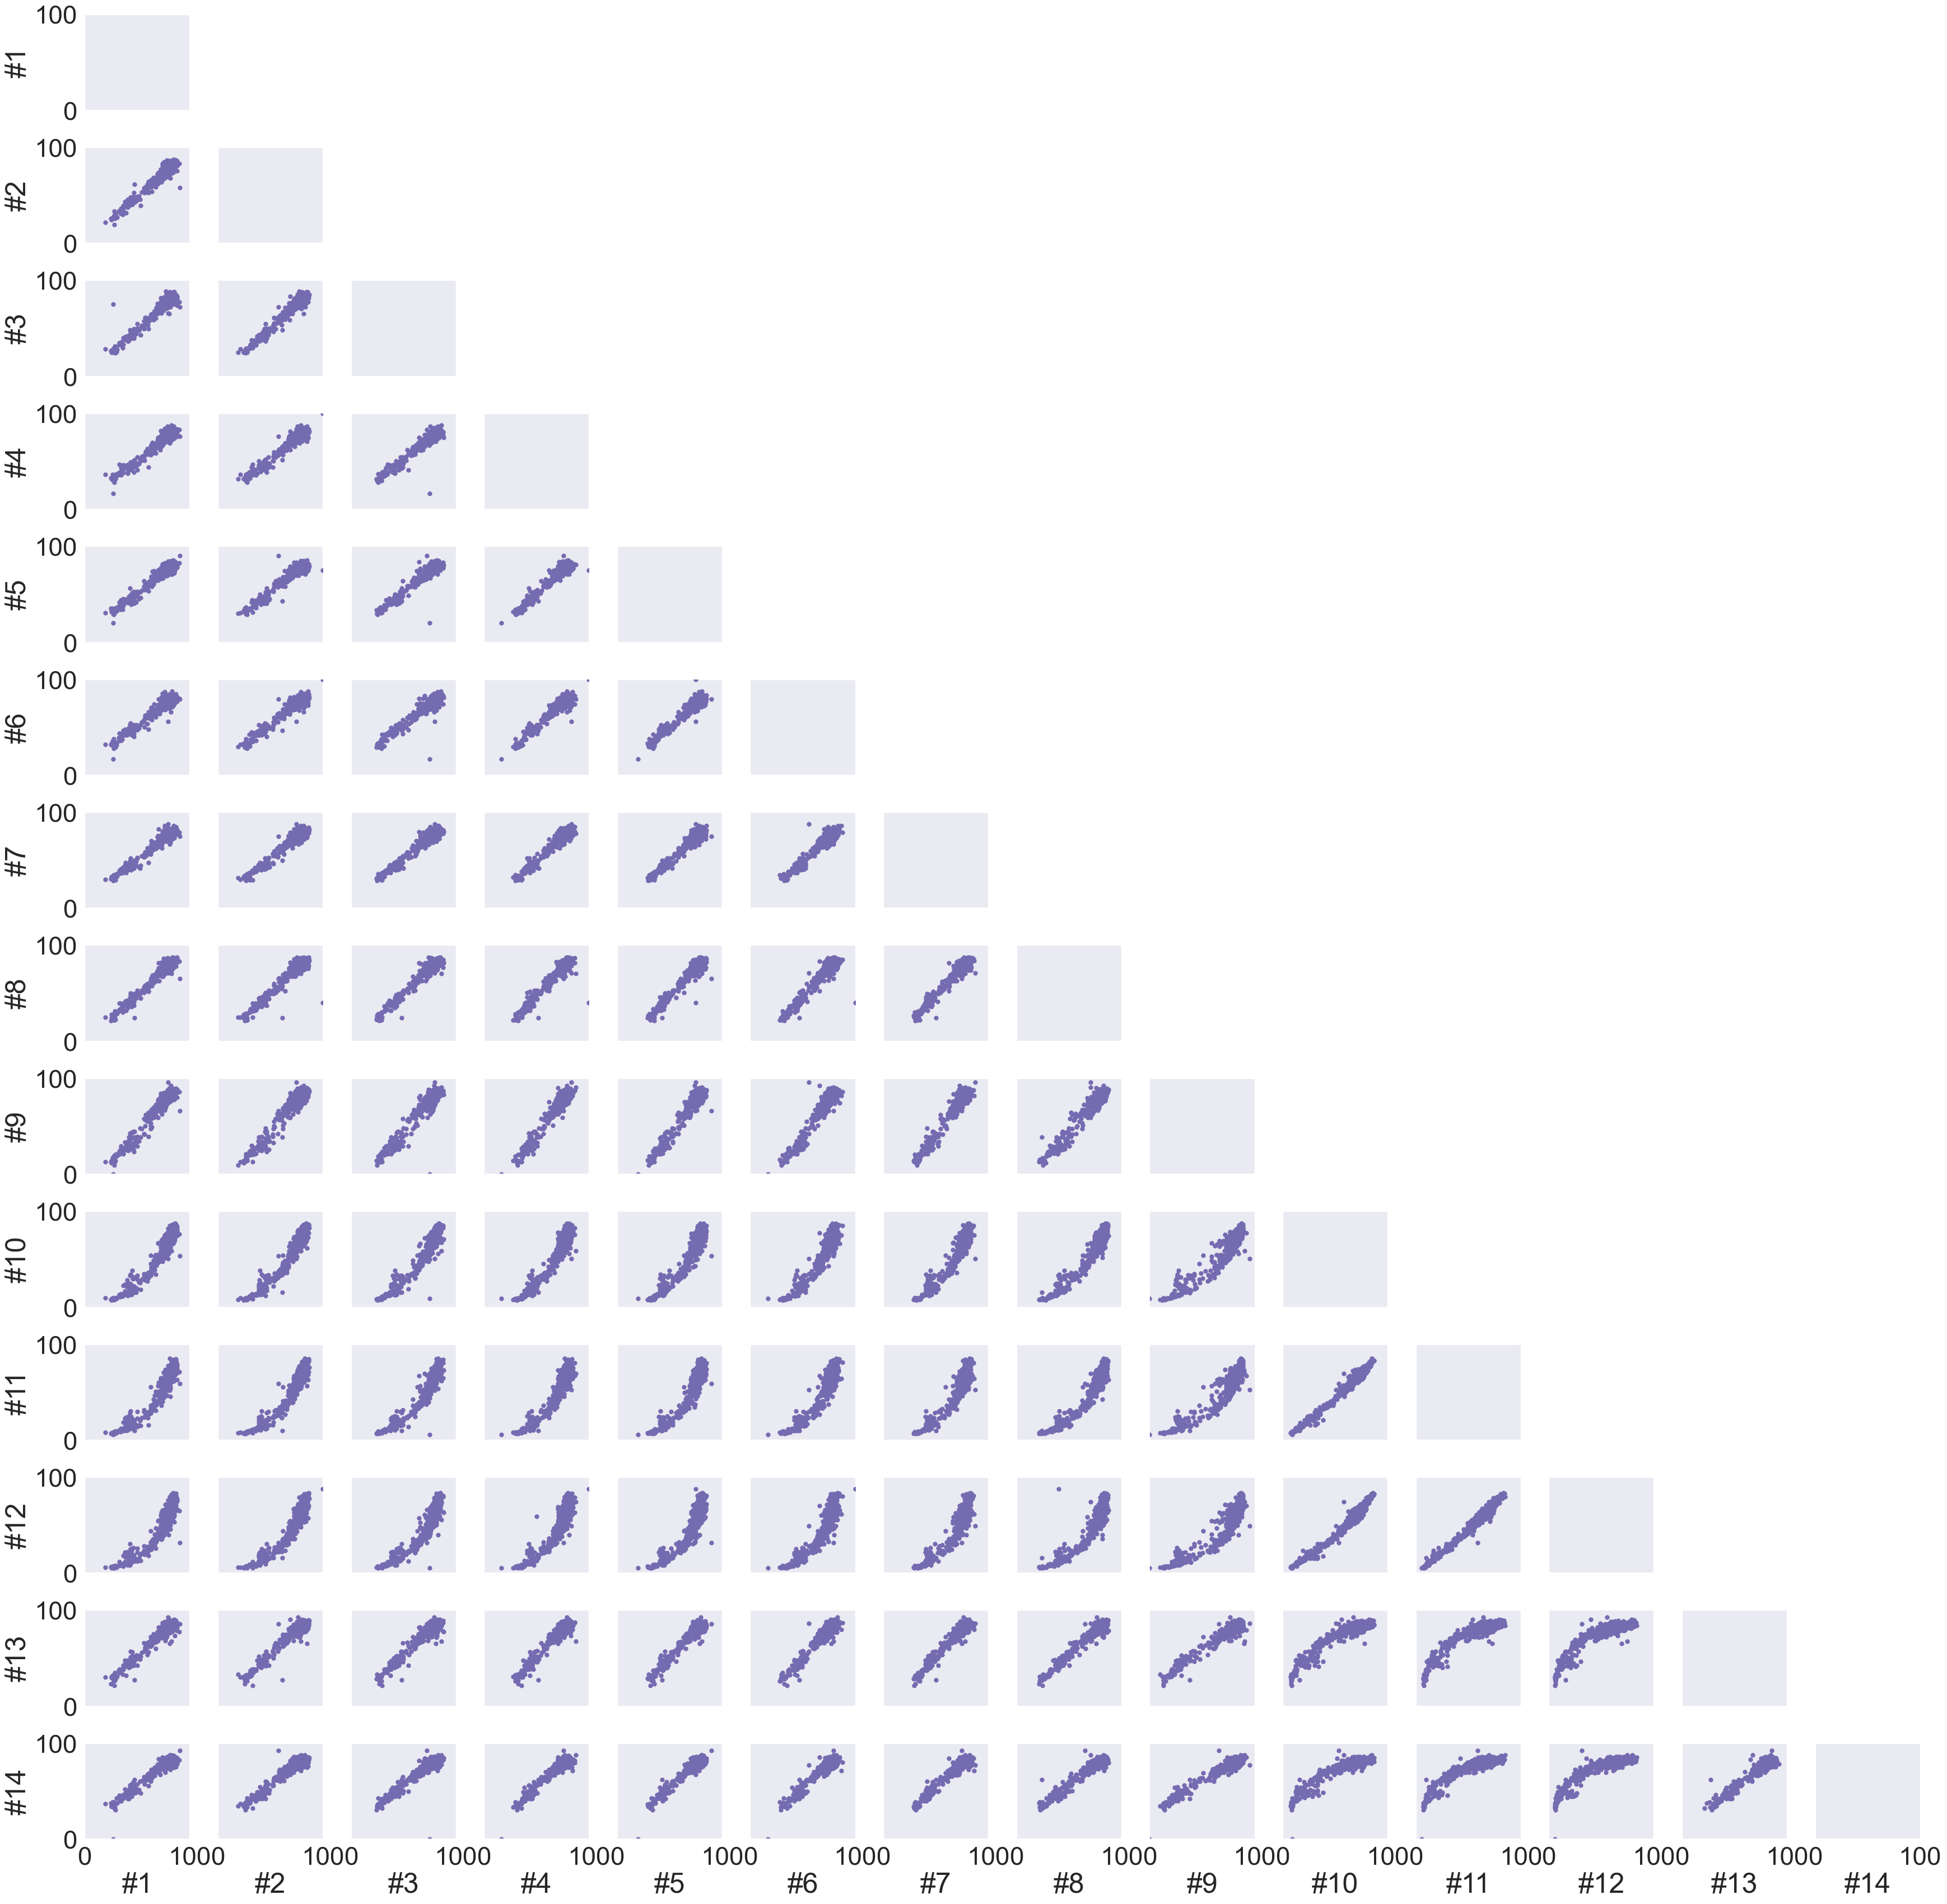

In [215]:
sns.set_palette( palette = light_colors[12:] )
g = sns.PairGrid( wide[ [ 'pos', 'ref', 'alt' ] + [ col for col in wide.columns if '_wmean_ALPHA' in col and '_inv' not in col ] ].groupby( [ 'pos', 'ref', 'alt' ] ).agg( np.nanmean ).reset_index()[ [ col for col in wide.columns if '_wmean_ALPHA' in col and '_inv' not in col ] ].apply( lambda x: x*100 ),
                    corner = True,
                  )
#g.map_diag( sns.histplot, binwidth = 2 )
g.map_offdiag( sns.scatterplot, rasterized = True, linewidth = 0 )
g.set( ylim = ( 0, 100 ), xlim = ( 0, 100 ) )
labels = [ '#' + str( i ) for i in range( 1, 15 ) ]

for i, ax in enumerate( g.axes.flat ):
    if i % len( labels ) == 0:
        ax.set_ylabel( labels[ int( i / len( labels ) ) ] )
    if i >= ( len( labels )*( len( labels ) - 1 )  ):
        ax.set_xlabel( labels[ int( i - ( len( labels )*( len( labels ) - 1 )  ) ) ] )

g.savefig( plot_out + 'alpha_corr.pdf' )  

In [216]:
#resets plot settings
matplotlib.rc_file_defaults()
plt.rcParams[ 'pdf.fonttype' ] = 42
plt.rcParams[ 'ps.fonttype' ] = 42
plt.rcParams[ 'font.sans-serif' ] = "Arial"
plt.rcParams[ 'font.family' ] = "sans-serif"

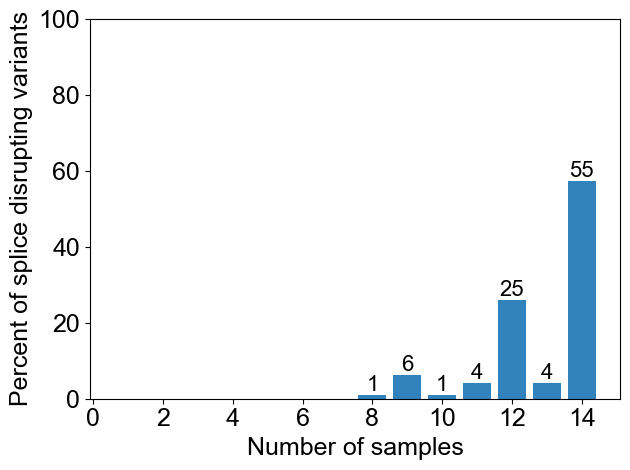

In [217]:
sp.barplot_per_repeat( wide.loc[ wide.sdv ][ [ 'pos', 'ref', 'alt', 'sdv_count' ] ].groupby( [ 'pos', 'ref', 'alt' ] ).agg( np.nanmean ),
                    'sdv_count',
                    14,
                    ylim = ( 0, 100 ),
                    ylabel = 'Percent of splice disrupting variants',
                    xlabel = 'Number of samples',
                    savefig = plot_out + 'sdv_by_samp.pdf',
                    color = light_colors[ 0 ]
                  )

Supp Figure 4

In [218]:
alpha_null = ( wide[ [ 'pos', 'alt', 'ref', 'wmean_bs_null_ALPHA' ] ]
                   .groupby( [ 'pos', 'alt', 'ref' ] )
                   .agg( np.nanmean ) ).median().to_numpy()[ 0 ]

In [219]:
beta_null = ( wide[ [ 'pos', 'alt', 'ref', 'wmean_bs_null_BETA' ] ]
                   .groupby( [ 'pos', 'alt', 'ref' ] )
                   .agg( np.nanmean ) ).median().to_numpy()[ 0 ]

In [220]:
skip_null = ( wide[ [ 'pos', 'alt', 'ref', 'wmean_bs_null_SKIP' ] ]
                   .groupby( [ 'pos', 'alt', 'ref' ] )
                   .agg( np.nanmean ) ).median().to_numpy()[ 0 ]

In [221]:
other_null = ( wide[ [ 'pos', 'alt', 'ref', 'wmean_bs_null_OTHER' ] ]
                   .groupby( [ 'pos', 'alt', 'ref' ] )
                   .agg( np.nanmean ) ).median().to_numpy()[ 0 ]

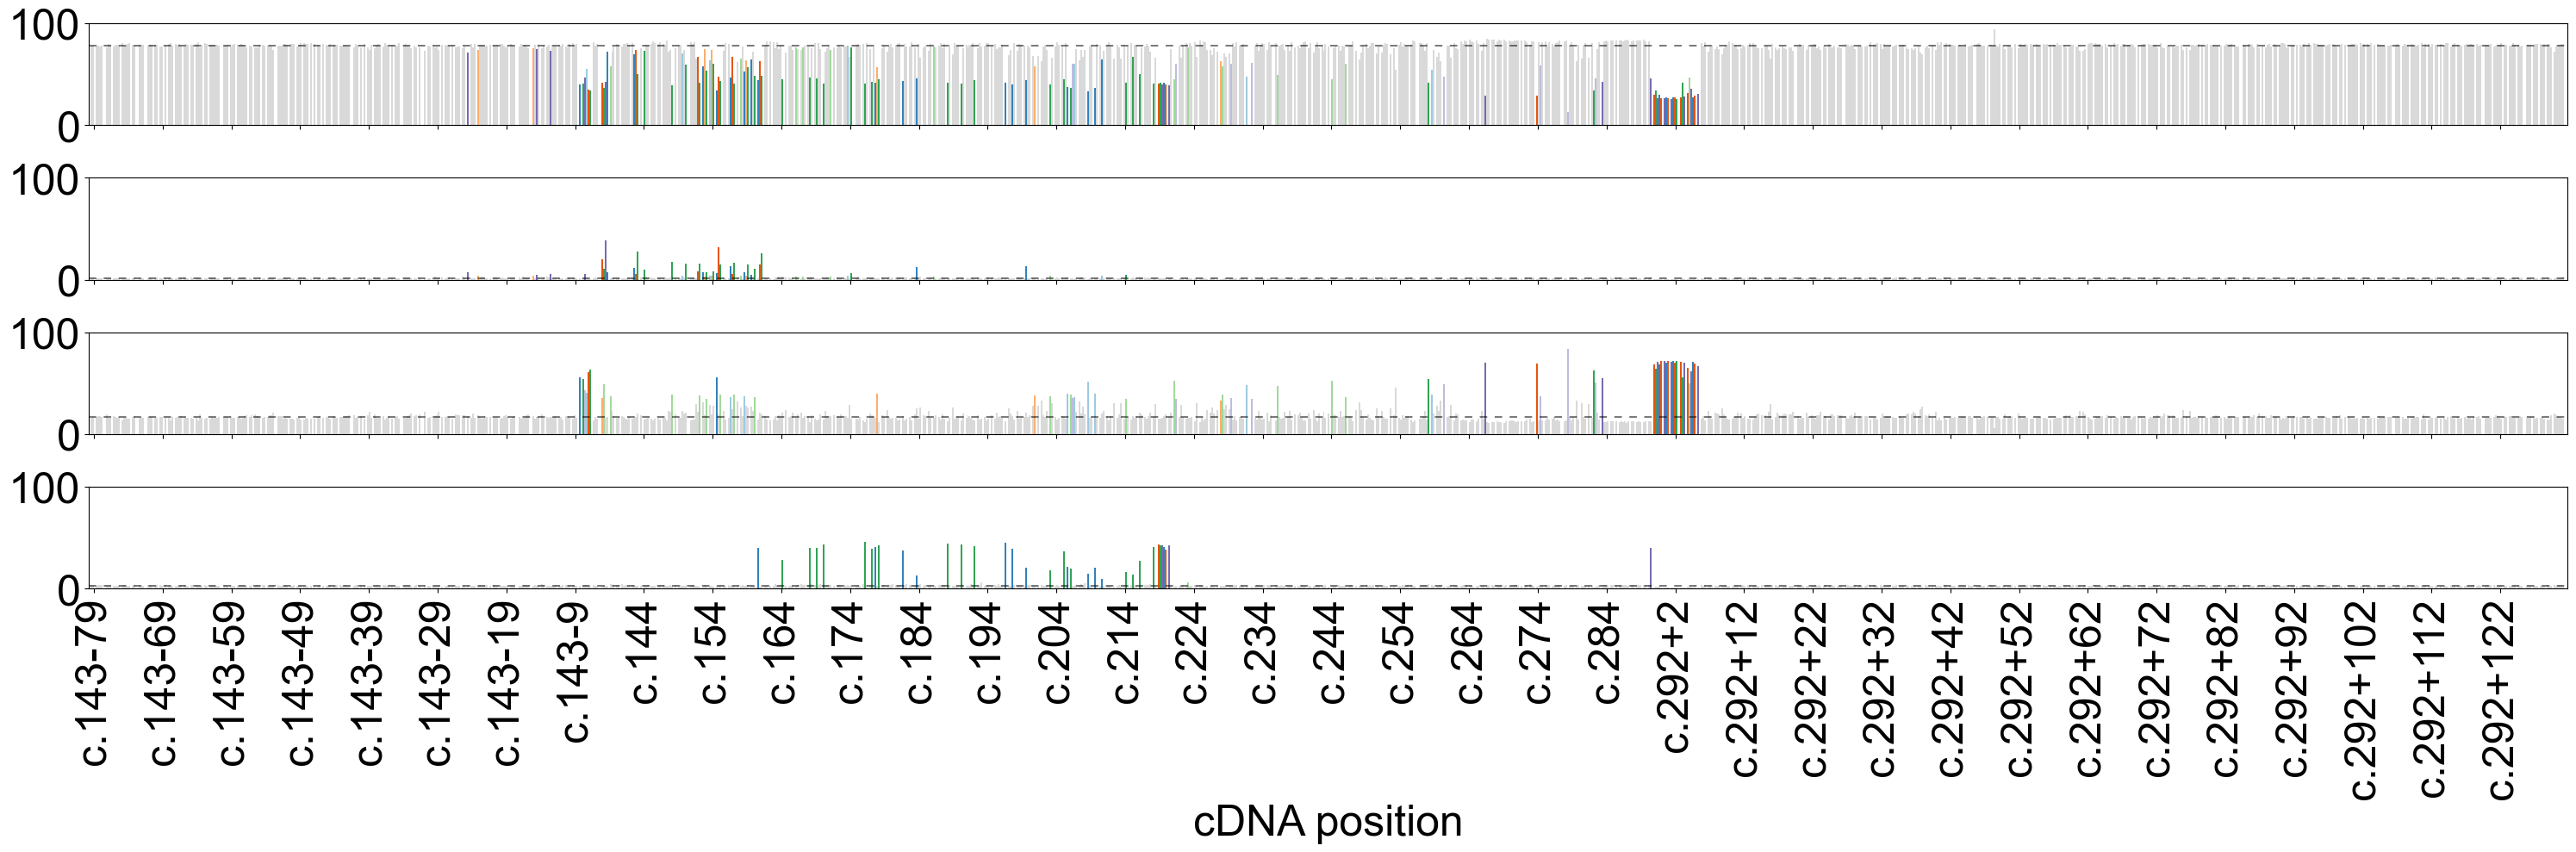

In [222]:
sp.subplots_wrapper( ( wide[ [ 'pos', 'alt', 'ref', 'hgvs_pos', 'sdv', 'sdv_BETA', 'sdv_SKIP', 'sdv_OTHER',
                               'intmed', 'intmed_BETA', 'intmed_SKIP', 'intmed_OTHER',
                               'wmean_ALPHA', 'wmean_BETA', 'wmean_SKIP', 'wmean_OTHER' ] ]
                   .groupby( [ 'pos', 'alt', 'ref', 'hgvs_pos', 'sdv', 'intmed' ] )
                   .agg( np.nanmean )
                   .reset_index() ),
                  [ 'wmean_ALPHA', 'wmean_BETA', 'wmean_SKIP', 'wmean_OTHER' ],
                 'hgvs_pos',
                  [ '.85', '.85', '.85', '.85', '.85' ],
                  legend = False,
                  y_ax_lim = [ ( 0, 100 ) ],
                  y_ax_title = [ '','', '', '' ],
                  x_ax_title = 'cDNA position',
                  darken_bars = [ ( 'sdv', [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                  ( 'sdv_BETA', [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                  ( 'sdv_SKIP', [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                  ( 'sdv_OTHER', [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                ],
                  darken_bars2 = [ ( 'intmed', [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                   ( 'intmed_BETA', [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                   ( 'intmed_SKIP', [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                   ( 'intmed_OTHER', [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ) ],
                  hlines = [ [ ( alpha_null, 'black', ( 0, ( 5, 5 ) ), 1.25 ) ],
                             [ ( beta_null, 'black', ( 0, ( 5, 5 ) ), 1.25 ) ], 
                             [ ( skip_null, 'black', ( 0, ( 5, 5 ) ), 1.25 ) ], 
                             [ ( other_null, 'black', ( 0, ( 5, 5 ) ), 1.25 ) ] ],
                  savefile = plot_out + 'full_shaded2col_per_nozoom_def.pdf',
                     )

Supp Figure 5

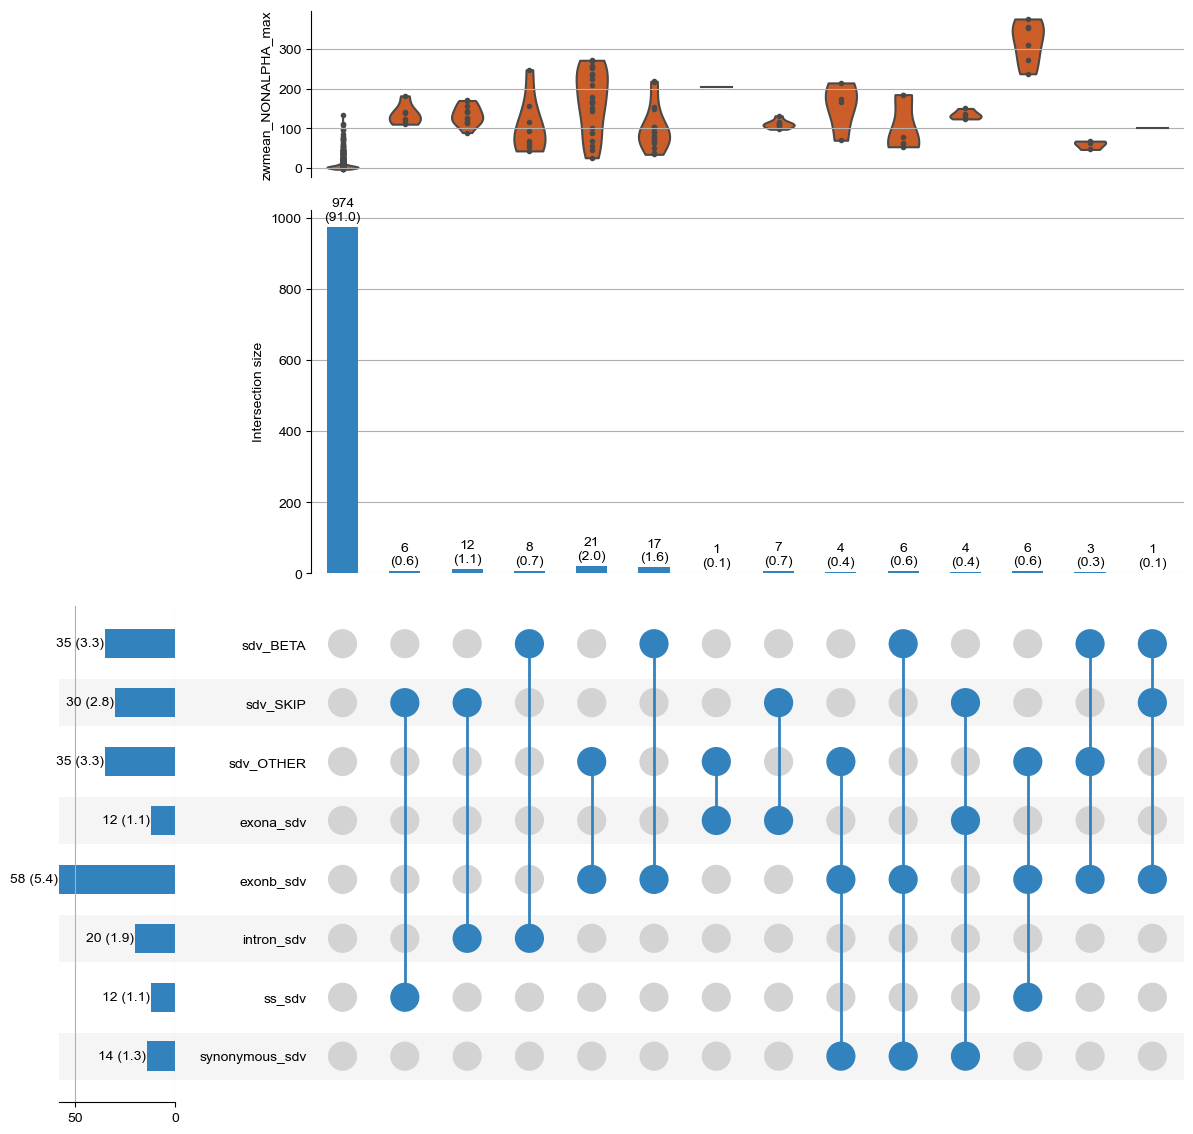

In [223]:
sp.upset_plot( ( wide
              [ [ 'pos', 'ref', 'alt', 'sdv_BETA', 'sdv_SKIP', 'sdv_OTHER', 'exona_sdv', 'exonb_sdv', 
                 'intron_sdv', 'ss_sdv', 'synonymous_sdv', 'zwmean_NONALPHA_max', ] ]
              .groupby( [ 'pos', 'ref', 'alt', 'sdv_BETA', 'sdv_SKIP', 'sdv_OTHER', 'exona_sdv', 'exonb_sdv', 
                         'intron_sdv', 'ss_sdv', 'synonymous_sdv', ] )
              .agg( np.nanmean )
              .reset_index() ), 
            [ 'sdv_BETA', 'sdv_SKIP', 'sdv_OTHER', 'exona_sdv', 'exonb_sdv', 'intron_sdv', 
             'ss_sdv', 'synonymous_sdv' ][::-1],
            ( 20, 20 ),
            [ 'zwmean_NONALPHA_max' ],
            [ 'violin' ],
            [ light_colors[ 4 ] ],
            show_counts = '%d',
            show_percentages = '%.1f',
            facecolor = light_colors[ 0 ],
            element_size = 60,
           sort_categories_by = None,
            savefig = plot_out + 'sdv_upset_7cat_pts.pdf' 
          )

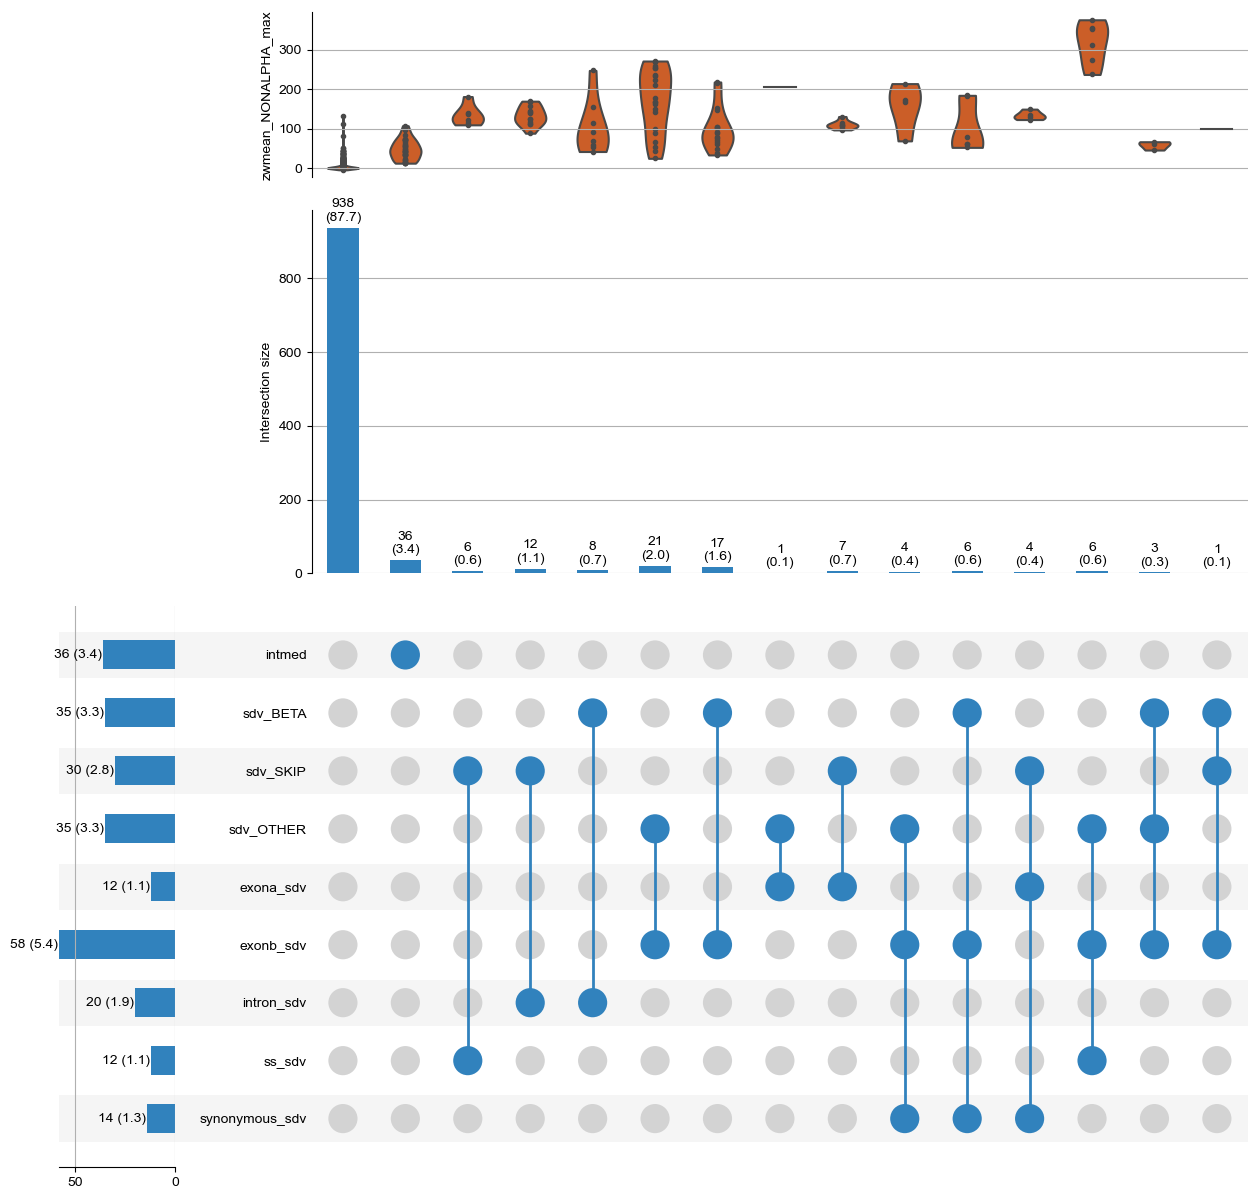

In [224]:
sp.upset_plot( ( wide
              [ [ 'pos', 'ref', 'alt', 'intmed', 'sdv_BETA', 'sdv_SKIP', 'sdv_OTHER', 'exona_sdv', 'exonb_sdv', 
                 'intron_sdv', 'ss_sdv', 'synonymous_sdv', 'zwmean_NONALPHA_max', ] ]
              .groupby( [ 'pos', 'ref', 'alt', 'sdv_BETA', 'sdv_SKIP', 'sdv_OTHER', 'exona_sdv', 'exonb_sdv', 
                         'intron_sdv', 'ss_sdv', 'synonymous_sdv', ] )
              .agg( np.nanmean )
              .reset_index() ), 
            [ 'intmed', 'sdv_BETA', 'sdv_SKIP', 'sdv_OTHER', 'exona_sdv', 'exonb_sdv', 'intron_sdv', 
             'ss_sdv', 'synonymous_sdv' ][::-1],
            ( 20, 20 ),
            [ 'zwmean_NONALPHA_max' ],
            [ 'violin' ],
            [ light_colors[ 4 ] ],
            show_counts = '%d',
            show_percentages = '%.1f',
            facecolor = light_colors[ 0 ],
            element_size = 60,
           sort_categories_by = None,
            savefig = plot_out + 'sdv_upset_7cat_pts.pdf' 
          )

Supp Figure 6

In [225]:
#145 possible alternate acceptors created
( wide
  .loc[ ( wide.psbl_snv_acc ) ][ [ 'pos', 'ref', 'alt', 'alt_snv_3ss_maxent' ] ]
  .groupby( [ 'pos', 'ref', 'alt'] )
  .agg( np.nanmean )
  .reset_index() ).shape

(145, 4)

In [226]:
#28 possible alternate acceptors used
( wide
  .loc[ ( wide.snv_acc ) ][ [ 'pos', 'ref', 'alt', 'alt_snv_3ss_maxent' ] ]
  .groupby( [ 'pos', 'ref', 'alt'] )
  .agg( np.nanmean )
  .reset_index() ).shape

(28, 4)

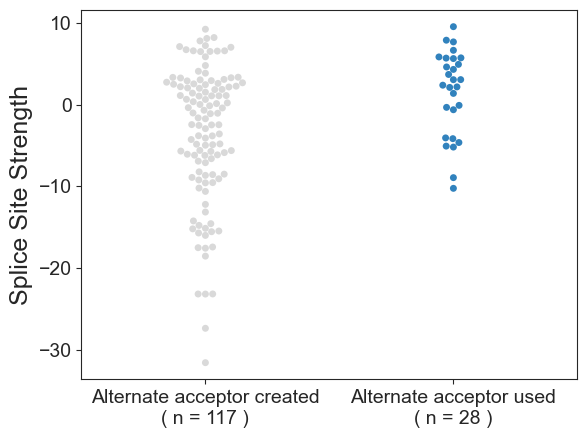

In [227]:
sp.swarm_plot( ( wide[ [ 'pos', 'ref', 'alt', 'hgvs_pos', 'snv_acc', 'alt_snv_3ss_maxent' ] ]
              .groupby( [ 'pos', 'ref', 'alt', 'snv_acc', 'hgvs_pos' ] )
              .agg( np.nanmean )
              .reset_index() ),
            'snv_acc',
            'alt_snv_3ss_maxent',
            palette = [ '.85', light_colors[0] ],
            x_tick_labels = [ 'Alternate acceptor created\n( n = 117 )', 'Alternate acceptor used\n( n = 28 )' ],
            y_ax_label = ' Splice Site Strength ',
            savefile = plot_out + 'altacc_maxent_swarm.pdf',
         )

In [228]:
ss.ttest_ind( ( wide
                .loc[ ( wide.psbl_snv_acc ) & ( wide.snv_acc == False ) ][ [ 'pos', 'ref', 'alt', 'alt_snv_3ss_maxent' ] ]
                .groupby( [ 'pos', 'ref', 'alt'] )
                .agg( np.nanmean )
                .reset_index()
                .alt_snv_3ss_maxent ),
              ( wide
                .loc[ ( wide.psbl_snv_acc ) & ( wide.snv_acc ) ][ [ 'pos', 'ref', 'alt', 'alt_snv_3ss_maxent' ] ]
                .groupby( [ 'pos', 'ref', 'alt'] )
                .agg( np.nanmean )
                .reset_index()
                .alt_snv_3ss_maxent ),
                 equal_var = False )

Ttest_indResult(statistic=-4.094440387019738, pvalue=0.00011958148911012323)

In [229]:
#99 possible alternate donors created
( wide
  .loc[ ( wide.psbl_snv_don ) ][ [ 'pos', 'ref', 'alt', 'alt_snv_3ss_maxent' ] ]
  .groupby( [ 'pos', 'ref', 'alt'] )
  .agg( np.nanmean )
  .reset_index() ).shape

(99, 4)

In [230]:
#1 possible alternate donor used
( wide
  .loc[ ( wide.snv_don ) ][ [ 'pos', 'ref', 'alt', 'alt_snv_3ss_maxent' ] ]
  .groupby( [ 'pos', 'ref', 'alt'] )
  .agg( np.nanmean )
  .reset_index() ).shape

(1, 4)

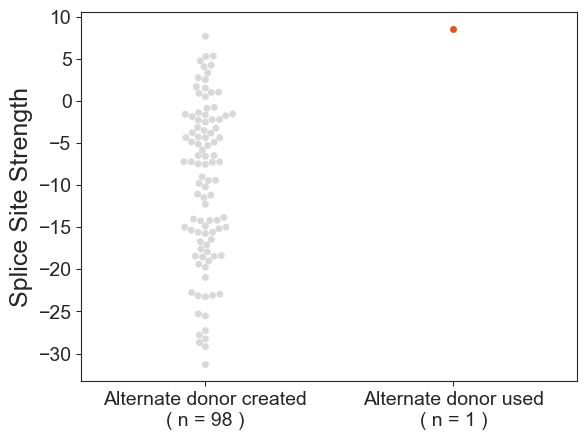

In [231]:
sp.swarm_plot( wide[ [ 'pos', 'ref', 'alt', 'hgvs_pos', 'snv_don', 'alt_snv_5ss_maxent' ] ].groupby( [ 'pos', 'ref', 'alt', 'snv_don', 'hgvs_pos' ] ).agg( np.nanmean ).reset_index(),
            'snv_don',
            'alt_snv_5ss_maxent',
            palette = [ '.85', light_colors[4] ],
            x_tick_labels = [ 'Alternate donor created\n( n = 98 )', 'Alternate donor used\n( n = 1 )' ],
            y_ax_label = ' Splice Site Strength ',
            savefile = plot_out + 'altdon_maxent_swarm.pdf',
         )

In [232]:
#resets plot settings
matplotlib.rc_file_defaults()
plt.rcParams[ 'pdf.fonttype' ] = 42
plt.rcParams[ 'ps.fonttype' ] = 42
plt.rcParams[ 'font.sans-serif' ] = "Arial"
plt.rcParams[ 'font.family' ] = "sans-serif"

In [233]:
#wt alpha is -3.63
wide[ ( wide.pos == 1201 ) & ( wide.crypt_acc_pos == 1201 ) ][ [ 'pos', 'alt', 'ref', 'crypt_acc_pos', 'crypt_wt_3ss_maxent' ] ]

pos alt ref  crypt_acc_pos  crypt_wt_3ss_maxent
562  1201   A   C         1201.0            -3.634894
564  1201   G   C         1201.0            -3.634894
566  1201   T   C         1201.0            -3.634894

In [234]:
#wt beta is 6.96
wide[ wide.pos == 1123 ][ [ 'pos', 'alt', 'ref', 'crypt_wt_3ss_maxent' ] ]

pos alt ref  crypt_wt_3ss_maxent
268  1123   A   T             6.959332
269  1123   C   T             6.959332
270  1123   G   T             6.959332

In [235]:
#wt donor is 10.77
wide[ wide.pos == 1272 ][ [ 'pos', 'alt', 'ref', 'crypt_don_pos', 'crypt_wt_5ss_maxent' ] ]

pos alt ref  crypt_don_pos  crypt_wt_5ss_maxent
915  1272   A   G         1272.0            10.766342
916  1272   A   G         1272.0            10.766342
917  1272   A   G         1272.0            10.766342
918  1272   C   G         1272.0            10.766342
919  1272   C   G         1272.0            10.766342
920  1272   C   G         1272.0            10.766342
921  1272   T   G         1272.0            10.766342
922  1272   T   G         1272.0            10.766342
923  1272   T   G         1272.0            10.766342

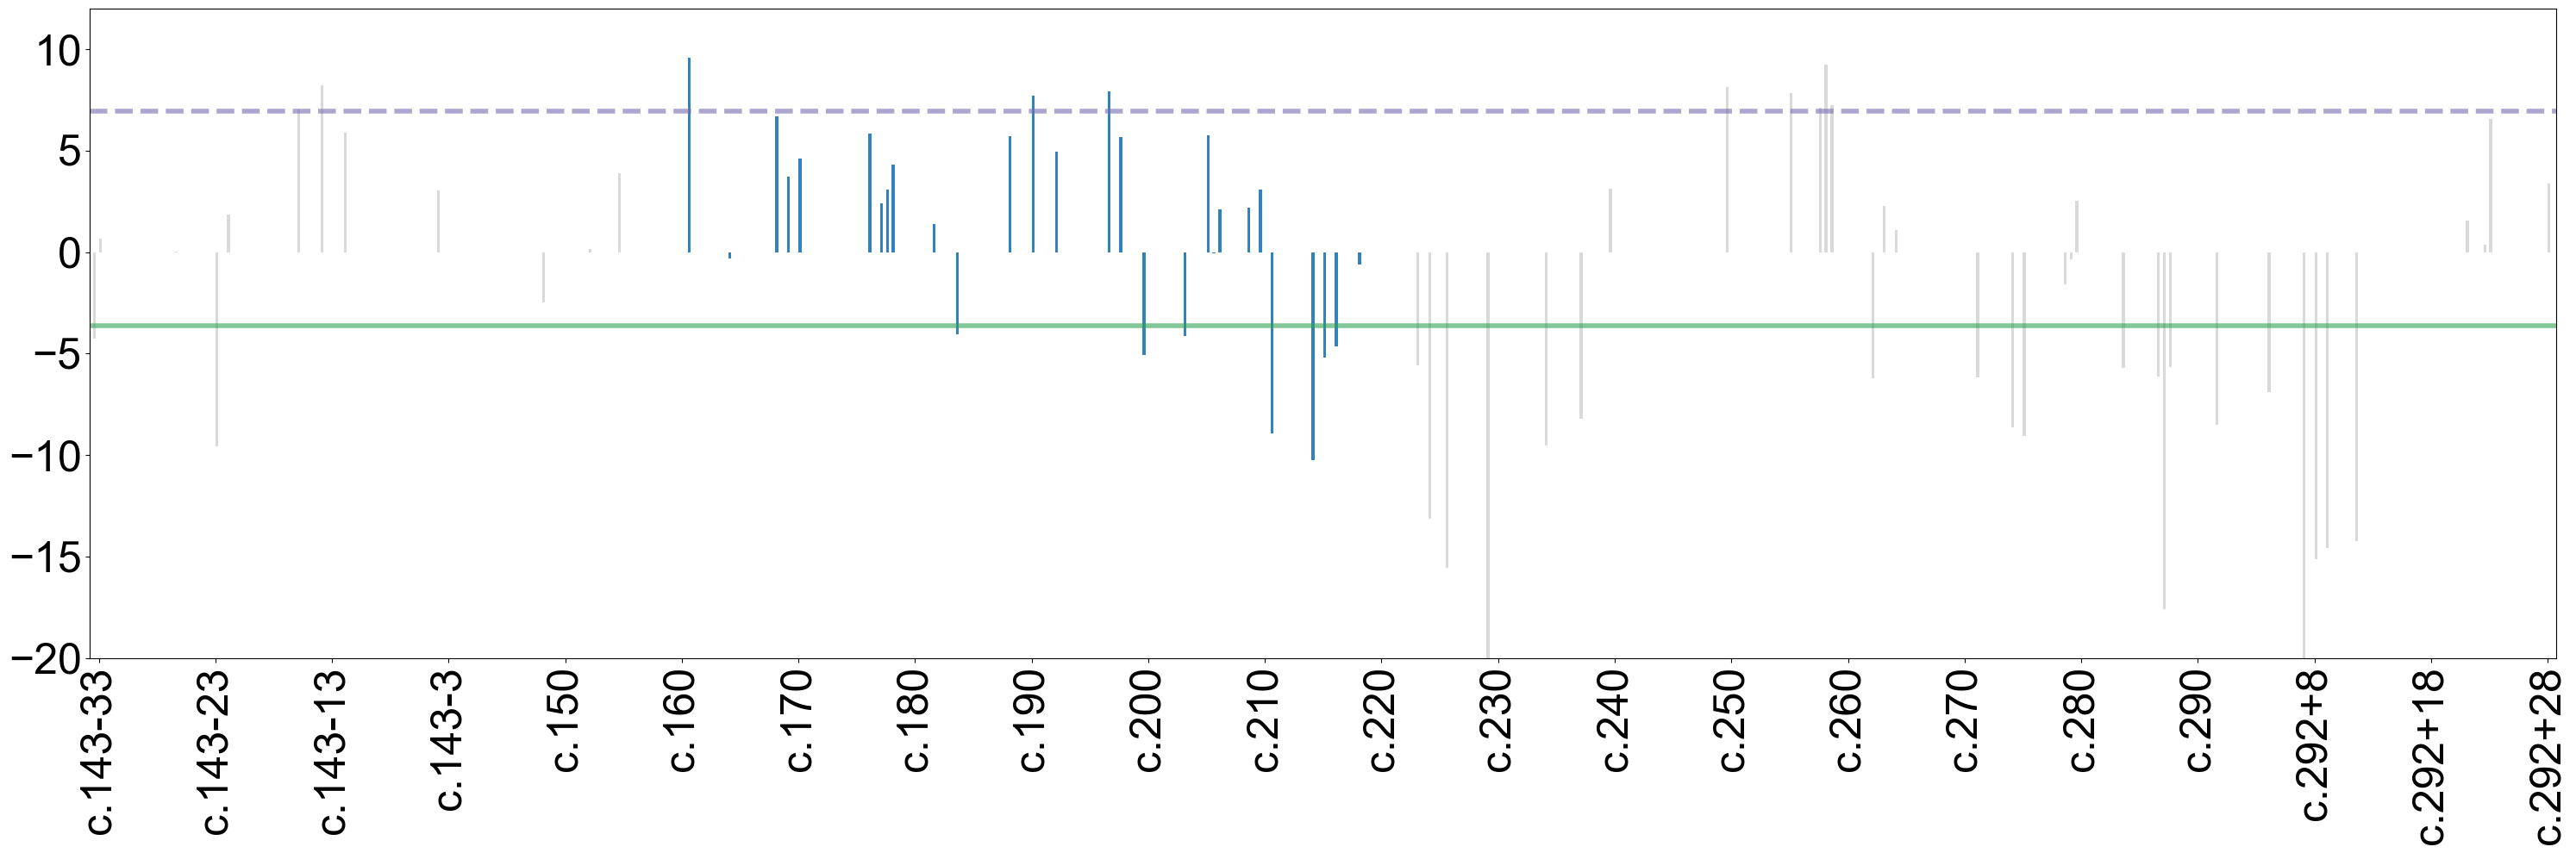

In [236]:
sp.subplots_wrapper( wide[ [ 'pos', 'ref', 'alt', 'hgvs_pos', 'snv_acc', 'alt_snv_3ss_maxent' ] ].fillna(0).groupby( [ 'pos', 'ref', 'alt', 'snv_acc', 'hgvs_pos' ] ).agg( np.nanmean ).reset_index(),
                  [ 'alt_snv_3ss_maxent' ],
                 'hgvs_pos',
                  [ '.85', '.85', '.85', '.85' ],
                  zoom = ( 1090, 1300 ),
                  legend = False,
                  y_ax_lim = [ ( -20, 12 ) ],
                  y_ax_title = [ '', '', '' ],
                  x_ax_title = 'cDNA position',
                  darken_bars = [ ( 'snv_acc', [ light_colors[0], light_colors[0], light_colors[0], light_colors[0] ] ), ],
                  hlines = [ [ ( -3.634894, light_colors[8], '-', 4 ),
                             ( 6.959332, light_colors[12], '--', 4 ) ] ],
                  savefile = plot_out + 'altacc_pos.pdf',
                     )

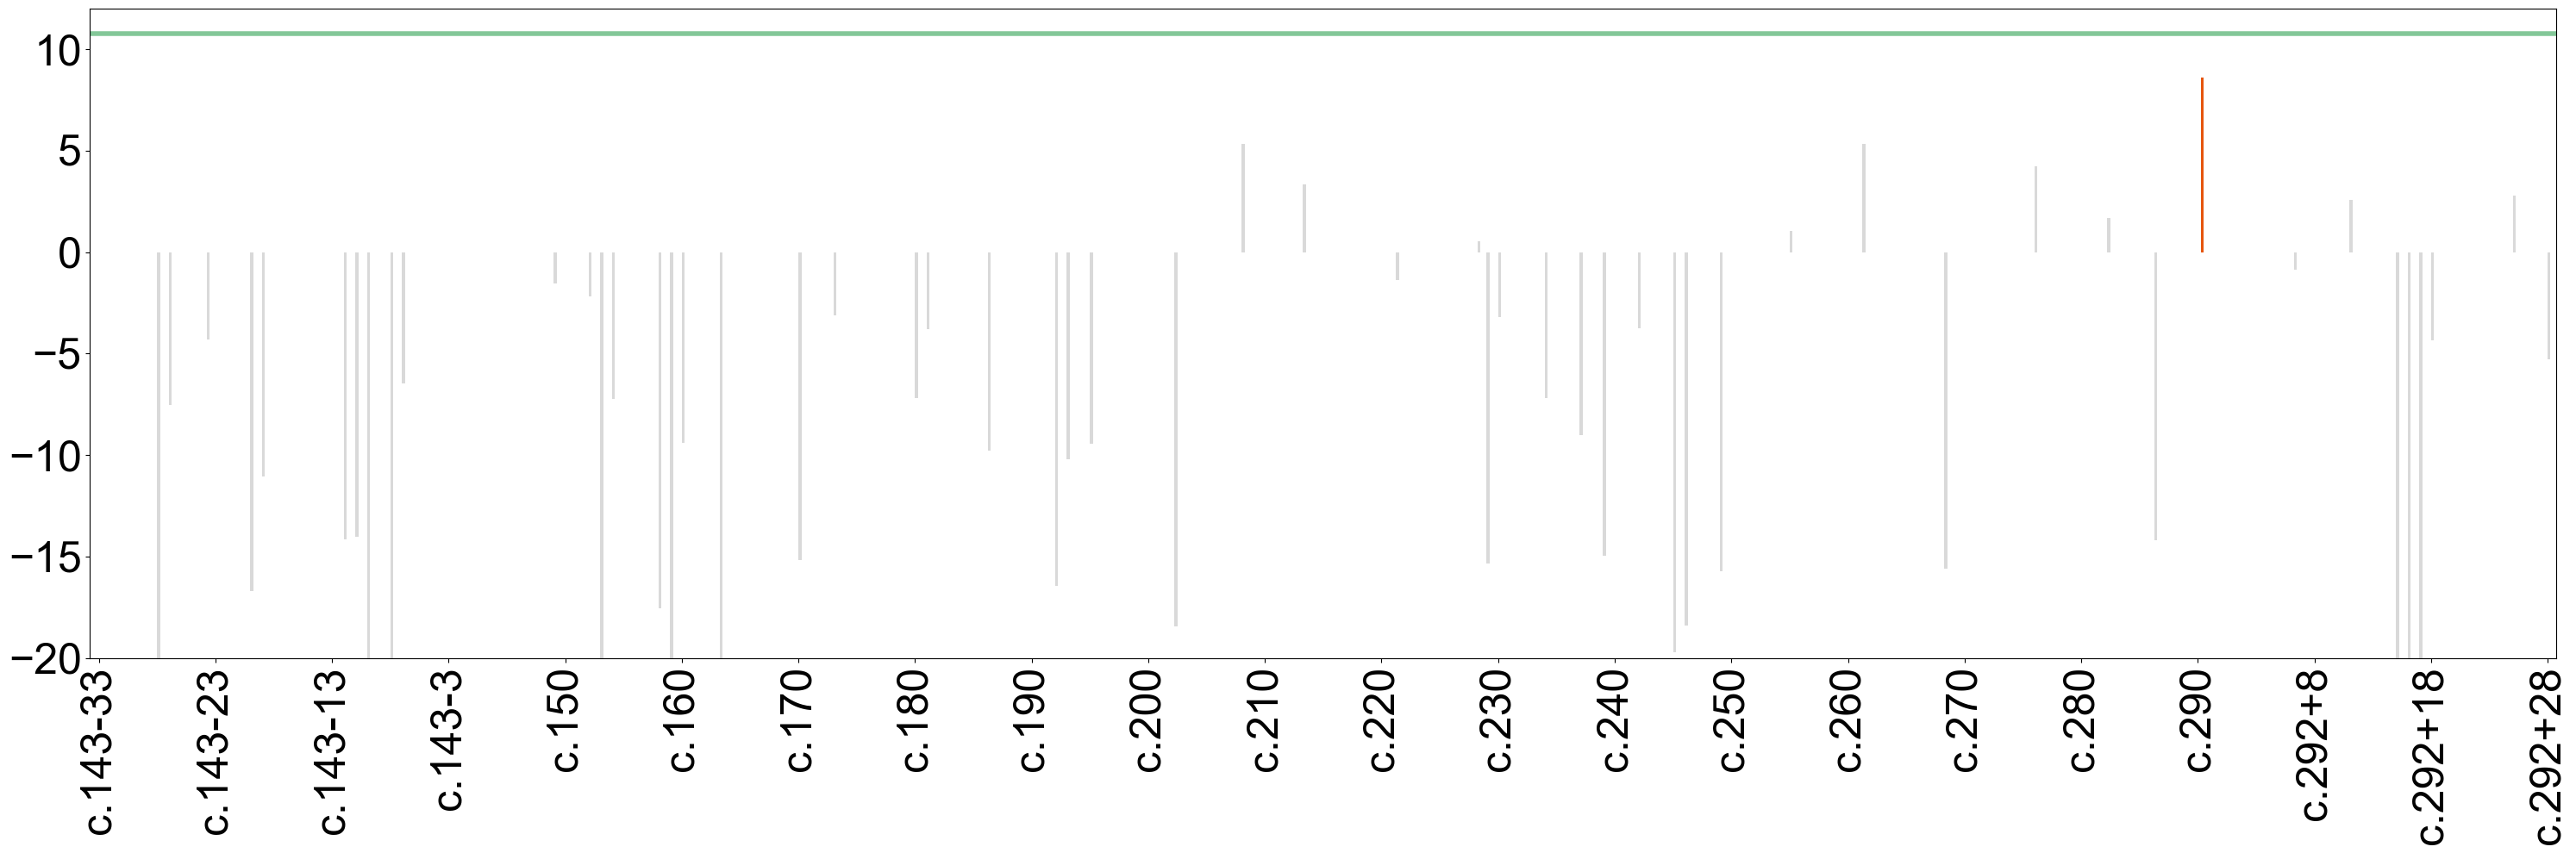

In [237]:
sp.subplots_wrapper( wide[ [ 'pos', 'ref', 'alt', 'hgvs_pos', 'snv_don', 'alt_snv_5ss_maxent' ] ].fillna(0).groupby( [ 'pos', 'ref', 'alt', 'snv_don', 'hgvs_pos' ] ).agg( np.nanmean ).reset_index(),
                  [ 'alt_snv_5ss_maxent' ],
                 'hgvs_pos',
                  [ '.85', '.85', '.85', '.85' ],
                  zoom = ( 1090, 1300 ),
                  legend = False,
                  y_ax_lim = [ ( -20, 12 ) ],
                  y_ax_title = [ '', '', '' ],
                  x_ax_title = 'cDNA position',
                  darken_bars = [ ( 'snv_don', [ light_colors[4], light_colors[4], light_colors[4], light_colors[4] ] ), ],
                  hlines = [ [ ( 10.766342, light_colors[8], '-', 4 ), ] ],
                  savefile = plot_out + 'altdon_pos.pdf',
                     )

In [238]:
#minimum is -31.6 (and its for an acceptor)
min( wide.alt_snv_3ss_maxent.min(), wide.alt_snv_5ss_maxent.min() )

-31.61370682062938

Supp Figure 7

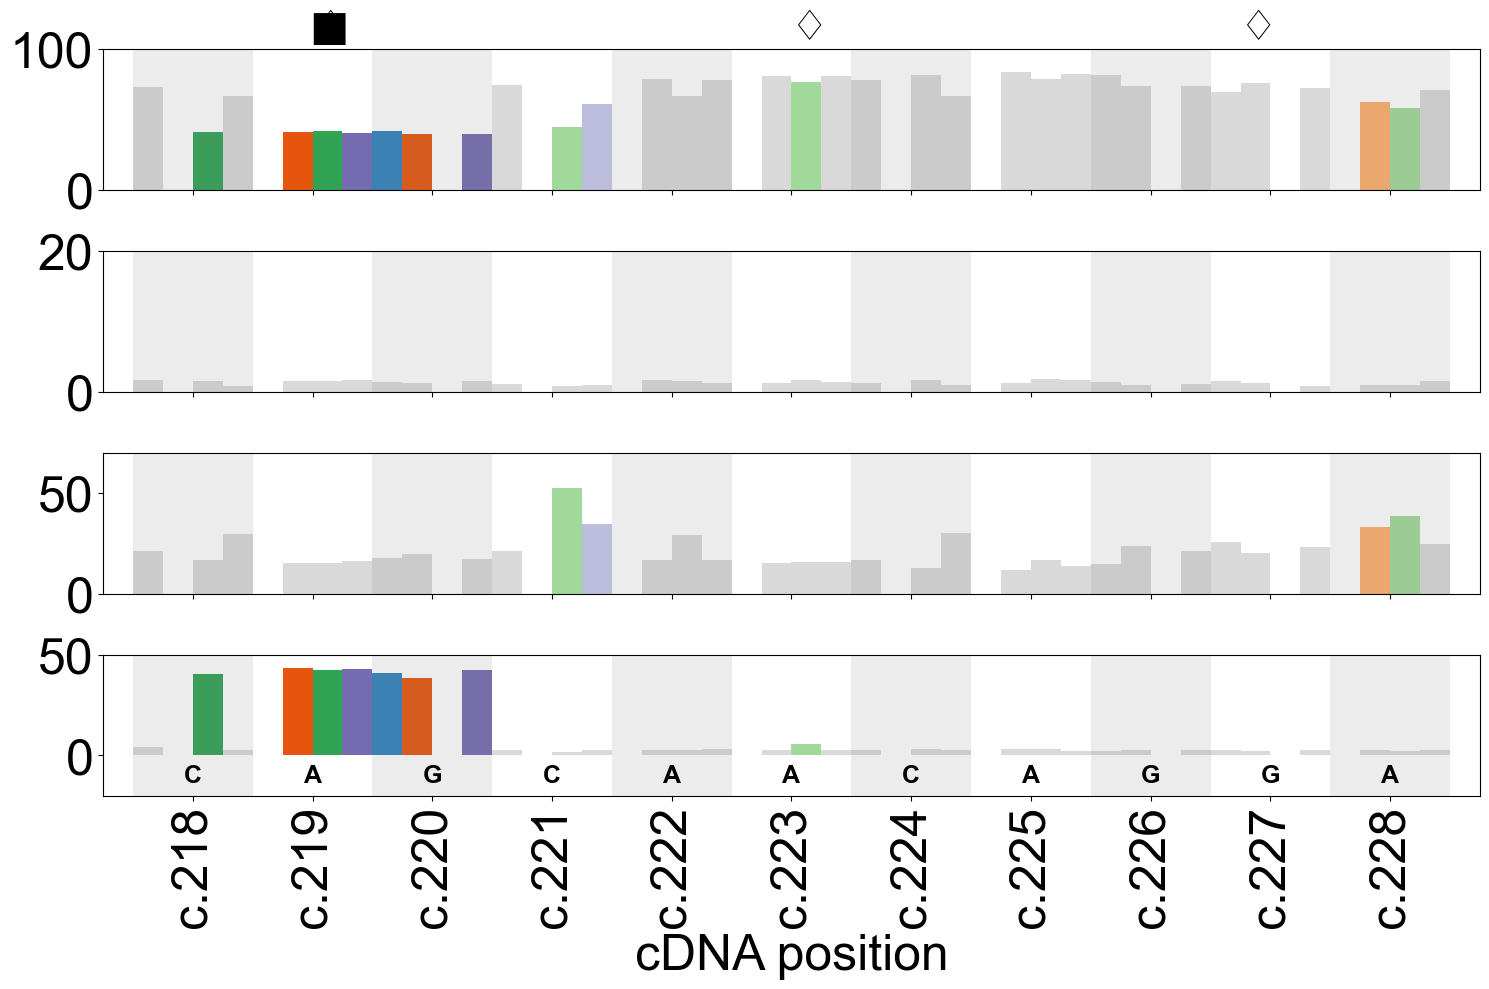

In [239]:
sp.subplots_wrapper( ( wide[ [ 'pos', 'alt', 'ref', 'hgvs_pos', 'sdv', 'sdv_BETA', 'sdv_SKIP', 'sdv_OTHER',
                               'intmed', 'intmed_BETA', 'intmed_SKIP', 'intmed_OTHER',
                               'wmean_ALPHA', 'wmean_BETA', 'wmean_SKIP', 'wmean_OTHER', 'gnomad_var', 'patient_var' ] ]
                   .groupby( [ 'pos', 'alt', 'ref', 'hgvs_pos', 'sdv', 'intmed', 'gnomad_var', 'patient_var' ] )
                   .agg( np.nanmean )
                   .reset_index() ),
                  [ 'wmean_ALPHA', 'wmean_BETA', 'wmean_SKIP', 'wmean_OTHER' ],
                 'hgvs_pos',
                  [ '.85', '.85', '.85', '.85', '.85' ],
                  fig_size = ( 15, 10 ),
                  zoom = ( 1198, 1208 ),
                  share_y = False,
                  legend = False,
                  y_ax_lim = [ ( 0, 100 ), ( 0, 20 ), ( 0, 70 ), ( 0, 50 ) ],
                  y_ax_title = [ '','', '', '' ],
                  x_ax_title = 'cDNA position',
                  darken_bars = [ ( 'sdv', [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                  ( 'sdv_BETA', [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                  ( 'sdv_SKIP', [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                  ( 'sdv_OTHER', [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                ],
                  darken_bars2 = [ ( 'intmed', [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                   ( 'intmed_BETA', [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                   ( 'intmed_SKIP', [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                   ( 'intmed_OTHER', [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ) ],
                  tick_spacing = 1,
                  wt_labels = True,
                  bar_labels = [ ( 'gnomad_var', r'$\diamondsuit$', 'gnomAD variant', 30 ) ,
                                 ( 'patient_var', r'$\blacksquare$', 'Patient variant', 30 ),
                                  ],
                  bar_label_loc = 'above',
                  bar_labels_offset = False,
                  shade_by_base = True,
                  savefile = plot_out + 'altacc_shaded2col_per.pdf',
                     )

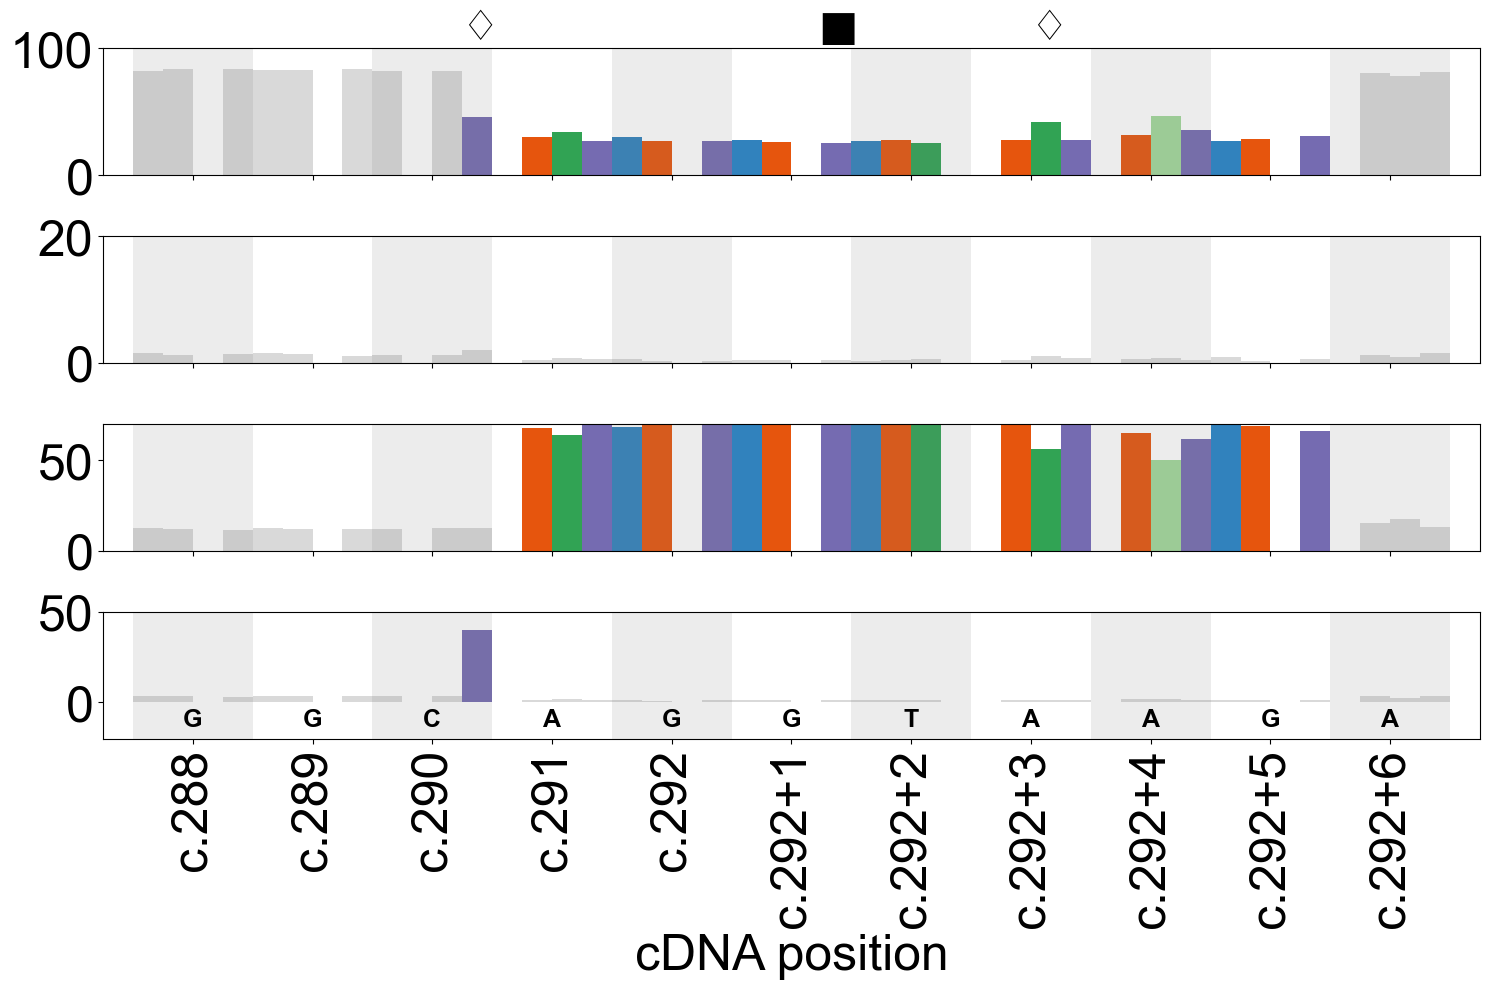

In [240]:
sp.subplots_wrapper( ( wide[ [ 'pos', 'alt', 'ref', 'hgvs_pos', 'sdv', 'sdv_BETA', 'sdv_SKIP', 'sdv_OTHER',
                               'intmed', 'intmed_BETA', 'intmed_SKIP', 'intmed_OTHER', 'patient_var',
                               'wmean_ALPHA', 'wmean_BETA', 'wmean_SKIP', 'wmean_OTHER', 'gnomad_var', ] ]
                   .groupby( [ 'pos', 'alt', 'ref', 'hgvs_pos', 'sdv', 'intmed', 'patient_var', 'gnomad_var' ] )
                   .agg( np.nanmean )
                   .reset_index() ),
                  [ 'wmean_ALPHA', 'wmean_BETA', 'wmean_SKIP', 'wmean_OTHER' ],
                 'hgvs_pos',
                  [ '.85', '.85', '.85', '.85', '.85' ],
                  fig_size = ( 15, 10 ),
                  zoom = ( 1268, 1278 ),
                  share_y = False,
                  legend = False,
                  y_ax_lim = [ ( 0, 100 ), ( 0, 20 ), ( 0, 70 ), ( 0, 50 ) ],
                  y_ax_title = [ '','', '', '' ],
                  x_ax_title = 'cDNA position',
                  darken_bars = [ ( 'sdv', [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                  ( 'sdv_BETA', [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                  ( 'sdv_SKIP', [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                  ( 'sdv_OTHER', [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                ],
                  darken_bars2 = [ ( 'intmed', [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                   ( 'intmed_BETA', [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                   ( 'intmed_SKIP', [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                   ( 'intmed_OTHER', [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ) ],
                  tick_spacing = 1,
                  wt_labels = True,
                  bar_labels = [ ( 'gnomad_var', r'$\diamondsuit$', 'gnomAD variant', 30 ) ,
                                 ( 'patient_var', r'$\blacksquare$', 'Patient variant', 30 ) ],
                  bar_label_loc = 'above',
                  bar_labels_offset = False,
                  shade_by_base = True,
                  savefile = plot_out + 'donor_shaded2col_per.pdf',
                     )

Supp Figure 8

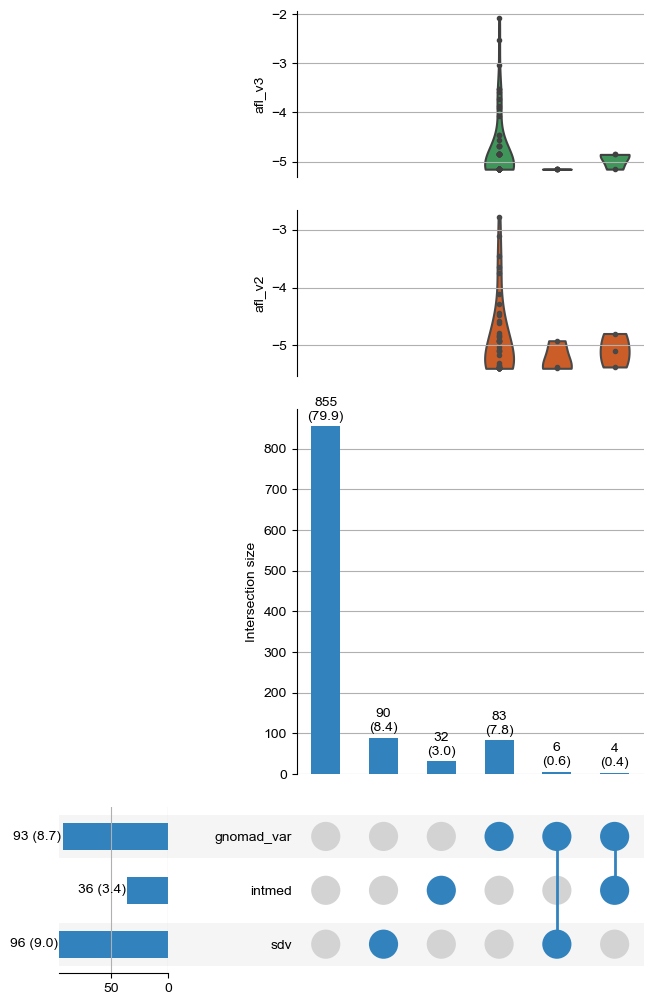

In [241]:
sp.upset_plot( ( wide[ [ 'pos', 'ref', 'alt', 'sdv', 'intmed', 'gnomad_var', 'afl_v2', 'afl_v3', 'zwmean_NONALPHA_max' ] ]
              .groupby( [ 'pos', 'ref', 'alt', 'sdv', 'intmed', 'gnomad_var'] )
              .agg( np.nanmean )
              .reset_index() ), 
            [ 'sdv', 'intmed', 'gnomad_var' ],
            ( 20, 20 ),
            [ 'afl_v2', 'afl_v3' ],
            [ 'violin', 'violin' ],
            [ light_colors[ 4 ], light_colors[ 8 ], light_colors[ 12 ] ],
            show_counts = '%d',
            show_percentages = '%.1f',
            facecolor = light_colors[ 0 ],
            element_size = 60,
            sort_categories_by = None,
            savefig = plot_out + 'gnomad_upset_strip.pdf' 
          )

In [242]:
#mild sdvs and sdvs not depleted in gnomad
ss.fisher_exact( [ [ wide.loc[ ( wide.gnomad_var ) & ( wide.intmed_sdv ) ].groupby( [ 'pos', 'ref', 'alt' ] ).count().shape[ 0 ], 
                    wide.loc[ ( wide.gnomad_var ) & ( wide.intmed_sdv == False ) ].groupby( [ 'pos', 'ref', 'alt' ] ).count().shape[ 0 ] ],
                    [ wide.loc[ ( wide.gnomad_var == False ) & ( wide.intmed_sdv ) ].groupby( [ 'pos', 'ref', 'alt' ] ).count().shape[ 0 ], 
                    wide.loc[ ( wide.gnomad_var == False ) & ( wide.intmed_sdv == False ) ].groupby( [ 'pos', 'ref', 'alt' ] ).count().shape[ 0 ] ] ] )

(0.8443610507604187, 0.7422680183627748)

Supp Figure 9

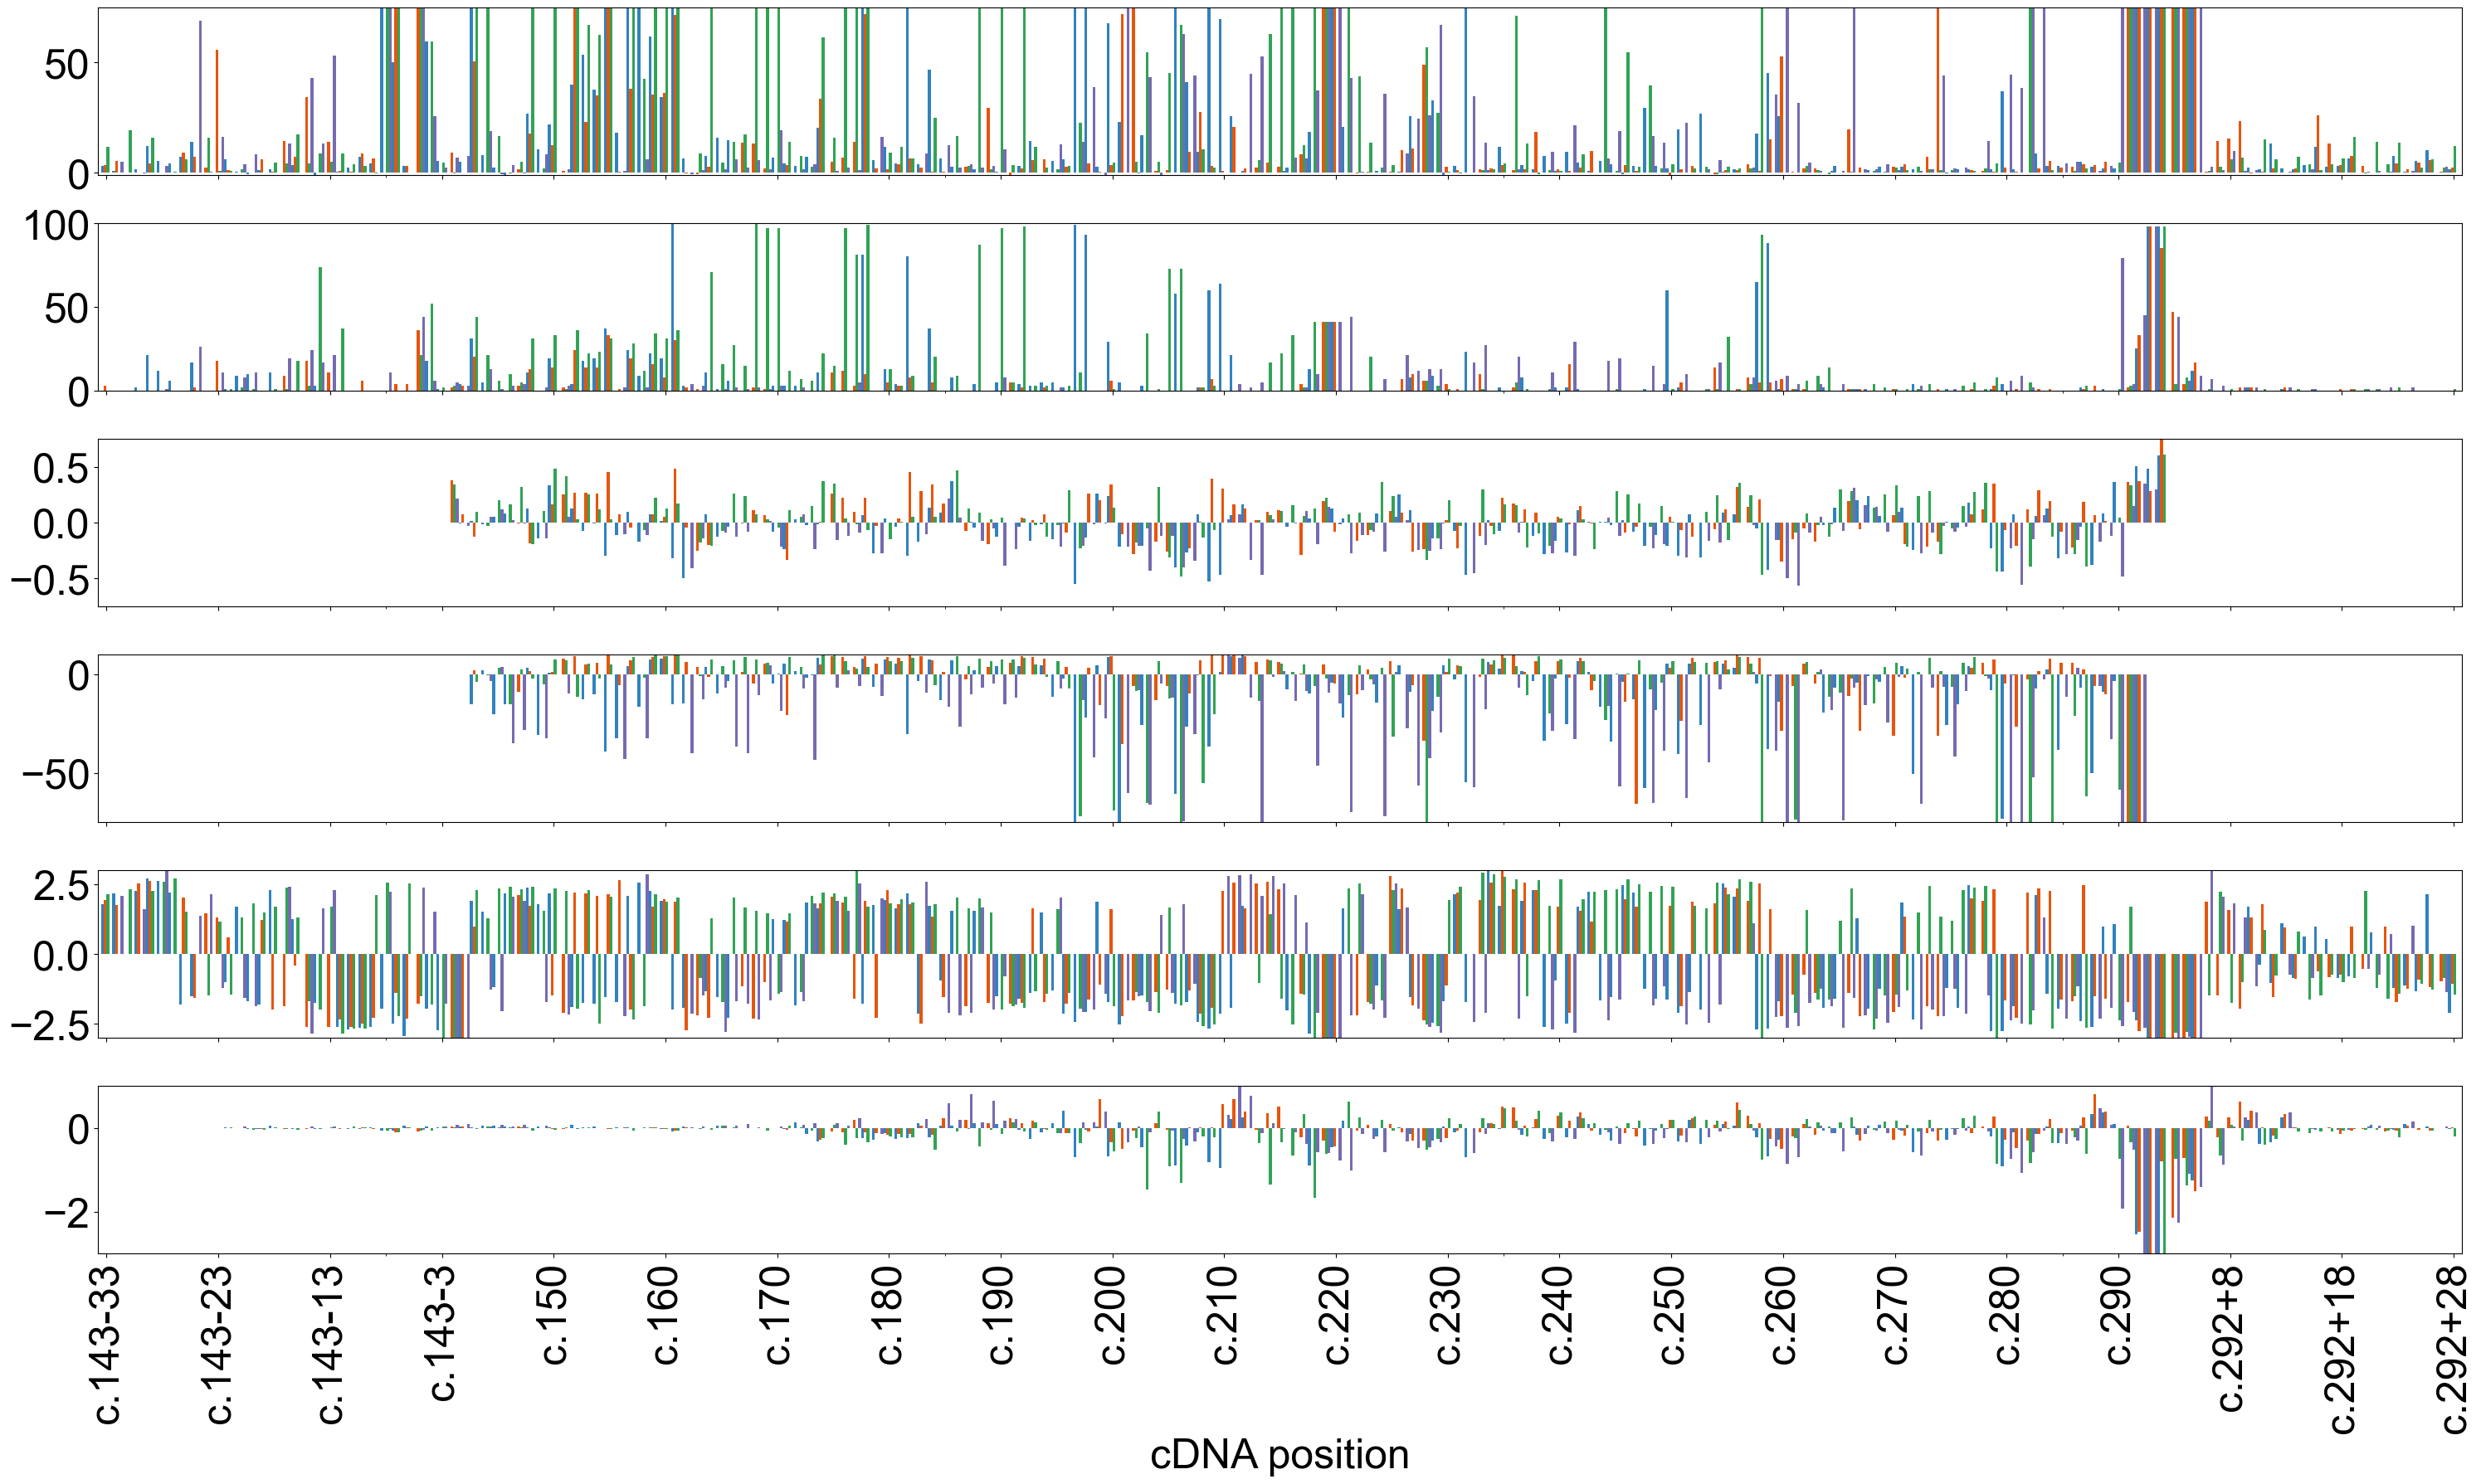

In [243]:
sp.subplots_wrapper( ( wide[ [ 'pos', 'alt', 'ref', 'hgvs_pos', 'sdv', 'zwmean_NONALPHA_max', 'DS_max100', 'ke_chgMEAN', 'hal_chgPER', 'spanr_chgZPER', 'mmsplice_chgPERlogit' ] ]
                   .groupby( [ 'pos', 'alt', 'ref', 'hgvs_pos', 'sdv' ] )
                   .agg( np.nanmean )
                   .reset_index() ),
                  [ 'zwmean_NONALPHA_max', 'DS_max100', 'ke_chgMEAN', 'hal_chgPER', 'spanr_chgZPER', 'mmsplice_chgPERlogit' ],
                 'hgvs_pos',
                  [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ],
                  fig_size = ( 30, 18 ),
                  zoom = ( 1090, 1300 ),
                  share_y = False,
                  legend = False,
                  y_ax_lim = [ (-1,75), (0, 100), (-.75, .75), (-75, 10), (-3,3), (-3,1) ],
                  y_ax_title = [ '', '', '', '', '', '' ],
                  x_ax_title = 'cDNA position',
                  savefile = plot_out + 'pred_sdv_zmax_allcol.pdf',
                     )

Supp Figure 10

In [244]:
#sensitivity/recall
recall = \
( wide.loc[ ( wide.pos >= 1123 ) & ( wide.pos <= 1272 ) & ( wide.sdv ) & ( wide.DS_max >= .18 ) ]
  [ [ 'pos', 'alt', 'ref', 'DS_max'] ]
  .groupby( [ 'pos', 'alt', 'ref', ] )
  .agg( np.nanmean )
  .reset_index() ).shape[ 0 ] \
/ ( wide.loc[ ( wide.pos >= 1123 ) & ( wide.pos <= 1272 ) & ( wide.sdv ) ]
  [ [ 'pos', 'alt', 'ref', 'DS_max'] ]
  .groupby( [ 'pos', 'alt', 'ref', ] )
  .agg( np.nanmean )
  .reset_index() ).shape[ 0 ]

In [245]:
#precision
precision = \
( wide.loc[ ( wide.pos >= 1123 ) & ( wide.pos <= 1272 ) & ( wide.sdv ) & ( wide.DS_max >= .18 ) ]
  [ [ 'pos', 'alt', 'ref', 'DS_max'] ]
  .groupby( [ 'pos', 'alt', 'ref', ] )
  .agg( np.nanmean )
  .reset_index() ).shape[ 0 ] \
/ ( wide.loc[ ( wide.pos >= 1123 ) & ( wide.pos <= 1272 ) & ( wide.DS_max >= .18 ) ]
  [ [ 'pos', 'alt', 'ref', 'DS_max'] ]
  .groupby( [ 'pos', 'alt', 'ref', ] )
  .agg( np.nanmean )
  .reset_index() ).shape[ 0 ]

DS_max 0.843376329966547
ke_chgMEAN_abs 0.2508019602893833
hal_chgPER_abs 0.28890351720920404
spanr_chgZPER_abs 0.28361460690529244
mmsplice_chgPERlogit_abs 0.35066726113487146


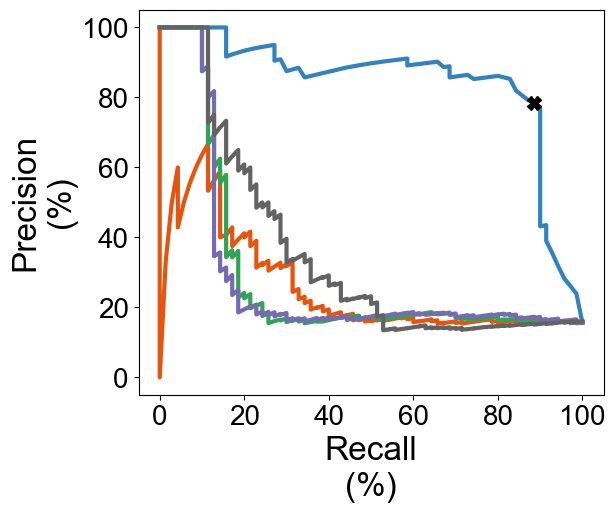

In [246]:
sp.pr_curves( ( wide.loc[ ( wide.pos >= 1123 ) & ( wide.pos <= 1272 ) ]
             [ [ 'pos', 'alt', 'ref', 'sdv', 'DS_max', 'ke_chgMEAN_abs', 'hal_chgPER_abs', 'spanr_chgZPER_abs', 'mmsplice_chgPERlogit_abs' ] ]
             .groupby( [ 'pos', 'alt', 'ref', 'sdv' ] )
             .agg( np.nanmean )
             .reset_index()
           ),
           'sdv', 
           [ 'DS_max', 'ke_chgMEAN_abs', 'hal_chgPER_abs', 'spanr_chgZPER_abs', 'mmsplice_chgPERlogit_abs' ], 
           [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ],
           fig_size = ( 6, 5 ),
           add_point = ( 100*( recall ), 100*( precision ), 'X', 10 ),
           linewidth = 3,
           savefile = plot_out + 'exon_PR.pdf',
         )

In [247]:
#sensitivity/recall
recall = \
( wide.loc[ ( wide.pos >= 1123 ) & ( wide.pos <= 1272 ) & ( wide.intmed_sdv ) & ( wide.DS_max >= .18 ) ]
  [ [ 'pos', 'alt', 'ref', 'DS_max'] ]
  .groupby( [ 'pos', 'alt', 'ref', ] )
  .agg( np.nanmean )
  .reset_index() ).shape[ 0 ] \
/ ( wide.loc[ ( wide.pos >= 1123 ) & ( wide.pos <= 1272 ) & ( wide.intmed_sdv ) ]
  [ [ 'pos', 'alt', 'ref', 'DS_max'] ]
  .groupby( [ 'pos', 'alt', 'ref', ] )
  .agg( np.nanmean )
  .reset_index() ).shape[ 0 ]

In [248]:
#precision
precision = \
( wide.loc[ ( wide.pos >= 1123 ) & ( wide.pos <= 1272 ) & ( wide.intmed_sdv ) & ( wide.DS_max >= .18 ) ]
  [ [ 'pos', 'alt', 'ref', 'DS_max'] ]
  .groupby( [ 'pos', 'alt', 'ref', ] )
  .agg( np.nanmean )
  .reset_index() ).shape[ 0 ] \
/ ( wide.loc[ ( wide.pos >= 1123 ) & ( wide.pos <= 1272 ) & ( wide.DS_max >= .18 ) ]
  [ [ 'pos', 'alt', 'ref', 'DS_max'] ]
  .groupby( [ 'pos', 'alt', 'ref', ] )
  .agg( np.nanmean )
  .reset_index() ).shape[ 0 ]

DS_max 0.8194157182688193
ke_chgMEAN_abs 0.3587095004057985
hal_chgPER_abs 0.35696142838491757
spanr_chgZPER_abs 0.33030685405008264
mmsplice_chgPERlogit_abs 0.40451082959835233


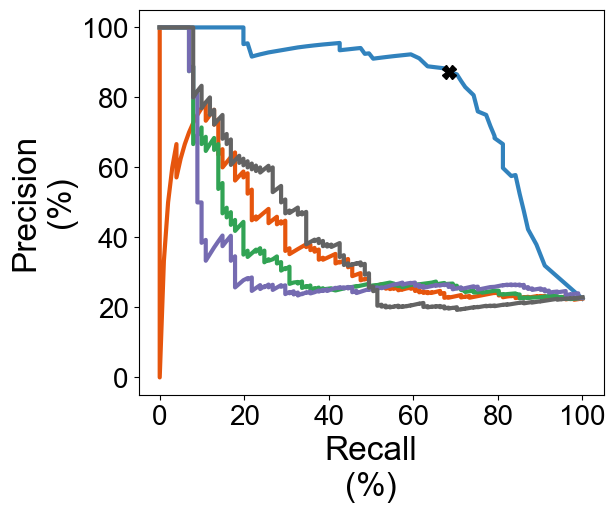

In [249]:
sp.pr_curves( ( wide.loc[ ( wide.pos >= 1123 ) & ( wide.pos <= 1272 ) ]
             [ [ 'pos', 'alt', 'ref', 'intmed_sdv', 'DS_max', 'ke_chgMEAN_abs', 'hal_chgPER_abs', 
                'spanr_chgZPER_abs', 'mmsplice_chgPERlogit_abs' ] ]
             .groupby( [ 'pos', 'alt', 'ref', 'intmed_sdv' ] )
             .agg( np.nanmean )
             .reset_index()
           ),
           'intmed_sdv', 
           [ 'DS_max', 'ke_chgMEAN_abs', 'hal_chgPER_abs', 'spanr_chgZPER_abs', 'mmsplice_chgPERlogit_abs' ], 
           [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ],
           fig_size = ( 6, 5 ),
           add_point = ( 100*( recall ), 100*( precision ), 'X', 10 ),
           linewidth = 3,
           savefile = plot_out + 'exon_intmed_PR.pdf',
         )

In [250]:
#sensitivity/recall
recall = \
( wide.loc[ ( ( wide.pos < 1123 ) | ( wide.pos > 1272 ) ) & ( wide.sdv ) & ( wide.DS_max >= .18 ) ]
  [ [ 'pos', 'alt', 'ref', 'DS_max'] ]
  .groupby( [ 'pos', 'alt', 'ref', ] )
  .agg( np.nanmean )
  .reset_index() ).shape[ 0 ] \
/ ( wide.loc[ ( ( wide.pos < 1123 ) | ( wide.pos > 1272 ) ) & ( wide.sdv ) ]
  [ [ 'pos', 'alt', 'ref', 'DS_max'] ]
  .groupby( [ 'pos', 'alt', 'ref', ] )
  .agg( np.nanmean )
  .reset_index() ).shape[ 0 ]

In [251]:
#precision
precision = \
( wide.loc[ ( ( wide.pos < 1123 ) | ( wide.pos > 1272 ) ) & ( wide.sdv ) & ( wide.DS_max >= .18 ) ]
  [ [ 'pos', 'alt', 'ref', 'DS_max'] ]
  .groupby( [ 'pos', 'alt', 'ref', ] )
  .agg( np.nanmean )
  .reset_index() ).shape[ 0 ] \
/ ( wide.loc[ ( ( wide.pos < 1123 ) | ( wide.pos > 1272 ) ) & ( wide.DS_max >= .18 ) ]
  [ [ 'pos', 'alt', 'ref', 'DS_max'] ]
  .groupby( [ 'pos', 'alt', 'ref', ] )
  .agg( np.nanmean )
  .reset_index() ).shape[ 0 ]

DS_max 0.66282784350811
spanr_chgZPER_abs 0.5490051843269261
Missing values in mmsplice_chgPERlogit_abs column. 256 rows removed.
mmsplice_chgPERlogit_abs 0.5847400581433566


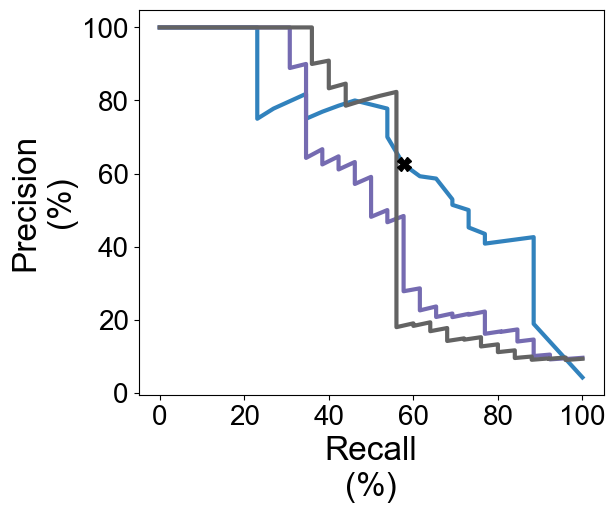

In [252]:
sp.pr_curves( ( wide.loc[ ( ( wide.pos < 1123 ) | ( wide.pos > 1272 ) ) ]
             [ [ 'pos', 'alt', 'ref', 'sdv', 'DS_max', 'ke_chgMEAN_abs', 'hal_chgPER_abs', 'spanr_chgZPER_abs', 'mmsplice_chgPERlogit_abs' ] ]
             .groupby( [ 'pos', 'alt', 'ref', 'sdv' ] )
             .agg( np.nanmean )
             .reset_index()
           ),
           'sdv', 
           [ 'DS_max', 'spanr_chgZPER_abs', 'mmsplice_chgPERlogit_abs' ], 
           [ light_colors[0], light_colors[12], light_colors[16] ],
           fig_size = ( 6, 5 ),
           add_point = ( 100*( recall ), 100*( precision ), 'X', 10 ),
           linewidth = 3,
           savefile = plot_out + 'intron_PR.pdf'
         )

In [253]:
#sensitivity/recall
recall = \
( wide.loc[ ( ( wide.pos < 1123 ) | ( wide.pos > 1272 ) ) & ( wide.intmed_sdv ) & ( wide.DS_max >= .18 ) ]
  [ [ 'pos', 'alt', 'ref', 'DS_max'] ]
  .groupby( [ 'pos', 'alt', 'ref', ] )
  .agg( np.nanmean )
  .reset_index() ).shape[ 0 ] \
/ ( wide.loc[ ( ( wide.pos < 1123 ) | ( wide.pos > 1272 ) ) & ( wide.intmed_sdv ) ]
  [ [ 'pos', 'alt', 'ref', 'DS_max'] ]
  .groupby( [ 'pos', 'alt', 'ref', ] )
  .agg( np.nanmean )
  .reset_index() ).shape[ 0 ]

In [254]:
#precision
precision = \
( wide.loc[ ( ( wide.pos < 1123 ) | ( wide.pos > 1272 ) ) & ( wide.intmed_sdv ) & ( wide.DS_max >= .18 ) ]
  [ [ 'pos', 'alt', 'ref', 'DS_max'] ]
  .groupby( [ 'pos', 'alt', 'ref', ] )
  .agg( np.nanmean )
  .reset_index() ).shape[ 0 ] \
/ ( wide.loc[ ( ( wide.pos < 1123 ) | ( wide.pos > 1272 ) ) & ( wide.DS_max >= .18 ) ]
  [ [ 'pos', 'alt', 'ref', 'DS_max'] ]
  .groupby( [ 'pos', 'alt', 'ref', ] )
  .agg( np.nanmean )
  .reset_index() ).shape[ 0 ]

DS_max 0.7047659625781462
spanr_chgZPER_abs 0.5152409887637722
Missing values in mmsplice_chgPERlogit_abs column. 256 rows removed.
mmsplice_chgPERlogit_abs 0.5702088693989115


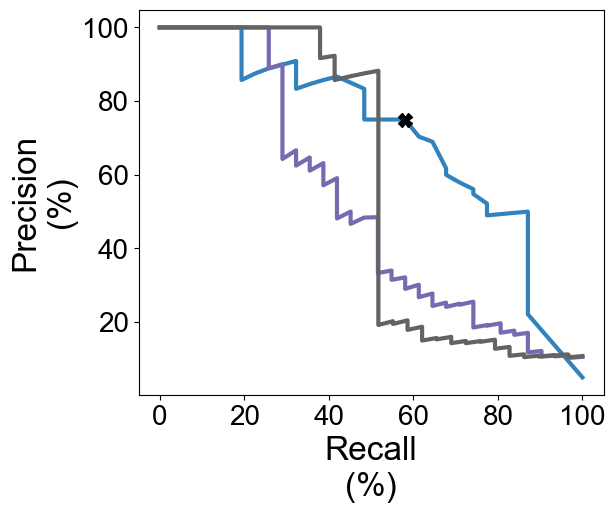

In [255]:
sp.pr_curves( ( wide.loc[ ( ( wide.pos < 1123 ) | ( wide.pos > 1272 ) ) ]
             [ [ 'pos', 'alt', 'ref', 'intmed_sdv', 'DS_max', 'ke_chgMEAN_abs', 'hal_chgPER_abs', 
                'spanr_chgZPER_abs', 'mmsplice_chgPERlogit_abs' ] ]
             .groupby( [ 'pos', 'alt', 'ref', 'intmed_sdv' ] )
             .agg( np.nanmean )
             .reset_index()
           ),
           'intmed_sdv', 
           [ 'DS_max', 'spanr_chgZPER_abs', 'mmsplice_chgPERlogit_abs' ], 
           [ light_colors[0], light_colors[12], light_colors[16] ],
           fig_size = ( 6, 5 ),
           add_point = ( 100*( recall ), 100*( precision ), 'X', 10 ),
           linewidth = 3,
           savefile = plot_out + 'intron_intmed_PR.pdf'
         )

fc_1.0 0.7588537918634948
fc_1.5 0.7697023880303164
fc_2.0 0.7882762355380217
fc_2.5 0.7682088600190964
fc_3.0 0.7866147163741264
fc_3.5 0.7999642963500727
fc_4.0 0.7865046750923248
fc_4.5 0.6421639489074912
fc_5.0 0.6497278548619893


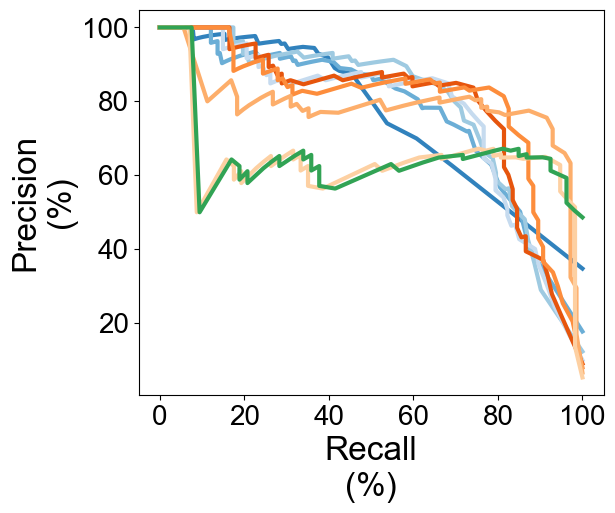

In [256]:
sdv_cols = [ 'fc_1.0', 'fc_1.5', 'fc_2.0', 'fc_2.5', 'fc_3.0', 'fc_3.5', 'fc_4.0', 'fc_4.5', 'fc_5.0' ]
sp.pr_curves_bytruth( ( wide
             [ [ 'pos', 'alt', 'ref', 'DS_max' ] + sdv_cols ]
             .groupby( [ 'pos', 'alt', 'ref' ] )
             .agg( np.nanmean )
             .reset_index()
           ),
           sdv_cols, 
           'DS_max', 
           light_colors,
           fig_size = ( 6, 5 ),
           linewidth = 3,
           savefile = plot_out + 'fc_thresh_PR.pdf'
         )

In [257]:
aucs = [ 0.7588537918634948, 0.7697023880303164, 0.7882762355380217, 0.7682088600190964, 0.7866147163741264, 
        0.7999642963500727, 0.7865046750923248, 0.6421639489074912, 0.6497278548619893 ]

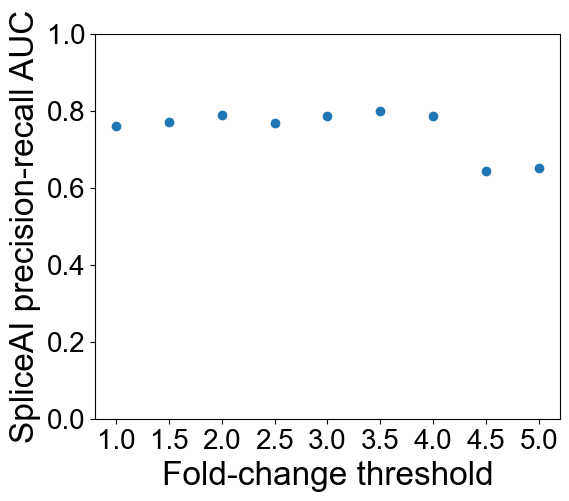

In [258]:
plt.figure( figsize = ( 6, 5 ) )
    
plt.scatter( np.arange( 1.0, 5.1, .5 ), aucs )          
        
plt.xlabel( 'Fold-change threshold', fontsize = 24 )
plt.xticks( fontsize = 20 )
    
plt.ylabel( 'SpliceAI precision-recall AUC', fontsize = 24 )
plt.yticks( fontsize = 20 )

plt.ylim( (0,1) )

plt.savefig( plot_out + 'auc_fc_scatter.pdf', 
            dpi = 300,
            bbox_inches = 'tight' )

plt.show()


Supp Figure 11

In [259]:
zrbp_wt_cols = [ col for col in wide if '_wtMAX' in col ]

In [260]:
motifs = [ rbp[ : -len( '_wtMAX' ) ] for rbp in zrbp_wt_cols ]

In [261]:
rbp_info

RBP_ID Family_ID RSource_ID  Motif_ID MSource_ID        DBID  \
0      T00001_0.6   F01_0.6   TS07_0.6         .          .  AMAG_14572   
1      T00002_0.6   F01_0.6   TS07_0.6         .          .  AMAG_15521   
2      T00003_0.6   F01_0.6   TS07_0.6         .          .  AMSG_02404   
3      T00004_0.6   F01_0.6   TS07_0.6         .          .  SPRG_08635   
4      T00005_0.6   F01_0.6   TS79_0.6         .          .      146232   
...           ...       ...        ...       ...        ...         ...   
62689  T62583_0.6   F55_0.6   TS92_0.6         .          .    AAH60445   
62690  T62584_0.6   F55_0.6   TS92_0.6         .          .    AAH68959   
62691  T62585_0.6   F55_0.6   TS92_0.6         .          .    AAH78013   
62692  T62586_0.6   F55_0.6   TS92_0.6         .          .    AAH81017   
62693  T62587_0.6   F55_0.6   TS92_0.6  M354_0.6    MS1_0.6    AAH84321   

         RBP_Name             RBP_Species RBP_Status      Family_Name  ...  \
0      AMAG_14572    Allomyces_macrogynus          N  C2H2 ZF,CCCH ZF  ...   
1      AMAG_15521    Allomyces_macrogynus          N  C2H2 ZF,CCCH ZF  ...   
2      AMSG_02404      Thecamonas_trahens          N  C2H2 ZF,CCCH ZF  ...   
3      SPRG_08635  Saprolegnia_parasitica          N  C2H2 ZF,CCCH ZF  ...   
4          146232      Helobdella_robusta          N  C2H2 ZF,CCCH ZF  ...   
...           ...                     ...        ...              ...  ...   
62689    AAH60445          Xenopus_laevis          N              YTH  ...   
62690    AAH68959          Xenopus_laevis          N              YTH  ...   
62691    AAH78013          Xenopus_laevis          N              YTH  ...   
62692    AAH81017          Xenopus_laevis          N              YTH  ...   
62693    AAH84321          Xenopus_laevis          I              YTH  ...   

      MSource_Type  MSource_Author  MSource_Year      PMID MSource_Version  \
0                .               .             .         .               .   
1                .               .             .         .               .   
2                .               .             .         .               .   
3                .               .             .         .               .   
4                .               .             .         .               .   
...            ...             ...           ...       ...             ...   
62689            .               .             .         .               .   
62690            .               .             .         .               .   
62691            .               .             .         .               .   
62692            .               .             .         .               .   
62693        RBPDB            Cook          2011  21036867          v1.2.1   

      RBPSource_Name                   RBPSource_URL RBPSource_Year  \
0              Broad  http://www.broadinstitute.org/           2011   
1              Broad  http://www.broadinstitute.org/           2011   
2              Broad  http://www.broadinstitute.org/           2011   
3              Broad  http://www.broadinstitute.org/           2011   
4                JGI      http://genome.jgi-psf.org/           2010   
...              ...                             ...            ...   
62689        Xenbase  http://www.xenbase.org/common/           2010   
62690        Xenbase  http://www.xenbase.org/common/           2010   
62691        Xenbase  http://www.xenbase.org/common/           2010   
62692        Xenbase  http://www.xenbase.org/common/           2010   
62693        Xenbase  http://www.xenbase.org/common/           2010   

      RBPSource_Month RBPSource_Day  
0                 Oct            27  
1                 Oct            27  
2                 Oct            27  
3                 Oct            27  
4                 Jan             8  
...               ...           ...  
62689             Oct            22  
62690             Oct            22  
62691             Oct            22  
626

In [262]:
rbp_info.loc[ rbp_info.RBP_Species == 'Homo_sapiens' ].set_index( 'Motif_ID' ).loc[ ( motifs ) ].RBP_Name

Motif_ID
M012_0.6     CPEB2
M031_0.6    ELAVL1
M077_0.6     U2AF2
M108_0.6    ELAVL1
M149_0.6     CPEB3
M149_0.6     CPEB4
M150_0.6      RALY
M156_0.6      TIA1
M232_0.6    ELAVL1
Name: RBP_Name, dtype: object

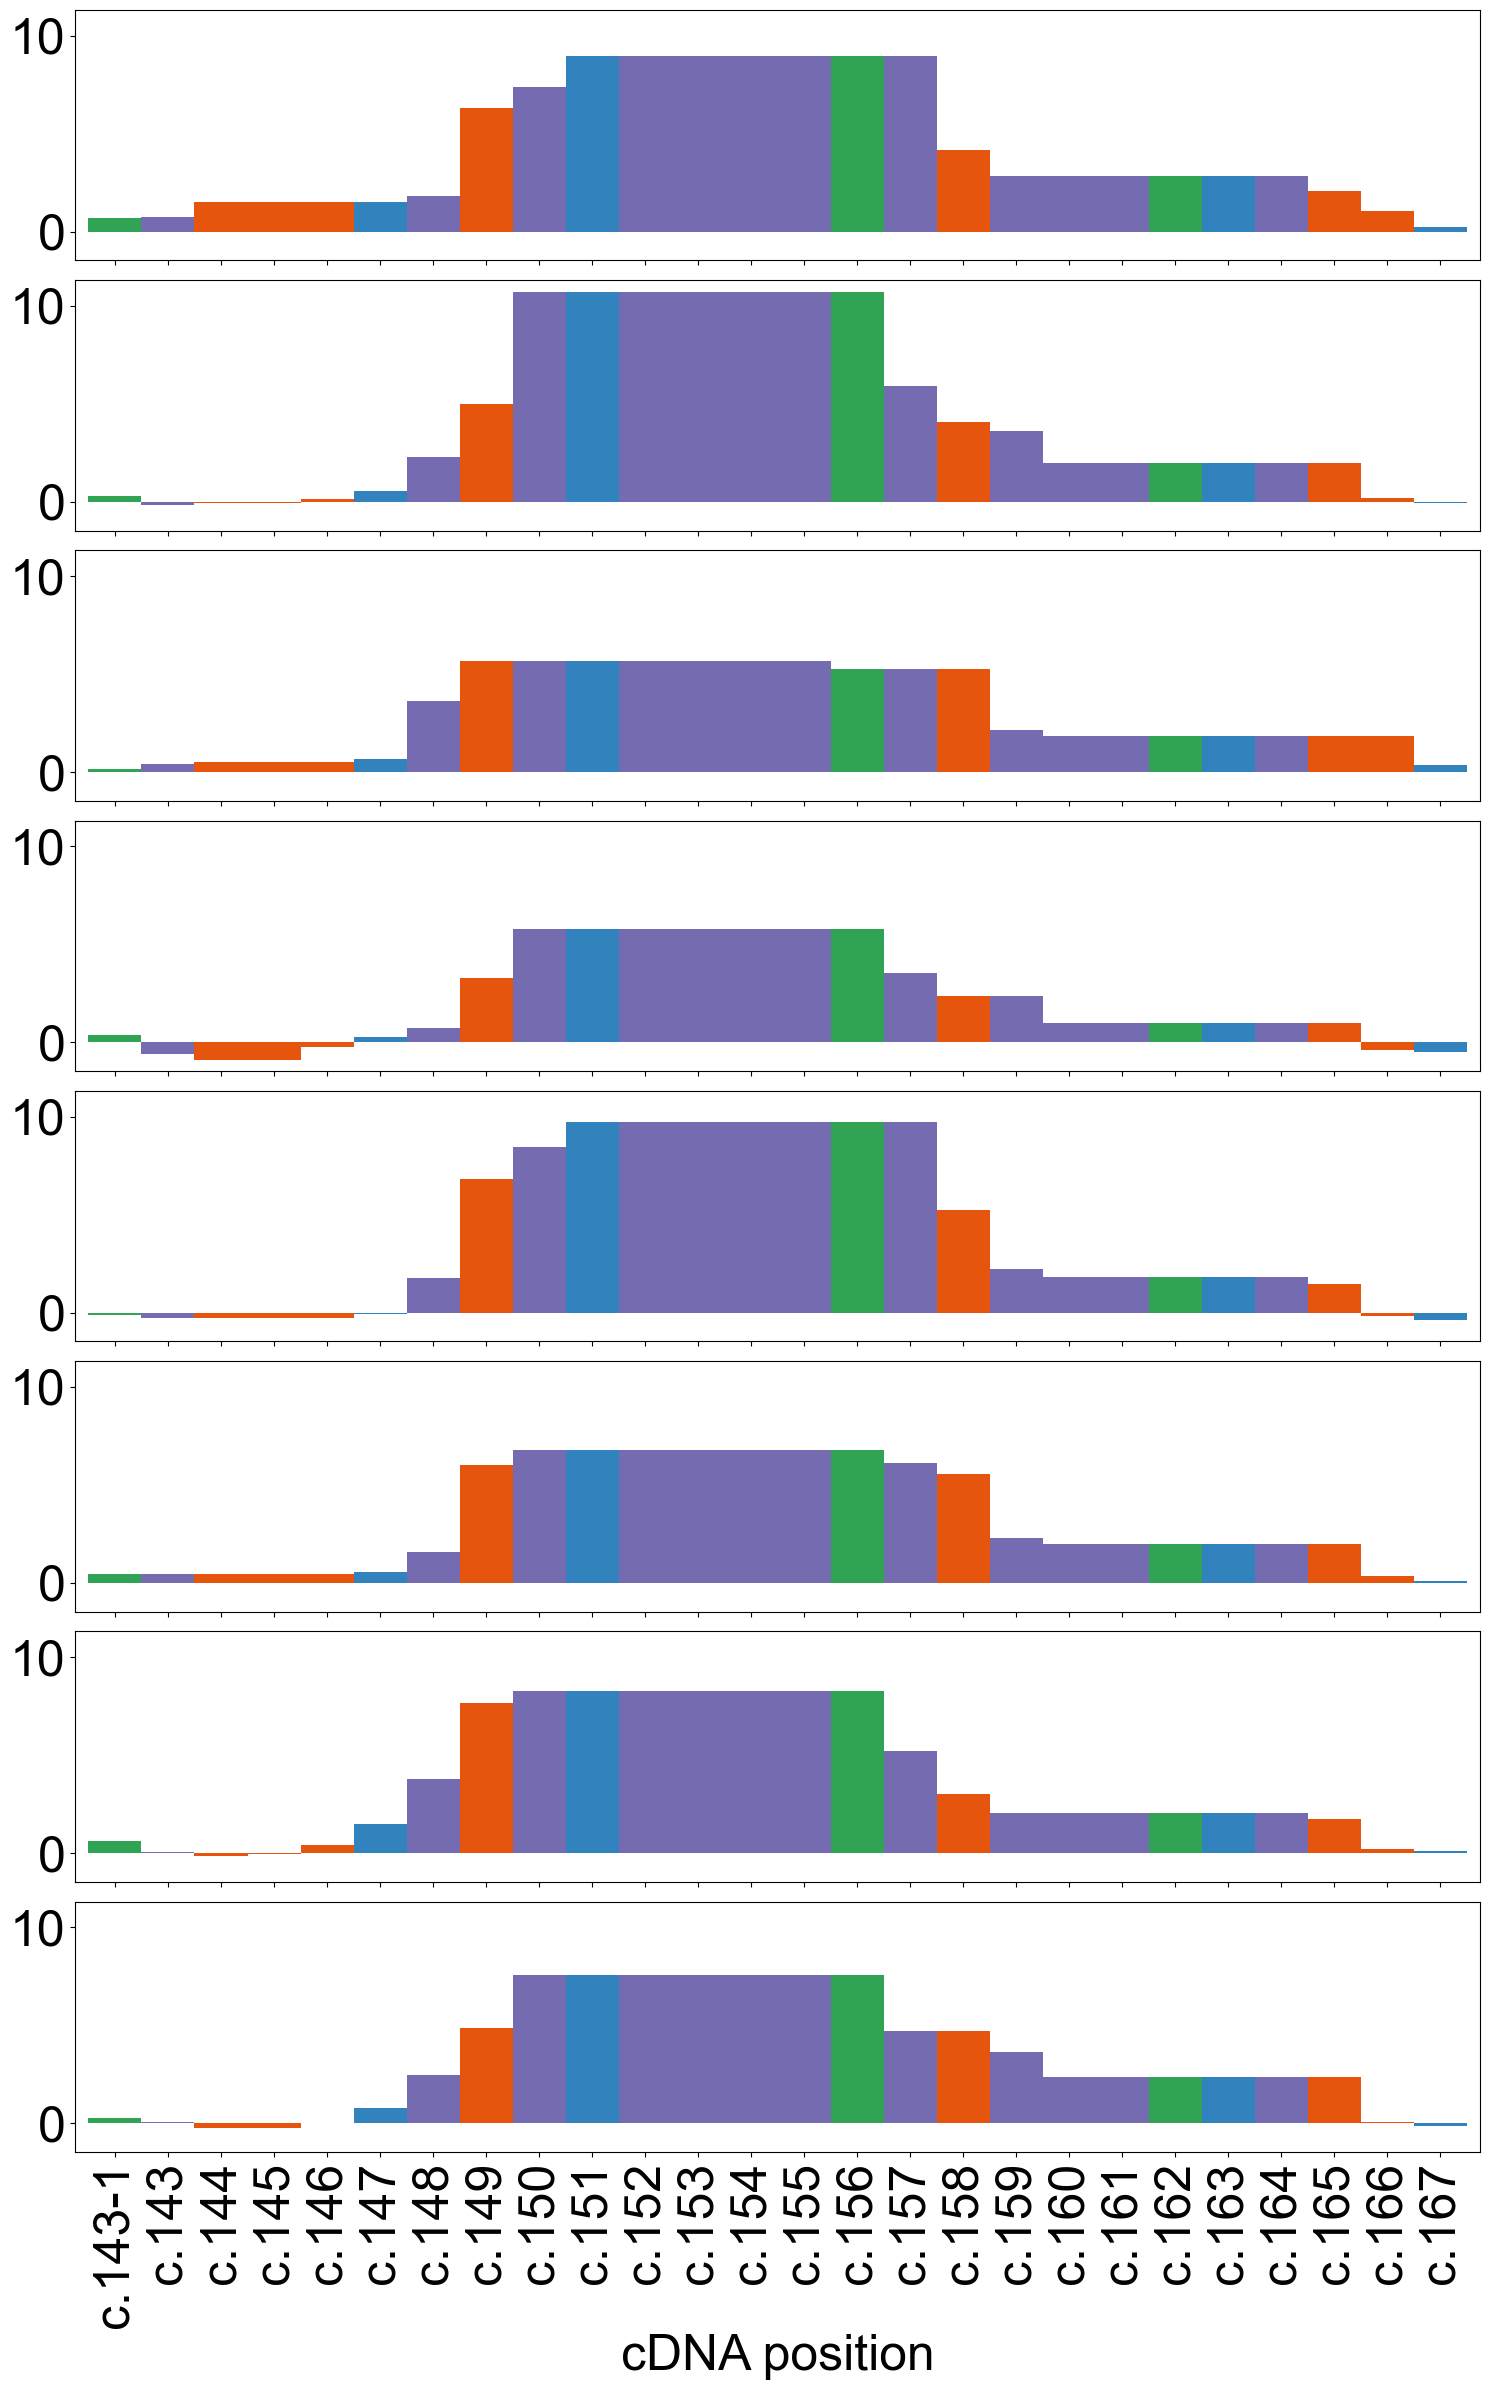

In [263]:
fig, axes = plt.subplots( len( zrbp_wt_cols),
                              sharex = True,
                              sharey = True, 
                              figsize = ( 15, 24 ) )

for ax, col in zip( axes, zrbp_wt_cols ):


    sp.subplot_psi_wt( ( wide[ [ 'pos', 'ref', 'hgvs_pos', col ] ]
                   .groupby( [ 'pos', 'ref', 'hgvs_pos' ] )
                   .agg( np.nanmean )
                   .reset_index() ),
                  col,
                 'hgvs_pos',
                  [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ],
                   ax = ax,
                  tick_spacing = 1,
                  zoom = ( 1122, 1147 ),
                  legend = False,
                  y_ax_title = '',
                  x_ax_title = 'cDNA position',
                     )

plt.savefig( plot_out + 'zrbp_wt.pdf', 
                     dpi = 300,
                     bbox_inches = 'tight' )

Supp Figure 12

In [264]:
zrbp_snv_cols = [ col for col in wide if '_chgMAX' in col ]

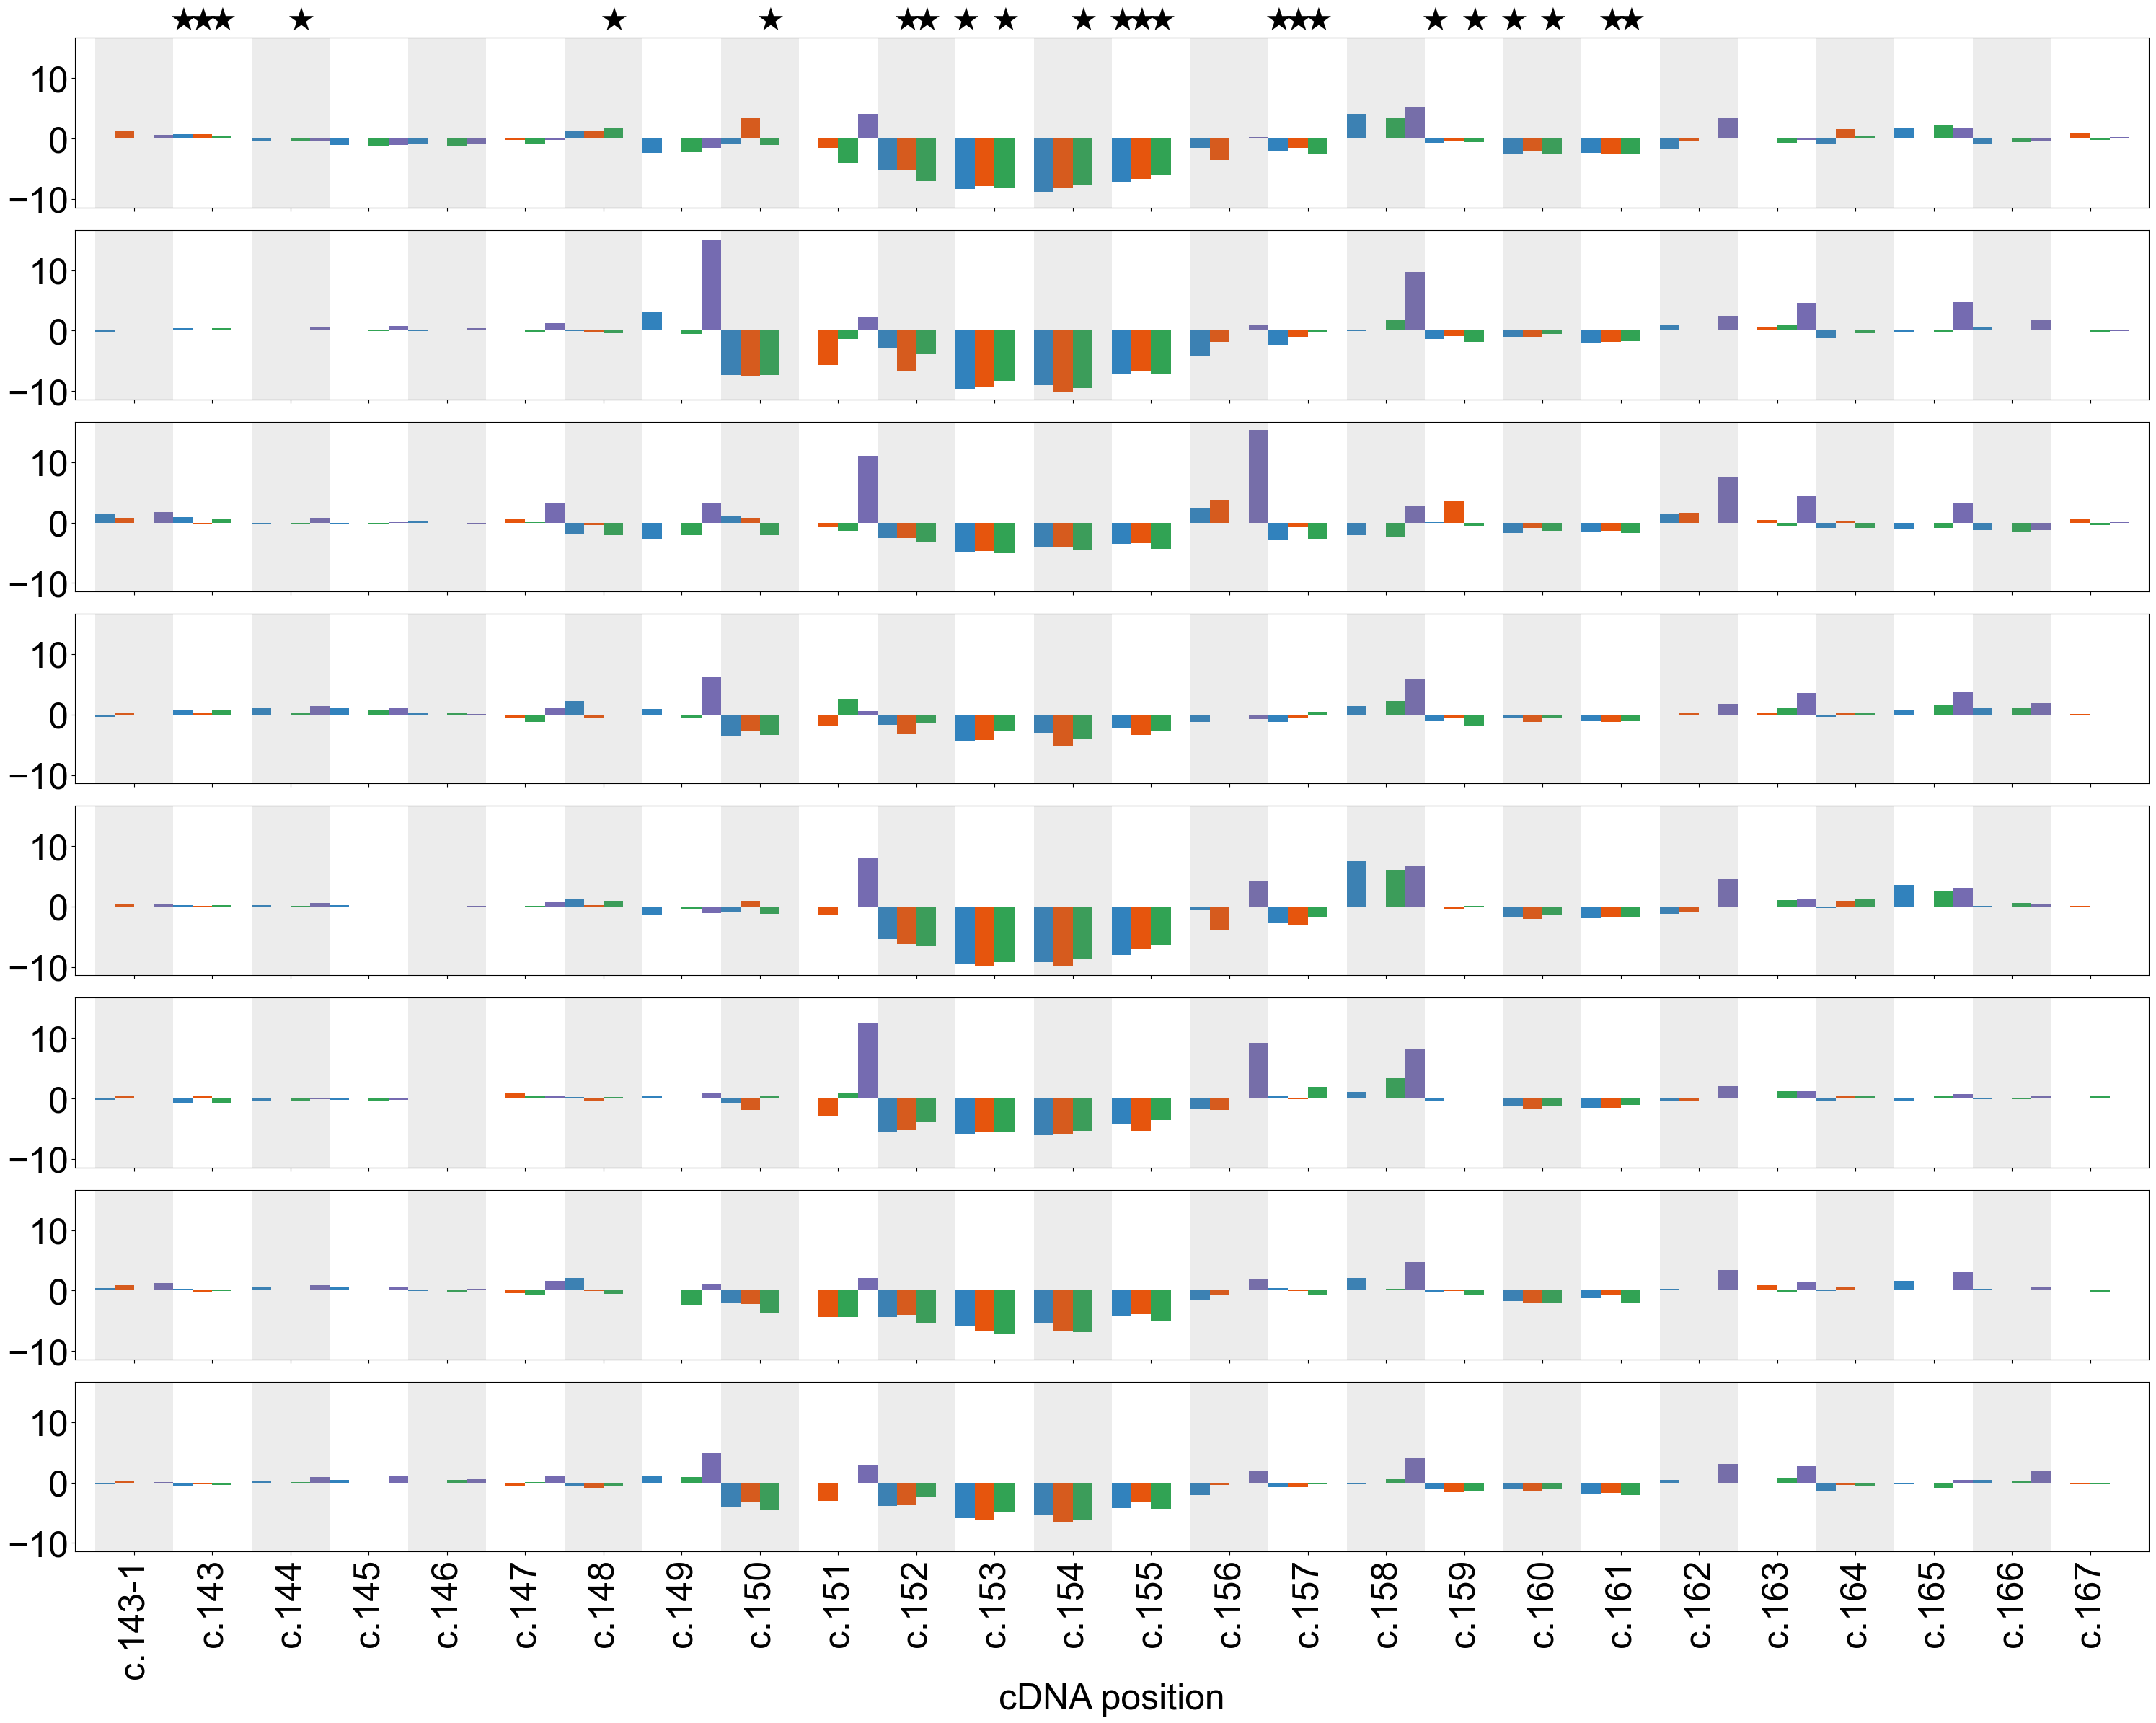

In [265]:
sp.subplots_wrapper( ( wide[ [ 'pos', 'alt', 'ref', 'hgvs_pos', 'sdv_BETA' ] + zrbp_snv_cols ]
                   .groupby( [ 'pos', 'alt', 'ref', 'hgvs_pos', 'sdv_BETA' ] )
                   .agg( np.nanmean )
                   .reset_index() ),
                  zrbp_snv_cols,
                 'hgvs_pos',
                  [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ],
                  tick_spacing = 1,
                  zoom = ( 1122, 1147 ),
                  fig_size = ( 30, 24 ),
                  bar_labels = [ ( 'sdv_BETA', r'$\bigstar$', 'junk', 32 ) ],
                  bar_label_loc = 'above',
                  bar_labels_offset = False,
                  legend = False,
                  y_ax_title = [ '', '', '', '', '', '', '', '', '' ],
                  x_ax_title = 'cDNA position',
                  shade_by_base = True,
                  savefile = plot_out + 'rbp_z_chg_allcol.pdf',
                     )

Supp Figure Z

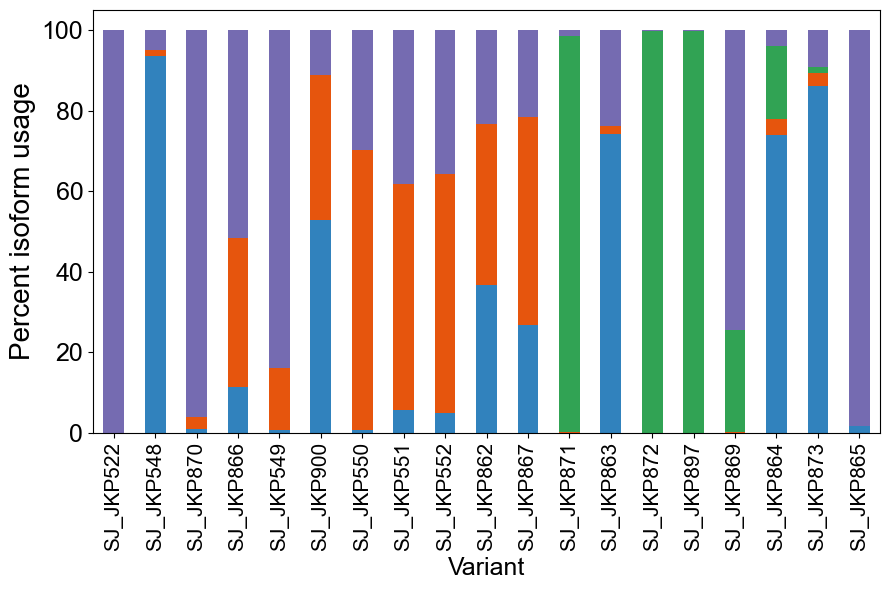

In [266]:
sp.plot_stacked_bar( valvars_df,
                     sorted( [ col for col in valvars_df if col.endswith( '_Norm' ) ] ), 
                     'sample',
                     sort_cols = [ 'pos' ],
                     y_ax_title = 'Percent isoform usage',
                     x_ax_title = 'Variant',
                     color = [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ],
                     figsize = ( 9, 6 ),
                     legend = False,
                     savefile = plot_out + 'valvars_jn_bar.pdf'
                   )

In [267]:
( wide.loc[ ( wide.val_var ) ][ [ 'pos', 'ref', 'alt', 'sdv_BETA', 'sdv_SKIP', 'sdv_OTHER', 
                                      'intmed_BETA', 'intmed_SKIP', 'intmed_OTHER' ] ]
  .groupby( [ 'pos', 'ref', 'alt' ] )
  .agg( np.nanmean )
  .reset_index()
  .dropna() 
)

pos ref alt  sdv_BETA  sdv_SKIP  sdv_OTHER  intmed_BETA  intmed_SKIP  \
0   1118   A   G      True     False      False        False         True   
1   1123   T   G      True     False      False        False        False   
2   1128   T   G      True     False      False        False         True   
3   1130   T   G      True     False      False        False        False   
4   1132   T   G      True     False      False        False         True   
5   1135   T   G      True     False      False        False         True   
6   1137   T   G      True     False      False        False         True   
7   1140   T   G      True     False      False        False         True   
8   1141   T   G      True     False      False        False        False   
9   1149   A   G     False     False       True        False        False   
10  1158   T   C     False     False      False        False         True   
11  1168   C   G     False     False       True        False        False   
12  1177   C   A     False     False       True        False        False   
13  1189   T   A     False     False       True        False         True   
14  1195   A   G     False     False       True        False        False   
15  1238   T   A     False     False      False        False        False   
16  1272   G   A     False      True      False        False        False   

    intmed_OTHER  
0          False  
1          False  
2          False  
3          False  
4          False  
5          False  
6          False  
7          False  
8          False  
9          False  
10         False  
11         False  
12         False  
13         False  
14         False  
15         False  
16         False

In [268]:
wide.to_csv( bdout + 'pou1f1_wide_revison.2021-0420.txt',
             sep = '\t',
             index = False )

Create supplemental table

In [269]:
wide = wide.sort_values( by = [ 'pos', 'alt' ] )

In [270]:
#all possible column options for the final table
for col in wide:
    print( col )

pos
ref
alt
chrom
gdna_pos_hg19
varlist
DS_accept_GAIN
DS_accept_LOSS
DS_donor_GAIN
DS_donor_LOSS
POS_accept_GAIN
POS_accept_LOSS
POS_donor_GAIN
POS_donor_LOSS
DS_max
DS_max_type
POS_max
gdna_pos_hg38
var_type
hgvs_pos
ref_aa
alt_aa
brep5_mm1_E4_sample
brep5_mm1_E4_n_bc
brep5_mm1_E4_n_bc_passfilt
brep5_mm1_E4_sum_reads
brep5_mm1_E4_sum_reads_passfilt
brep5_mm1_E4_sum_usable_reads
brep5_mm1_E4_sum_unmapped_reads
brep5_mm1_E4_sum_badstart_reads
brep5_mm1_E4_sum_badend_reads
brep5_mm1_E4_sum_softclipped_reads
brep5_mm1_E4_sum_otheriso
brep5_mm1_E4_mean_ALPHA
brep5_mm1_E4_mean_BETA
brep5_mm1_E4_mean_SKIP
brep5_mm1_E4_mean_OTHER
brep5_mm1_E4_wmean_ALPHA
brep5_mm1_E4_wmean_BETA
brep5_mm1_E4_wmean_SKIP
brep5_mm1_E4_wmean_OTHER
brep5_mm1_E4_median_ALPHA
brep5_mm1_E4_median_BETA
brep5_mm1_E4_median_SKIP
brep5_mm1_E4_median_OTHER
brep5_mm1_E4_n_bc_sa
brep5_mm1_E4_per_bc_passfilt
brep5_mm1_E4_per_reads_passfilt
brep5_mm1_E4_per_reads_usable
brep5_mm1_E4_per_unmapped
brep5_mm1_E4_per_badend
brep5_

In [271]:
#removed columns (from last time trying to condense more):
#'sa_sdv','DS_max','ke_chgMEAN', 'hal_chgPER', 'spanr_chgZPER', 'mmsplice_chgPERlogit', 'zwmean_NONALPHA_max', 'wt_acc', 'wt_don', 
#'n_bc','sdv_count','alt_don_pos', 'alt_wt_5ss_maxent', 'alt_snv_5ss_maxent','alt_5ss_maxent_chg', 'alt_acc_pos', 
#'alt_wt_3ss_maxent', 'alt_snv_3ss_maxent', 'alt_3ss_maxent_chg', 'sa_discord' 'gnomad_var'
#'psbl_snv_acc', 'psbl_snv_don','snv_acc', 'snv_don', frameshift_acc, frameshift_don
#+ [ samp + stem for samp in [ col[ :-10 ] for col in wide if 'sample_grp' in col ]
#for stem in [ 'n_bc', 'n_bc_passfilt', 'sum_reads', 'sum_reads_passfilt', 'wmean_ALPHA',
#'wmean_BETA', 'wmean_SKIP', 'wmean_OTHER', 'zwmean_ALPHA',
#'zwmean_BETA', 'zwmean_SKIP', 'zwmean_OTHER', 'gene', 'transcript', ' ] ]

In [272]:
supp_tbl = wide[ [ 'chrom', 'gdna_pos_hg19', 'gdna_pos_hg38', 'hgvs_pos', 'pos', 'ref', 'alt',
                  'var_type', 'prot_con',
                  'sdv', 'sdv_BETA', 'sdv_SKIP', 'sdv_OTHER', 
                  'intmed', 'intmed_BETA', 'intmed_SKIP', 'intmed_OTHER',
                  'n_bc_passfilt', 
                 'wmean_ALPHA', 'wmean_BETA', 'wmean_SKIP', 'wmean_OTHER', 
                  'zwmean_ALPHA', 'zwmean_BETA','zwmean_SKIP', 'zwmean_OTHER', 
                  'fc_ALPHA', 'fc_BETA', 'fc_SKIP', 'fc_OTHER', 
                  'patient_var', 'DS_max', 'af_v2', 'af_v3' ] ]

In [273]:
supp_tbl

chrom  gdna_pos_hg19  gdna_pos_hg38   hgvs_pos   pos ref alt  var_type  \
0         3       87322725       87273575   c.143-79  1044   G   A  Intronic   
1         3       87322725       87273575   c.143-79  1044   G   C  Intronic   
2         3       87322725       87273575   c.143-79  1044   G   T  Intronic   
3         3       87322724       87273574   c.143-78  1045   T   A  Intronic   
4         3       87322724       87273574   c.143-78  1045   T   C  Intronic   
...     ...            ...            ...        ...   ...  ..  ..       ...   
1488      3       87322367       87273217  c.292+130  1402   A   G  Intronic   
1489      3       87322367       87273217  c.292+130  1402   A   T  Intronic   
1490      3       87322366       87273216  c.292+131  1403   T   A  Intronic   
1491      3       87322366       87273216  c.292+131  1403   T   C  Intronic   
1492      3       87322366       87273216  c.292+131  1403   T   G  Intronic   

     prot_con    sdv  ...  zwmean_SKIP  zwmean_OTHER  fc_ALPHA   fc_BETA  \
0         NaN  False  ...    -1.333288      0.062385  1.010217  0.990861   
1         NaN  False  ...     1.179523     -0.552119  0.996541  0.807981   
2         NaN  False  ...    -0.884640     -0.598380  1.003773  1.017886   
3         NaN  False  ...     0.218656      0.683356  0.999507  0.945119   
4         NaN  False  ...     2.658964      0.864135  0.990248  0.836470   
...       ...    ...  ...          ...           ...       ...       ...   
1488      NaN  False  ...     3.621093     -2.580733  0.978926  0.858527   
1489      NaN  False  ...     0.323489      0.226529  1.000445  0.486038   
1490      NaN  False  ...    -1.783718      0.944563  1.013588  1.050261   
1491      NaN  False  ...    -2.739009      1.256383  1.007600  1.104683   
1492      NaN  False  ...    -5.473791     -0.195480  1.032263  1.148101   

       fc_SKIP  fc_OTHER  patient_var  DS_max  af_v2     af_v3  
0     0.960562  1.064527        False     0.0    NaN  0.000007  
1     1.023970  0.983586        False     0.0    NaN       NaN  
2     0.963876  0.919071        False     0.0    NaN       NaN  
3     1.015198  1.050861        False     0.0    NaN       NaN  
4     1.042458  1.048109        False     0.0    NaN  0.000007  
...        ...       ...          ...     ...    ...       ...  
1488  1.097778  0.659884        False     0.0    NaN       NaN  
1489  0.980623  0.899130        False     0.0    NaN       NaN  
1490  0.956781  0.968304        False     0.0    NaN       NaN  
1491  0.898456  1.201328        False     0.0    NaN       NaN  
1492  0.887403  1.011241        False     0.0    NaN       NaN  

[1493 rows x 34 columns]

In [274]:
supp_tbl = supp_tbl.drop_duplicates( ignore_index = False )

In [275]:
supp_tbl

chrom  gdna_pos_hg19  gdna_pos_hg38   hgvs_pos   pos ref alt  var_type  \
0         3       87322725       87273575   c.143-79  1044   G   A  Intronic   
1         3       87322725       87273575   c.143-79  1044   G   C  Intronic   
2         3       87322725       87273575   c.143-79  1044   G   T  Intronic   
3         3       87322724       87273574   c.143-78  1045   T   A  Intronic   
4         3       87322724       87273574   c.143-78  1045   T   C  Intronic   
...     ...            ...            ...        ...   ...  ..  ..       ...   
1488      3       87322367       87273217  c.292+130  1402   A   G  Intronic   
1489      3       87322367       87273217  c.292+130  1402   A   T  Intronic   
1490      3       87322366       87273216  c.292+131  1403   T   A  Intronic   
1491      3       87322366       87273216  c.292+131  1403   T   C  Intronic   
1492      3       87322366       87273216  c.292+131  1403   T   G  Intronic   

     prot_con    sdv  ...  zwmean_SKIP  zwmean_OTHER  fc_ALPHA   fc_BETA  \
0         NaN  False  ...    -1.333288      0.062385  1.010217  0.990861   
1         NaN  False  ...     1.179523     -0.552119  0.996541  0.807981   
2         NaN  False  ...    -0.884640     -0.598380  1.003773  1.017886   
3         NaN  False  ...     0.218656      0.683356  0.999507  0.945119   
4         NaN  False  ...     2.658964      0.864135  0.990248  0.836470   
...       ...    ...  ...          ...           ...       ...       ...   
1488      NaN  False  ...     3.621093     -2.580733  0.978926  0.858527   
1489      NaN  False  ...     0.323489      0.226529  1.000445  0.486038   
1490      NaN  False  ...    -1.783718      0.944563  1.013588  1.050261   
1491      NaN  False  ...    -2.739009      1.256383  1.007600  1.104683   
1492      NaN  False  ...    -5.473791     -0.195480  1.032263  1.148101   

       fc_SKIP  fc_OTHER  patient_var  DS_max  af_v2     af_v3  
0     0.960562  1.064527        False     0.0    NaN  0.000007  
1     1.023970  0.983586        False     0.0    NaN       NaN  
2     0.963876  0.919071        False     0.0    NaN       NaN  
3     1.015198  1.050861        False     0.0    NaN       NaN  
4     1.042458  1.048109        False     0.0    NaN  0.000007  
...        ...       ...          ...     ...    ...       ...  
1488  1.097778  0.659884        False     0.0    NaN       NaN  
1489  0.980623  0.899130        False     0.0    NaN       NaN  
1490  0.956781  0.968304        False     0.0    NaN       NaN  
1491  0.898456  1.201328        False     0.0    NaN       NaN  
1492  0.887403  1.011241        False     0.0    NaN       NaN  

[1070 rows x 34 columns]

In [276]:
supp_tbl.to_csv( bdout +'supp_tbl.2021-0420.txt',
                 sep = ',',
                 index = False )

In [277]:
geo_tbl_byvar = wide[ [ 'chrom', 'gdna_pos_hg19', 'gdna_pos_hg38', 'hgvs_pos', 'pos', 'ref', 'alt',
                  'var_type', 'prot_con',
                  'sdv', 'sdv_BETA', 'sdv_SKIP', 'sdv_OTHER', 
                  'intmed', 'intmed_BETA', 'intmed_SKIP', 'intmed_OTHER',
                  'n_bc_passfilt', 
                 'wmean_ALPHA', 'wmean_BETA', 'wmean_SKIP', 'wmean_OTHER', 
                  'zwmean_ALPHA', 'zwmean_BETA','zwmean_SKIP', 'zwmean_OTHER', 
                  'fc_BETA', 'fc_SKIP', 'fc_OTHER', 
                  'patient_var', 'DS_max', 'af_v2', 'af_v3' ]
               + [ samp + '_' + stem for samp in samples
                   for stem in [ 'n_bc', 'n_bc_passfilt', 'sum_reads', 'sum_reads_passfilt', 
                                 'wmean_ALPHA', 'wmean_BETA', 'wmean_SKIP', 'wmean_OTHER', 
                                 'zwmean_ALPHA', 'zwmean_BETA', 'zwmean_SKIP', 'zwmean_OTHER',
                                 'fc_ALPHA', 'fc_BETA', 'fc_SKIP', 'fc_OTHER' ] ] ]

In [278]:
geo_tbl_byvar = geo_tbl_byvar.drop_duplicates( ignore_index = False )

In [279]:
geo_tbl_byvar

chrom  gdna_pos_hg19  gdna_pos_hg38   hgvs_pos   pos ref alt  var_type  \
0         3       87322725       87273575   c.143-79  1044   G   A  Intronic   
1         3       87322725       87273575   c.143-79  1044   G   C  Intronic   
2         3       87322725       87273575   c.143-79  1044   G   T  Intronic   
3         3       87322724       87273574   c.143-78  1045   T   A  Intronic   
4         3       87322724       87273574   c.143-78  1045   T   C  Intronic   
...     ...            ...            ...        ...   ...  ..  ..       ...   
1488      3       87322367       87273217  c.292+130  1402   A   G  Intronic   
1489      3       87322367       87273217  c.292+130  1402   A   T  Intronic   
1490      3       87322366       87273216  c.292+131  1403   T   A  Intronic   
1491      3       87322366       87273216  c.292+131  1403   T   C  Intronic   
1492      3       87322366       87273216  c.292+131  1403   T   G  Intronic   

     prot_con    sdv  ...  brep3_mm2_C10_wmean_SKIP  \
0         NaN  False  ...                  0.129283   
1         NaN  False  ...                  0.121922   
2         NaN  False  ...                  0.147420   
3         NaN  False  ...                  0.133203   
4         NaN  False  ...                  0.142487   
...       ...    ...  ...                       ...   
1488      NaN  False  ...                  0.142061   
1489      NaN  False  ...                  0.172185   
1490      NaN  False  ...                  0.159357   
1491      NaN  False  ...                  0.111111   
1492      NaN  False  ...                  0.125811   

      brep3_mm2_C10_wmean_OTHER  brep3_mm2_C10_zwmean_ALPHA  \
0                      0.042056                    0.549097   
1                      0.039039                    1.942915   
2                      0.035217                   -0.397416   
3                      0.043095                    0.266084   
4                      0.041451                   -0.252099   
...                         ...                         ...   
1488                   0.061281                   -1.037557   
1489                   0.026490                   -0.825055   
1490                   0.036550                   -0.538102   
1491                   0.047222                    0.752197   
1492                   0.045396                   -0.033747   

      brep3_mm2_C10_zwmean_BETA  brep3_mm2_C10_zwmean_SKIP  \
0                     -0.249799                  -0.897813   
1                     -1.655444                  -1.636221   
2                      0.122844                   0.616117   
3                     -0.584291                  -0.423074   
4                     -0.615165                   0.261938   
...                         ...                        ...   
1488                  -0.448751                   0.159179   
1489                   0.733046                   0.965627   
1490                  -1.230126                   1.232692   
1491                   0.241307                  -1.453595   
1492                   1.167807                  -0.988266   

      brep3_mm2_C10_zwmean_OTHER  brep3_mm2_C10_fc_ALPHA  \
0                       0.664605                1.009234   
1                       0.195234                1.029695   
2                      -0.385578                0.992571   
3                       0.649662                1.005753   
4                       0.527570                0.995585   
...                          ...                     ...   
1488                    2.312416                0.971785   
1489                   -0.610795                0.958741   
1490                   -0.159318                0.987511   
1491                    0.853664                1.021530   
1492                    1.026487                0.999319   

      brep3_mm2_C10_fc_BETA  brep3_mm2_C10_fc_SKIP  brep3_mm2_C10_fc_OTHER  
0                  0.948097               0.926554                1.106835  
1      

In [280]:
geo_tbl_byvar.to_csv( bdout +'geo_tbl_byvar.2021-0420.txt',
                 sep = '\t',
                 index = False )

In [281]:
og_bc_long = pd.read_table( bdout + 'og_samples/og_pou1f1_by_bc_effects_allvars-20200827.txt' )

In [282]:
og_bc_long

barcode               sample  passes          refname  \
0       GTTGCCTATAGTGTCTTTTGTGG  pool_rep1_alt_fixed    True  pspl3_pou1f1_bc   
1       GTTGCCTCCGGCGGTTTAGATGG  pool_rep1_alt_fixed    True  pspl3_pou1f1_bc   
2       GTTGCCTGCAGGATCAATTTTGG  pool_rep1_alt_fixed    True  pspl3_pou1f1_bc   
3       GTTGCCTGTCTTTTTCGTCTTGG  pool_rep1_alt_fixed    True  pspl3_pou1f1_bc   
4       GTTGCCTTCGTTACGGTTCGTGG  pool_rep1_alt_fixed    True  pspl3_pou1f1_bc   
...                         ...                  ...     ...              ...   
680615  TCTCTAAGTCGAGCGTCGAGTGG      pool_rep3_fixed    True  pspl3_pou1f1_bc   
680616  TCTCTACGTTAGCGCTCGGGTGG      pool_rep3_fixed    True  pspl3_pou1f1_bc   
680617  TCTCTAGACCAGATGTCAGATGG      pool_rep3_fixed    True  pspl3_pou1f1_bc   
680618  TCTCTAGAGTTGCTTTTAAATGG      pool_rep3_fixed    True  pspl3_pou1f1_bc   
680619  TCTCTAGTTGCTCATCATCTTGG      pool_rep3_fixed    True  pspl3_pou1f1_bc   

       status  n_variants_passing              variant_list  max_altAF  \
0        pass                   1  pspl3_pou1f1_bc:1376:C:T   0.589147   
1        pass                   1  pspl3_pou1f1_bc:1318:A:T   0.648649   
2        pass                   1  pspl3_pou1f1_bc:1382:T:A   0.544715   
3        pass                   1  pspl3_pou1f1_bc:1325:T:A   0.655738   
4        pass                   1  pspl3_pou1f1_bc:1387:A:T   0.489933   
...       ...                 ...                       ...        ...   
680615   pass                   1  pspl3_pou1f1_bc:1175:C:A   0.578313   
680616   pass                   1  pspl3_pou1f1_bc:1153:C:T   0.493151   
680617   pass                   1  pspl3_pou1f1_bc:1181:G:T   0.490099   
680618   pass                   1  pspl3_pou1f1_bc:1157:A:C   0.465021   
680619   pass                   1  pspl3_pou1f1_bc:1142:G:A   0.501825   

        second_altAF  max_altRD  ...  other_isoform  usable_reads  ALPHA  \
0               -1.0         76  ...              0            23     20   
1               -1.0         48  ...              0             2      2   
2               -1.0         67  ...              0             1      0   
3               -1.0         40  ...              0             2      2   
4               -1.0         73  ...              0            42     37   
...              ...        ...  ...            ...           ...    ...   
680615          -1.0        384  ...              0            17     12   
680616          -1.0        252  ...              0            81     49   
680617          -1.0        198  ...              0            12      2   
680618          -1.0        226  ...              0             1      1   
680619          -1.0        275  ...              0             2      1   

        BETA  SKIP  OTHER  ALPHA_psi  BETA_psi  SKIP_psi  OTHER_psi  
0          0     3      0   0.869565  0.000000  0.130435   0.000000  
1          0     0      0   1.000000  0.000000  0.000000   0.000000  
2          0     1      0   0.000000  0.000000  1.000000   0.000000  
3          0     0      0   1.000000  0.000000  0.000000   0.000000  
4          2     3      0   0.880952  0.047619  0.071429   0.000000  
...      ...   ...    ...        ...       ...       ...        ...  
680615     0     3      2   0.705882  0.000000  0.176471   0.117647  
680616     0    30      2   0.604938  0.000000  0.370370   0.024691  
680617     0    10      0   0.166667  0.000000  0.833333   0.000000  
680618     0     0      0   1.000000  0.000000  0.000000   0.000000  
680619     0     1      0   0.500000  0.000000  0.500000   0.000000  

[680620 rows x 29 columns]

In [283]:
og_bc_long = og_bc_long[ [ 'barcode', 'sample', 'n_variants_passing', 'variant_list', 'max_altAF', 'num_reads',
                           'unmapped_reads', 'usable_reads', 'ALPHA', 'BETA', 'SKIP', 'OTHER', 
                           'ALPHA_psi', 'BETA_psi', 'SKIP_psi', 'OTHER_psi' ] ]

In [284]:
og_samp = og_bc_long[ 'sample' ].unique().tolist()

In [285]:
idx_cols = [ 'barcode', 'n_variants_passing', 'variant_list', 'max_altAF' ] 

In [286]:
og_bc_wide = mbcs.combine_rep_pervartbls_wide( [ og_bc_long.query( 'sample == "%s"' % samp ) for samp in og_samp ],
                                                 og_samp,
                                                indexcols = idx_cols
                                             )

In [287]:
og_bc_wide

barcode  n_variants_passing  \
0        AAAAAAAACTGCGAGACGTCTGG                   1   
1        AAAAAACCTGCGCGACCCCCTGG                   1   
2        AAAAAACTGTGTGGCCATACTGG                   1   
3        AAAAAACTTGCCCTCTATTGTGG                   1   
4        AAAAAAGACGGGGGGGCTGCTGG                   1   
...                          ...                 ...   
183570   TTTTTTTTTGTTGAGATCCTTGG                   1   
183571  TTTTTTTTTTACGGACTGATATGG                   1   
183572   TTTTTTTTTTAGGAGTGCGGTGG                   1   
183573   TTTTTTTTTTCCGTGATGAGTGG                   1   
183574   TTTTTTTTTTGGTAACATGATGG                   1   

                    variant_list  max_altAF pool_rep1_alt_fixed_sample  \
0       pspl3_pou1f1_bc:1077:G:A   0.627273        pool_rep1_alt_fixed   
1       pspl3_pou1f1_bc:1298:T:A   0.503571        pool_rep1_alt_fixed   
2       pspl3_pou1f1_bc:1285:G:C   0.602740        pool_rep1_alt_fixed   
3       pspl3_pou1f1_bc:1327:T:C   0.517241        pool_rep1_alt_fixed   
4       pspl3_pou1f1_bc:1089:A:T   0.606557        pool_rep1_alt_fixed   
...                          ...        ...                        ...   
183570  pspl3_pou1f1_bc:1102:C:G   0.531707        pool_rep1_alt_fixed   
183571  pspl3_pou1f1_bc:1082:A:G   0.604444                        NaN   
183572  pspl3_pou1f1_bc:1157:A:G   0.456098        pool_rep1_alt_fixed   
183573  pspl3_pou1f1_bc:1077:G:C   0.581979        pool_rep1_alt_fixed   
183574  pspl3_pou1f1_bc:1112:T:A   0.592058                        NaN   

        pool_rep1_alt_fixed_num_reads  pool_rep1_alt_fixed_unmapped_reads  \
0                                 2.0                                 0.0   
1                                 4.0                                 0.0   
2                                 2.0                                 0.0   
3                                13.0                                 0.0   
4                                27.0                                 0.0   
...                               ...                                 ...   
183570                            3.0                                 0.0   
183571                            NaN                                 NaN   
183572                            1.0                                 0.0   
183573                            3.0                                 0.0   
183574                            NaN                                 NaN   

        pool_rep1_alt_fixed_usable_reads  pool_rep1_alt_fixed_ALPHA  \
0                                    2.0                        2.0   
1                                    4.0                        2.0   
2                                    2.0                        2.0   
3                                   13.0                       11.0   
4                                   27.0                       24.0   
...                                  ...                        ...   
183570                               3.0                        3.0   
183571                               NaN                        NaN   
183572                               1.0                        0.0   
183573                               3.0                        3.0   
183574                               NaN                        NaN   

        pool_rep1_alt_fixed_BETA  ...  pool_rep3_fixed_unmapped_reads  \
0                            0.0  ...                             0.0   
1                            0.0  ...                             0.0   
2                            0.0  ...                             0.0   
3                            0.0  ...                             0.0   
4                            1.0  ...                             0.0   
...                          ...  ...                             ...   
183570                       0.0  ...                             0.0   
183571                       NaN  ...                             0.0   
183572                      

In [288]:
og_bc_wide = og_bc_wide.drop( columns = [ col for col in og_bc_wide if '_sample' in col ] )

In [289]:
hb_bc_long = pd.read_table( bdout + 'hb_samples/hb_pou1f1_by_bc_effects_allvars-20200827.txt' )

In [290]:
hb_bc_long

barcode         sample  passes          refname  \
0        GTTGCCTATAGTGTCTTTTGTGG   brep1_mm1_A4    True  pspl3_pou1f1_bc   
1        GTTGCCTGCAGGATCAATTTTGG   brep1_mm1_A4    True  pspl3_pou1f1_bc   
2        GTTGCCTTCGTTACGGTTCGTGG   brep1_mm1_A4    True  pspl3_pou1f1_bc   
3        GTTGCGAATGGCGATGATATTGG   brep1_mm1_A4    True  pspl3_pou1f1_bc   
4        GTTGCGACGGGAGCTATCGCTGG   brep1_mm1_A4    True  pspl3_pou1f1_bc   
...                          ...            ...     ...              ...   
1629910  TCTCTACGTTAGCGCTCGGGTGG  brep5_mm2_E10    True  pspl3_pou1f1_bc   
1629911  TCTCTAGACCAGATGTCAGATGG  brep5_mm2_E10    True  pspl3_pou1f1_bc   
1629912  TCTCTAGAGTTGCTTTTAAATGG  brep5_mm2_E10    True  pspl3_pou1f1_bc   
1629913  TCTCTAGCACACGGTAAGACTGG  brep5_mm2_E10    True  pspl3_pou1f1_bc   
1629914  TCTCTAGTTGCTCATCATCTTGG  brep5_mm2_E10    True  pspl3_pou1f1_bc   

        status  n_variants_passing              variant_list  max_altAF  \
0         pass                   1  pspl3_pou1f1_bc:1376:C:T   0.589147   
1         pass                   1  pspl3_pou1f1_bc:1382:T:A   0.544715   
2         pass                   1  pspl3_pou1f1_bc:1387:A:T   0.489933   
3         pass                   1  pspl3_pou1f1_bc:1300:T:C   0.456480   
4         pass                   1  pspl3_pou1f1_bc:1364:G:C   0.579365   
...        ...                 ...                       ...        ...   
1629910   pass                   1  pspl3_pou1f1_bc:1153:C:T   0.493151   
1629911   pass                   1  pspl3_pou1f1_bc:1181:G:T   0.490099   
1629912   pass                   1  pspl3_pou1f1_bc:1157:A:C   0.465021   
1629913   pass                   1  pspl3_pou1f1_bc:1144:T:C   0.534926   
1629914   pass                   1  pspl3_pou1f1_bc:1142:G:A   0.501825   

         second_altAF  max_altRD  ...  other_isoform  usable_reads  ALPHA  \
0                -1.0         76  ...              0             9      7   
1                -1.0         67  ...              0             4      3   
2                -1.0         73  ...              0            17     14   
3                -1.0        236  ...              0             5      3   
4                 1.0         73  ...              0             2      1   
...               ...        ...  ...            ...           ...    ...   
1629910          -1.0        252  ...              1           124     90   
1629911          -1.0        198  ...              0             4      2   
1629912          -1.0        226  ...              0             5      4   
1629913          -1.0        291  ...              1             0      0   
1629914          -1.0        275  ...              0             4      3   

         BETA  SKIP  OTHER  ALPHA_psi  BETA_psi  SKIP_psi  OTHER_psi  
0           0     2      0   0.777778  0.000000  0.222222   0.000000  
1           0     1      0   0.750000  0.000000  0.250000   0.000000  
2           0     2      1   0.823529  0.000000  0.117647   0.058824  
3           0     2      0   0.600000  0.000000  0.400000   0.000000  
4           0     1      0   0.500000  0.000000  0.500000   0.000000  
...       ...   ...    ...        ...       ...       ...        ...  
1629910     2    29      3   0.725806  0.016129  0.233871   0.024194  
1629911     2     0      0   0.500000  0.500000  0.000000   0.000000  
1629912     0     1      0   0.800000  0.000000  0.200000   0.000000  
1629913     0     0      0   0.000000  0.000000  0.000000   0.000000  
1629914     0     0      1   0.750000  0.000000  0.000000   0.250000  

[1629915 rows x 29 columns]

In [291]:
hb_bc_long = hb_bc_long[ [ 'barcode', 'sample', 'n_variants_passing', 'variant_list', 'max_altAF', 'num_reads',
                           'unmapped_reads', 'usable_reads', 'ALPHA', 'BETA', 'SKIP', 'OTHER', 
                           'ALPHA_psi', 'BETA_psi', 'SKIP_psi', 'OTHER_psi' ] ]

In [292]:
hb_samp = hb_bc_long[ 'sample' ].unique().tolist()

In [293]:
hb_bc_wide = mbcs.combine_rep_pervartbls_wide( [ hb_bc_long.query( 'sample == "%s"' % samp ) for samp in hb_samp ],
                                                 hb_samp,
                                                indexcols = idx_cols
                                             )

In [294]:
hb_bc_wide = hb_bc_wide.drop( columns = [ col for col in hb_bc_wide if '_sample' in col ] )

In [295]:
hb_bc_wide

barcode  n_variants_passing  \
0        AAAAAAAACTGCGAGACGTCTGG                   1   
1        AAAAAACCTGCGCGACCCCCTGG                   1   
2        AAAAAACTGTGTGGCCATACTGG                   1   
3        AAAAAACTTGCCCTCTATTGTGG                   1   
4        AAAAAAGACGGGGGGGCTGCTGG                   1   
...                          ...                 ...   
184550   TTTTTTTTTGTTGAGATCCTTGG                   1   
184551  TTTTTTTTTTACGGACTGATATGG                   1   
184552   TTTTTTTTTTAGGAGTGCGGTGG                   1   
184553   TTTTTTTTTTCCGTGATGAGTGG                   1   
184554   TTTTTTTTTTGGTAACATGATGG                   1   

                    variant_list  max_altAF  brep1_mm1_A4_num_reads  \
0       pspl3_pou1f1_bc:1077:G:A   0.627273                     6.0   
1       pspl3_pou1f1_bc:1298:T:A   0.503571                     7.0   
2       pspl3_pou1f1_bc:1285:G:C   0.602740                     1.0   
3       pspl3_pou1f1_bc:1327:T:C   0.517241                    10.0   
4       pspl3_pou1f1_bc:1089:A:T   0.606557                    12.0   
...                          ...        ...                     ...   
184550  pspl3_pou1f1_bc:1102:C:G   0.531707                     NaN   
184551  pspl3_pou1f1_bc:1082:A:G   0.604444                     3.0   
184552  pspl3_pou1f1_bc:1157:A:G   0.456098                     2.0   
184553  pspl3_pou1f1_bc:1077:G:C   0.581979                     3.0   
184554  pspl3_pou1f1_bc:1112:T:A   0.592058                     7.0   

        brep1_mm1_A4_unmapped_reads  brep1_mm1_A4_usable_reads  \
0                               0.0                        4.0   
1                               0.0                        5.0   
2                               0.0                        1.0   
3                               0.0                       10.0   
4                               0.0                       10.0   
...                             ...                        ...   
184550                          NaN                        NaN   
184551                          0.0                        3.0   
184552                          0.0                        2.0   
184553                          0.0                        3.0   
184554                          0.0                        7.0   

        brep1_mm1_A4_ALPHA  brep1_mm1_A4_BETA  brep1_mm1_A4_SKIP  ...  \
0                      4.0                0.0                0.0  ...   
1                      3.0                0.0                2.0  ...   
2                      1.0                0.0                0.0  ...   
3                      7.0                0.0                2.0  ...   
4                      8.0                0.0                2.0  ...   
...                    ...                ...                ...  ...   
184550                 NaN                NaN                NaN  ...   
184551                 3.0                0.0                0.0  ...   
184552                 0.0                0.0                2.0  ...   
184553                 3.0                0.0                0.0  ...   
184554                 5.0                0.0                2.0  ...   

        brep5_mm2_E10_unmapped_reads  brep5_mm2_E10_usable_reads  \
0                                0.0                         2.0   
1                                0.0                        10.0   
2                                NaN                         NaN   
3                                0.0                         2.0   
4                                0.0                        21.0   
...                              ...                         ...   
184550                           0.0                         1.0   
184551                           0.0                         3.0   
184552                           0.0                         1.0   
184553                           0.0                         3.0   
184554                           0.0                         5.0   

        brep

In [296]:
geo_tbl_bybc = pd.merge( og_bc_wide.set_index( idx_cols ),
                         hb_bc_wide.set_index( idx_cols ),
                         left_index = True,
                         right_index = True,
                         how = 'outer' ).reset_index()

In [297]:
geo_tbl_bybc

barcode  n_variants_passing  \
0        AAAAAAAACTGCGAGACGTCTGG                   1   
1        AAAAAACCTGCGCGACCCCCTGG                   1   
2        AAAAAACTGTGTGGCCATACTGG                   1   
3        AAAAAACTTGCCCTCTATTGTGG                   1   
4        AAAAAAGACGGGGGGGCTGCTGG                   1   
...                          ...                 ...   
185156   TTTTTTTTTGTTGAGATCCTTGG                   1   
185157  TTTTTTTTTTACGGACTGATATGG                   1   
185158   TTTTTTTTTTAGGAGTGCGGTGG                   1   
185159   TTTTTTTTTTCCGTGATGAGTGG                   1   
185160   TTTTTTTTTTGGTAACATGATGG                   1   

                    variant_list  max_altAF  pool_rep1_alt_fixed_num_reads  \
0       pspl3_pou1f1_bc:1077:G:A   0.627273                            2.0   
1       pspl3_pou1f1_bc:1298:T:A   0.503571                            4.0   
2       pspl3_pou1f1_bc:1285:G:C   0.602740                            2.0   
3       pspl3_pou1f1_bc:1327:T:C   0.517241                           13.0   
4       pspl3_pou1f1_bc:1089:A:T   0.606557                           27.0   
...                          ...        ...                            ...   
185156  pspl3_pou1f1_bc:1102:C:G   0.531707                            3.0   
185157  pspl3_pou1f1_bc:1082:A:G   0.604444                            NaN   
185158  pspl3_pou1f1_bc:1157:A:G   0.456098                            1.0   
185159  pspl3_pou1f1_bc:1077:G:C   0.581979                            3.0   
185160  pspl3_pou1f1_bc:1112:T:A   0.592058                            NaN   

        pool_rep1_alt_fixed_unmapped_reads  pool_rep1_alt_fixed_usable_reads  \
0                                      0.0                               2.0   
1                                      0.0                               4.0   
2                                      0.0                               2.0   
3                                      0.0                              13.0   
4                                      0.0                              27.0   
...                                    ...                               ...   
185156                                 0.0                               3.0   
185157                                 NaN                               NaN   
185158                                 0.0                               1.0   
185159                                 0.0                               3.0   
185160                                 NaN                               NaN   

        pool_rep1_alt_fixed_ALPHA  pool_rep1_alt_fixed_BETA  \
0                             2.0                       0.0   
1                             2.0                       0.0   
2                             2.0                       0.0   
3                            11.0                       0.0   
4                            24.0                       1.0   
...                           ...                       ...   
185156                        3.0                       0.0   
185157                        NaN                       NaN   
185158                        0.0                       0.0   
185159                        3.0                       0.0   
185160                        NaN                       NaN   

        pool_rep1_alt_fixed_SKIP  ...  brep5_mm2_E10_unmapped_reads  \
0                            0.0  ...                           0.0   
1                            2.0  ...                           0.0   
2                            0.0  ...                           NaN   
3                            0.0  ...                           0.0   
4                            2.0  ...                           0.0   
...                          ...  ...                           ...   
185156                       0.0  ...                           0.0   
185157                       NaN  ...                           0.0   
185158                       0.0  ...                     

In [298]:
geo_tbl_bybc.to_csv( bdout +'geo_tbl_bybc.2021-0420.txt',
                 sep = '\t',
                 index = False )